## l2hmc

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 120
%load_ext rich
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Autosaving every 120 seconds


In [2]:
import matplotx
import matplotlib.pyplot as plt
import seaborn as sns

FIGSIZE = (7, 3)

plt.style.use('default')
colors = {
    'blue': '#007DFF',
    'red': '#FF5252',
    'yellow': '#FFFF00',
    'green': '#63FF5B',
    'purple': '#AE81FF',
    'orange': '#FD971F',
    'white': '#CFCFCF',
}

sns.set_palette(list(colors.values()))
sns.set_context('notebook', font_scale=0.8)
plt.rcParams.update({
    'image.cmap': 'viridis',
    'figure.facecolor': (1.0, 1.0, 1.0, 0.),
    'axes.facecolor': (1.0, 1.0, 1.0, 0.),
    'axes.grid': False,
    'grid.color': '#cfcfcf',
    'figure.dpi': plt.rcParamsDefault['figure.dpi'],
    'figure.figsize': plt.rcParamsDefault['figure.figsize'],
})

In [3]:
import os
import sys
from pathlib import Path

modulepath = Path(os.getcwd()).parent.parent.parent
if modulepath.as_posix() not in sys.path:
    sys.path.append(modulepath.as_posix())

## Specify floating point precision to use for training

Training can be done in either:

 - `float32` (single precision)
 - `float64` (double precision)

### TensorFlow:

In [4]:
import tensorflow as tf
tf.keras.backend.set_floatx('float32')  # or 'float64 for double precision
tf.keras.backend.floatx() == tf.float32

True

In [5]:
import os
import tensorflow as tf

os.environ['AUTOGRAPH_VERBOSITY'] = '0'
# Verbosity is now 5

tf.autograph.set_verbosity(0)
# Verbosity is now 0

### PyTorch:

In [6]:
import torch
torch.set_default_dtype(torch.float32)

## Remaining Imports

In [7]:
import numpy as np

from src.l2hmc.configs import DynamicsConfig
from src.l2hmc.lattice.pytorch.lattice import Lattice as ptLattice
from src.l2hmc.lattice.tensorflow.lattice import Lattice as tfLattice

from src.l2hmc.network.pytorch.network import NetworkFactory as ptNetworkFactory
from src.l2hmc.network.tensorflow.network import NetworkFactory as tfNetworkFactory

2022-01-23 02:07:21.353963: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-23 02:07:22.868004: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78513 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:bd:00.0, compute capability: 8.0


## Helper functions

In [8]:
from typing import Optional

def stack_history(history):
    history_ = {}
    for key, val in history.items():
        if not isinstance(val[0], (tf.Tensor, torch.Tensor, np.ndarray, float)):
            print(f'Skipping key: {key}, val.dtype: {type(val)}')
            continue
        elif isinstance(val[0], tf.Tensor):
            history_[key] = tf.stack(val).numpy()
        elif isinstance(val[0], torch.Tensor):
            history_[key] = torch.stack(val).detach().numpy()
        elif isinstance(val[0], (float, np.ndarray)):
            history_[key] = np.stack(val)
    return history_

def stack_directional_history_tf(history):
    hist = {}
    for key in history[0].keys():
        hist[key] = tf.stack([x.get(key) for x in history]).numpy()
    return hist

def stack_directional_history_pt(history):
    hist = {}
    for key in history[0].keys():
        hist[key] = torch.stack([x.get(key) for x in history]).detach().numpy()
    return hist

def stack(x):
    try:
        if isinstance(x, list):
            if isinstance(x[0], tf.Tensor):
                return tf.stack(x).numpy()
            if isinstance(x[0], torch.Tensor):
                try:
                    return torch.stack(x).detach().numpy()
                except:
                    return torch.Tensor(x).detach().numpy()
            return np.stack(x)
        return np.stack(x)
    except:
        return np.zeros_like(x)

def dict_summary(d):
    strs = []
    for key, val in d.items():
        if isinstance(val, dict):
            strs.append(f'{key}={dict_summary(val)}')
        else:
            try:
                strs.append(f'{key}={np.mean(val):.3g}')
            except:
                strs.append(f'{key}={val.mean():.3g}')
    return strs

## Define configurations

Note: We use a shared set of configuration objects for both the `pytorch` and `tensorflow` implementations

In [9]:
from src.l2hmc.configs import (
    Steps,
    InputSpec,
    LossConfig,
    NetworkConfig,
    NetWeight,
    NetWeights,
)

beta = 1.
nleapfrog = 10           # trajectory length
eps_init = 0.005        #  initial step size (trainable)
xshape = (64, 8, 8, 2)  # (nbatch, nt, nx, dim)

steps = {
    'log': 5,
    'nera': 10,
    'print': 25,
    'nepoch': 100,
    'test': 0,
}
steps = Steps(**steps)

# scaling factors multiplying the   (s , t ,  q) network functions
net_weights = NetWeights(x=NetWeight(1., 1., 1.),
                         v=NetWeight(1., 1., 1.))

net_config = NetworkConfig(units=[8, 8, 8, 8],  # sizes of hidden layers
                           dropout_prob=0.,  # dropout probability
                           activation_fn='relu',  # activation fn
                           use_batch_norm=False)  # use batch_norm

dynamics_config = DynamicsConfig(xshape=xshape,
                                 eps=eps_init,
                                 nleapfrog=nleapfrog,
                                 use_ncp=True,
                                 verbose=True,
                                 eps_fixed=False,
                                 use_split_xnets=True,
                                 merge_directions=True,
                                 use_separate_networks=True)

xdim = dynamics_config.xdim
input_spec = InputSpec(xshape=xshape,
                       # note: we stack the input to the xNetwork
                       # as [cos(x), sin(x)], hence (xdim, 2) below
                       xnet={'x': (xdim, 2), 'v': (xdim,)},
                       vnet={'x': (xdim,), 'v': (xdim,)})

loss_config = LossConfig(use_mixed_loss=True,
                         plaq_weight=0.,
                         charge_weight=0.01)

## Build `pytorch` Dynamics object

In [10]:
from src.l2hmc.lattice.pytorch.lattice import Lattice as ptLattice
from src.l2hmc.dynamics.pytorch.dynamics import Dynamics as ptDynamics
from src.l2hmc.network.pytorch.network import NetworkFactory as ptNetworkFactory
from src.l2hmc.loss.pytorch.loss import LatticeLoss as ptLatticeLoss

from accelerate import Accelerator
accelerator = Accelerator()

device = accelerator.device

optim = torch.optim

pt_lattice = ptLattice(xshape)
potential_fn_pt = pt_lattice.action

pt_net_factory = ptNetworkFactory(input_spec=input_spec,
                                  net_weights=net_weights,
                                  network_config=net_config)

dynamics_pt = ptDynamics(potential_fn=potential_fn_pt,
                         config=dynamics_config,
                         network_factory=pt_net_factory)


loss_pt = ptLatticeLoss(lattice=pt_lattice,
                        loss_config=loss_config)

optimizer_pt = optim.Adam(dynamics_pt.parameters())
loss_pt = ptLatticeLoss(lattice=pt_lattice, loss_config=loss_config)

## Build `tensorflow` Dynamics object

In [11]:
from src.l2hmc.lattice.tensorflow.lattice import Lattice as tfLattice
from src.l2hmc.dynamics.tensorflow.dynamics import Dynamics as tfDynamics
from src.l2hmc.network.tensorflow.network import NetworkFactory as tfNetworkFactory
from src.l2hmc.loss.tensorflow.loss import LatticeLoss as tfLatticeLoss

tf_lattice = tfLattice(xshape)
potential_fn_tf = tf_lattice.action

tf_net_factory = tfNetworkFactory(input_spec=input_spec,
                                  net_weights=net_weights,
                                  network_config=net_config)

dynamics_tf = tfDynamics(potential_fn=potential_fn_tf,
                         config=dynamics_config,
                         network_factory=tf_net_factory)

loss_tf = tfLatticeLoss(lattice=tf_lattice, loss_config=loss_config)

## Test lattice methods

In [12]:
xinit_tf = tf.random.uniform(xshape, *(-np.pi, np.pi))
xinit_np = xinit_tf.numpy()
xinit_pt = torch.tensor(xinit_np, requires_grad=True)

# Check that wilson loops agree between tensorflow and pytorch
wl_init_tf = tf_lattice.wilson_loops(x=xinit_tf)
wl_init_pt = pt_lattice.wilson_loops(x=xinit_pt)

dxinit = xinit_tf.numpy() - xinit_pt.detach().numpy()
dwl_init = wl_init_tf.numpy() - wl_init_pt.detach().numpy()
dwl_init.sum()
dwl_init.mean()
dxinit.sum()

0.0

0.0

0.0

In [13]:
tlatm = tf_lattice.observables(xinit_tf)
platm = pt_lattice.observables(xinit_pt)

In [14]:
(xinit_tf.numpy() == xinit_pt.detach().numpy()).all()

True

In [15]:
tlatm.plaqs.shape
tlatm.charges.intQ.shape
tlatm.charges.sinQ.shape
tlatm.p4x4.shape

TensorShape([64])

TensorShape([64])

TensorShape([64])

TensorShape([64])

0.27657208

array([-3.7252903e-09,  3.7252903e-09,  0.0000000e+00, -7.4505806e-09,
       -1.8626451e-09,  1.4901161e-08, -1.1175871e-08,  3.7252903e-09,
       -7.4505806e-09, -7.4505806e-09, -1.8626451e-08,  3.7252903e-09,
       -7.4505806e-09,  3.7252903e-09, -7.4505806e-09, -7.4505806e-09,
       -1.4901161e-08,  0.0000000e+00,  7.4505806e-09,  1.4901161e-08,
       -1.1175871e-08,  0.0000000e+00, -7.4505806e-09, -7.4505806e-09,
        4.6566129e-09, -3.7252903e-09,  5.5879354e-09,  3.7252903e-09,
       -2.2351742e-08,  0.0000000e+00,  3.7252903e-09,  0.0000000e+00,
        7.4505806e-09,  1.4901161e-08, -7.4505806e-09, -7.4505806e-09,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
       -7.4505806e-09,  7.4505806e-09, -3.7252903e-09, -7.4505806e-09,
       -3.7252903e-09,  0.0000000e+00,  1.4901161e-08,  5.5879354e-09,
        1.4901161e-08,  7.4505806e-09,  1.8626451e-09, -1.8626451e-08,
       -5.5879354e-09,  0.0000000e+00, -1.4901161e-08,  0.0000000e+00,
       -3.7252903e-09,  3.7252903e-09,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -7.4505806e-09],
      dtype=float32)

In [24]:
(tlatm.plaqs.numpy() == platm.plaqs.detach().numpy()).all()
(tlatm.charges.intQ.numpy() == platm.charges.intQ.detach().numpy()).all()
print(
    f'sum(plaq_tf - plaq_pt) = '
    f'{(tlatm.plaqs.numpy() -  platm.plaqs.detach().numpy()).sum()}'
)
print(
    f'sum(intQ_tf - intQ_pt) = '
    f'{(tlatm.charges.intQ.numpy() - platm.charges.intQ.detach().numpy()).sum()}'
)
print(
    f'sum(sinQ_tf - sinQ_pt) = '
    f'{(tlatm.charges.sinQ.numpy() - platm.charges.sinQ.detach().numpy()).sum()}'
)

False

False

sum(plaq_tf - plaq_pt) = -8.66129994392395e-08
sum(intQ_tf - intQ_pt) = -1.0213381074208883e-06
sum(sinQ_tf - sinQ_pt) = 2.9336661100387573e-07


# Training

In [25]:
!echo $AUTOGRAPH_VERBOSITY
!unset $AUTOGRAPH_VERBOSITY

0


In [29]:
from src.l2hmc.trainers.tensorflow.trainer import Trainer as tfTrainer

optimizer_tf = tf.keras.optimizers.Adam()

trainer_tf = tfTrainer(steps=steps,
                       dynamics=dynamics_tf,
                       optimizer=optimizer_tf,
                       loss_fn=loss_tf)
output_tf = trainer_tf.train(compile=True, jit_compile=False)
history_tf = output_tf['history']
dataset_tf = history_tf.get_dataset()

────────────────────────────────────────── ERA: 0 ───────────────────────────────────────────

[02:29:43] era=0.00, epoch=0.00, dt=12.83, loss=89.92, acc=0.96, acc_mask=0.98, logdet=0.05

[02:29:44] era=0.00, epoch=25.00, dt=0.06, loss=5.26, acc=0.92, acc_mask=0.91, logdet=0.12

[02:29:45] era=0.00, epoch=50.00, dt=0.06, loss=2.38, acc=0.84, acc_mask=0.80, logdet=0.07

[02:29:47] era=0.00, epoch=75.00, dt=0.05, loss=-3.16, acc=0.73, acc_mask=0.75, logdet=0.05

─────────────────────────────────────────────────────────────────────────────────────────────

[02:29:48] Era 0 took: 28 s                                                                  
           Avgs over last era:                                                               
            dt=0.69                                                                          
           loss=7.6                                                                          
           acc=0.84                                                                          
           acc_mask=0.84                                                                     
           logdet=0.086

─────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────── ERA: 1 ───────────────────────────────────────────

           era=1.00, epoch=0.00, dt=0.06, loss=-3.64, acc=0.73, acc_mask=0.75, logdet=0.10

[02:29:49] era=1.00, epoch=25.00, dt=0.06, loss=-2.46, acc=0.75, acc_mask=0.75, logdet=0.14

[02:29:51] era=1.00, epoch=50.00, dt=0.05, loss=-5.77, acc=0.79, acc_mask=0.77, logdet=0.14

[02:29:52] era=1.00, epoch=75.00, dt=0.06, loss=-8.09, acc=0.83, acc_mask=0.86, logdet=0.14

─────────────────────────────────────────────────────────────────────────────────────────────

[02:29:54] Era 1 took: 5.6s                                                                  
           Avgs over last era:                                                               
            dt=0.055                                                                         
           loss=-4.8                                                                         
           acc=0.78                                                                          
           acc_mask=0.79                                                                     
           logdet=0.13

─────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────── ERA: 2 ───────────────────────────────────────────

           era=2.00, epoch=0.00, dt=0.05, loss=-9.02, acc=0.83, acc_mask=0.83, logdet=0.11

[02:29:55] era=2.00, epoch=25.00, dt=0.06, loss=-19.79, acc=0.86, acc_mask=0.89, logdet=0.19

[02:29:56] era=2.00, epoch=50.00, dt=0.05, loss=-21.03, acc=0.86, acc_mask=0.88, logdet=0.14

[02:29:58] era=2.00, epoch=75.00, dt=0.05, loss=-25.70, acc=0.89, acc_mask=0.94, logdet=0.12

─────────────────────────────────────────────────────────────────────────────────────────────

[02:29:59] Era 2 took: 5.8s                                                                  
           Avgs over last era:                                                               
            dt=0.061                                                                         
           loss=-23                                                                          
           acc=0.86                                                                          
           acc_mask=0.86                                                                     
           logdet=0.14

─────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────── ERA: 3 ───────────────────────────────────────────

           era=3.00, epoch=0.00, dt=0.06, loss=-27.27, acc=0.85, acc_mask=0.91, logdet=0.15

[02:30:01] era=3.00, epoch=25.00, dt=0.06, loss=-58.74, acc=0.84, acc_mask=0.83, logdet=0.13

[02:30:02] era=3.00, epoch=50.00, dt=0.05, loss=-54.89, acc=0.85, acc_mask=0.89, logdet=0.20

[02:30:04] era=3.00, epoch=75.00, dt=0.05, loss=-57.45, acc=0.83, acc_mask=0.88, logdet=0.12

─────────────────────────────────────────────────────────────────────────────────────────────

[02:30:05] Era 3 took: 5.6s                                                                  
           Avgs over last era:                                                               
            dt=0.055                                                                         
           loss=-51                                                                          
           acc=0.84                                                                          
           acc_mask=0.84                                                                     
           logdet=0.13

─────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────── ERA: 4 ───────────────────────────────────────────

           era=4.00, epoch=0.00, dt=0.06, loss=-67.48, acc=0.85, acc_mask=0.84, logdet=0.10

[02:30:06] era=4.00, epoch=25.00, dt=0.06, loss=-47.26, acc=0.84, acc_mask=0.88, logdet=0.00

[02:30:08] era=4.00, epoch=50.00, dt=0.05, loss=-62.45, acc=0.88, acc_mask=0.88, logdet=0.12

[02:30:09] era=4.00, epoch=75.00, dt=0.05, loss=-50.38, acc=0.84, acc_mask=0.88, logdet=0.15

─────────────────────────────────────────────────────────────────────────────────────────────

[02:30:11] Era 4 took: 5.5s                                                                  
           Avgs over last era:                                                               
            dt=0.055                                                                         
           loss=-60                                                                          
           acc=0.86                                                                          
           acc_mask=0.86                                                                     
           logdet=0.081

─────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────── ERA: 5 ───────────────────────────────────────────

           era=5.00, epoch=0.00, dt=0.05, loss=-64.00, acc=0.84, acc_mask=0.81, logdet=0.12

[02:30:12] era=5.00, epoch=25.00, dt=0.06, loss=-80.05, acc=0.87, acc_mask=0.83, logdet=0.02

[02:30:13] era=5.00, epoch=50.00, dt=0.06, loss=-80.28, acc=0.87, acc_mask=0.86, logdet=-0.03

[02:30:15] era=5.00, epoch=75.00, dt=0.06, loss=-85.04, acc=0.86, acc_mask=0.84, logdet=-0.03

─────────────────────────────────────────────────────────────────────────────────────────────

[02:30:16] Era 5 took: 5.6s                                                                  
           Avgs over last era:                                                               
            dt=0.055                                                                         
           loss=-75                                                                          
           acc=0.86                                                                          
           acc_mask=0.85                                                                     
           logdet=-0.0034

─────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────── ERA: 6 ───────────────────────────────────────────

           era=6.00, epoch=0.00, dt=0.06, loss=-89.76, acc=0.88, acc_mask=0.88, logdet=0.01

[02:30:18] era=6.00, epoch=25.00, dt=0.06, loss=-81.87, acc=0.87, acc_mask=0.92, logdet=0.11

[02:30:19] era=6.00, epoch=50.00, dt=0.05, loss=-101.25, acc=0.90, acc_mask=0.92,            
           logdet=-0.05

[02:30:20] era=6.00, epoch=75.00, dt=0.05, loss=-78.70, acc=0.89, acc_mask=0.83, logdet=-0.04

─────────────────────────────────────────────────────────────────────────────────────────────

[02:30:22] Era 6 took: 5.6s                                                                  
           Avgs over last era:                                                               
            dt=0.055                                                                         
           loss=-79                                                                          
           acc=0.88                                                                          
           acc_mask=0.88                                                                     
           logdet=0.015

─────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────── ERA: 7 ───────────────────────────────────────────

           era=7.00, epoch=0.00, dt=0.05, loss=-77.39, acc=0.88, acc_mask=0.89, logdet=0.04

[02:30:23] era=7.00, epoch=25.00, dt=0.05, loss=-74.18, acc=0.85, acc_mask=0.89, logdet=-0.10

[02:30:25] era=7.00, epoch=50.00, dt=0.05, loss=-106.33, acc=0.88, acc_mask=0.94,            
           logdet=-0.11

[02:30:26] era=7.00, epoch=75.00, dt=0.06, loss=-92.49, acc=0.91, acc_mask=0.94, logdet=-0.16

─────────────────────────────────────────────────────────────────────────────────────────────

[02:30:27] Era 7 took: 5.6s                                                                  
           Avgs over last era:                                                               
            dt=0.056                                                                         
           loss=-96                                                                          
           acc=0.87                                                                          
           acc_mask=0.87                                                                     
           logdet=-0.087

─────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────── ERA: 8 ───────────────────────────────────────────

           era=8.00, epoch=0.00, dt=0.05, loss=-87.16, acc=0.88, acc_mask=0.92, logdet=-0.09

[02:30:29] era=8.00, epoch=25.00, dt=0.06, loss=-119.03, acc=0.88, acc_mask=0.86,            
           logdet=-0.01

[02:30:30] era=8.00, epoch=50.00, dt=0.06, loss=-93.10, acc=0.83, acc_mask=0.75, logdet=-0.05

[02:30:31] era=8.00, epoch=75.00, dt=0.06, loss=-103.56, acc=0.85, acc_mask=0.84,            
           logdet=-0.01

─────────────────────────────────────────────────────────────────────────────────────────────

[02:30:33] Era 8 took: 5.6s                                                                  
           Avgs over last era:                                                               
            dt=0.055                                                                         
           loss=-1e+02                                                                       
           acc=0.86                                                                          
           acc_mask=0.85                                                                     
           logdet=-0.046

─────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────── ERA: 9 ───────────────────────────────────────────

           era=9.00, epoch=0.00, dt=0.05, loss=-78.41, acc=0.86, acc_mask=0.88, logdet=-0.00

[02:30:34] era=9.00, epoch=25.00, dt=0.06, loss=-85.08, acc=0.87, acc_mask=0.83, logdet=0.06

[02:30:36] era=9.00, epoch=50.00, dt=0.06, loss=-119.35, acc=0.87, acc_mask=0.89, logdet=0.22

[02:30:37] era=9.00, epoch=75.00, dt=0.06, loss=-90.91, acc=0.87, acc_mask=0.88, logdet=0.11

─────────────────────────────────────────────────────────────────────────────────────────────

[02:30:39] Era 9 took: 5.7s                                                                  
           Avgs over last era:                                                               
            dt=0.058                                                                         
           loss=-1e+02                                                                       
           acc=0.85                                                                          
           acc_mask=0.86                                                                     
           logdet=0.11

─────────────────────────────────────────────────────────────────────────────────────────────

In [30]:
import time
from rich import print
from torch import optim
from src.l2hmc.dynamics.pytorch.dynamics import random_angle
from rich.console import Console

dynamics_pt.train()
optimizer_pt = optim.Adam(dynamics_pt.parameters())
xpt = random_angle(xinit_pt.shape)
xpt = xpt.reshape(xpt.shape[0], -1)

console = Console(color_system='truecolor', log_path=False)

Dynamics(
  (networks): ModuleDict(
    (xnet): ModuleDict(
      (0): ModuleDict(
        (first): Network(
          (x_layer): Linear(in_features=256, out_features=8, bias=True)
          (v_layer): Linear(in_features=128, out_features=8, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
            (2): Linear(in_features=8, out_features=8, bias=True)
          )
          (scale): Linear(in_features=8, out_features=128, bias=True)
          (transl): Linear(in_features=8, out_features=128, bias=True)
          (transf): Linear(in_features=8, out_features=128, bias=True)
        )
        (second): Network(
          (x_layer): Linear(in_features=256, out_features=8, bias=True)
          (v_layer): Linear(in_features=128, out_features=8, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
            (2): Linear(in_features=8, out_features=8, bias=True)
          )
          (scale): Linear(in_features=8, out_features=128, bias=True)
          (transl): Linear(in_features=8, out_features=128, bias=True)
          (transf): Linear(in_features=8, out_features=128, bias=True)
        )
      )
      (1): ModuleDict(
        (first): Network(
          (x_layer): Linear(in_features=256, out_features=8, bias=True)
          (v_layer): Linear(in_features=128, out_features=8, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
            (2): Linear(in_features=8, out_features=8, bias=True)
          )
          (scale): Linear(in_features=8, out_features=128, bias=True)
          (transl): Linear(in_features=8, out_features=128, bias=True)
          (transf): Linear(in_features=8, out_features=128, bias=True)
        )
        (second): Network(
          (x_layer): Linear(in_features=256, out_features=8, bias=True)
          (v_layer): Linear(in_features=128, out_features=8, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
            (2): Linear(in_features=8, out_features=8, bias=True)
          )
          (scale): Linear(in_features=8, out_features=128, bias=True)
          (transl): Linear(in_features=8, out_features=128, bias=True)
          (transf): Linear(in_features=8, out_features=128, bias=True)
        )
      )
      (2): ModuleDict(
        (first): Network(
          (x_layer): Linear(in_features=256, out_features=8, bias=True)
          (v_layer): Linear(in_features=128, out_features=8, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
            (2): Linear(in_features=8, out_features=8, bias=True)
          )
          (scale): Linear(in_features=8, out_features=128, bias=True)
          (transl): Linear(in_features=8, out_features=128, bias=True)
          (transf): Linear(in_features=8, out_features=128, bias=True)
        )
        (second): Network(
          (x_layer): Linear(in_features=256, out_features=8, bias=True)
          (v_layer): Linear(in_features=128, out_features=8, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
            (2): Linear(in_features=8, out_features=8, bias=True)
          )
          (scale): Linear(in_features=8, out_features=128, bias=True)
          (transl): Linear(in_features=8, out_features=128, bias=True)
          (transf): Linear(in_features=8, out_features=128, bias=True)
        )
      

In [31]:
dynamics_pt = dynamics_pt.to(accelerator.device)
dynamics_pt, optimizer_pt = accelerator.prepare(dynamics_pt, optimizer_pt)

In [32]:
from src.l2hmc.trainers.pytorch.trainer import Trainer as ptTrainer
trainer_pt = ptTrainer(steps=steps,
                       dynamics=dynamics_pt,
                       optimizer=optimizer_pt,
                       loss_fn=loss_pt,
                       accelerator=accelerator)

output_pt = trainer_pt.train()
history_pt = output_pt['history']
dataset_pt = history_pt.get_dataset()

────────────────────────────────────────── ERA: 0 ───────────────────────────────────────────

[02:31:28] era=0.00, epoch=0.00, dt=0.21, loss=73.91, xeps=0.00, veps=0.00, energy=128.54,   
           logdet=-0.01, logprob=128.55, acc=0.96, sumlogdet=-0.02, acc_mask=0.98

[02:31:31] era=0.00, epoch=25.00, dt=0.13, loss=4.55, xeps=0.01, veps=0.01, energy=119.31,   
           logdet=-0.27, logprob=119.51, acc=0.97, sumlogdet=-0.28, acc_mask=0.98

[02:31:35] era=0.00, epoch=50.00, dt=0.13, loss=-5.74, xeps=0.01, veps=0.01, energy=103.94,  
           logdet=-0.70, logprob=104.45, acc=0.95, sumlogdet=-0.74, acc_mask=0.94

[02:31:38] era=0.00, epoch=75.00, dt=0.13, loss=-8.64, xeps=0.01, veps=0.01, energy=98.15,   
           logdet=-1.49, logprob=99.18, acc=0.97, sumlogdet=-1.54, acc_mask=0.97

─────────────────────────────────────────────────────────────────────────────────────────────

[02:31:41] Era 0 took: 13 s                                                                  
           Avgs over last era:                                                               
            dt=0.14                                                                          
           loss=-0.19                                                                        
           xeps=0.0061                                                                       
           veps=0.0092                                                                       
           energy=1.1e+02                                                                    
           logdet=-0.83                                                                      
           logprob=1.1e+02                                                                   
           acc=0.96                                                                          
           sumlogdet=-0.85                                                                   
           acc_mask=0.96

─────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────── ERA: 1 ───────────────────────────────────────────

[02:31:42] era=1.00, epoch=0.00, dt=0.13, loss=-12.35, xeps=0.01, veps=0.01, energy=97.07,   
           logdet=-1.96, logprob=98.40, acc=1.00, sumlogdet=-1.96, acc_mask=1.00

[02:31:45] era=1.00, epoch=25.00, dt=0.13, loss=-27.49, xeps=0.01, veps=0.01, energy=99.51,  
           logdet=-1.85, logprob=100.93, acc=0.99, sumlogdet=-1.92, acc_mask=0.97

[02:31:48] era=1.00, epoch=50.00, dt=0.13, loss=-39.58, xeps=0.01, veps=0.00, energy=99.21,  
           logdet=-1.16, logprob=100.51, acc=0.98, sumlogdet=-1.21, acc_mask=0.97

[02:31:52] era=1.00, epoch=75.00, dt=0.13, loss=-59.66, xeps=0.01, veps=0.00, energy=100.12, 
           logdet=-0.70, logprob=101.47, acc=0.98, sumlogdet=-0.71, acc_mask=0.98

─────────────────────────────────────────────────────────────────────────────────────────────

[02:31:55] Era 1 took: 13 s                                                                  
           Avgs over last era:                                                               
            dt=0.13                                                                          
           loss=-41                                                                          
           xeps=0.0069                                                                       
           veps=0.0052                                                                       
           energy=99                                                                         
           logdet=-1.3                                                                       
           logprob=1e+02                                                                     
           acc=0.98                                                                          
           sumlogdet=-1.3                                                                    
           acc_mask=0.98

─────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────── ERA: 2 ───────────────────────────────────────────

           era=2.00, epoch=0.00, dt=0.13, loss=-63.24, xeps=0.01, veps=0.00, energy=100.72,  
           logdet=-0.13, logprob=102.07, acc=1.00, sumlogdet=-0.13, acc_mask=1.00

[02:31:58] era=2.00, epoch=25.00, dt=0.13, loss=-87.25, xeps=0.01, veps=0.00, energy=102.84, 
           logdet=0.82, logprob=104.04, acc=0.99, sumlogdet=0.82, acc_mask=1.00

[02:32:02] era=2.00, epoch=50.00, dt=0.13, loss=-111.50, xeps=0.01, veps=-0.00, energy=98.33,
           logdet=1.47, logprob=99.52, acc=0.97, sumlogdet=1.50, acc_mask=0.97

[02:32:05] era=2.00, epoch=75.00, dt=0.13, loss=-74.70, xeps=0.01, veps=0.00, energy=99.11,  
           logdet=1.18, logprob=100.55, acc=0.99, sumlogdet=1.18, acc_mask=1.00

─────────────────────────────────────────────────────────────────────────────────────────────

[02:32:08] Era 2 took: 14 s                                                                  
           Avgs over last era:                                                               
            dt=0.14                                                                          
           loss=-94                                                                          
           xeps=0.0087                                                                       
           veps=0.00041                                                                      
           energy=1e+02                                                                      
           logdet=1.2                                                                        
           logprob=1e+02                                                                     
           acc=0.98                                                                          
           sumlogdet=1.2                                                                     
           acc_mask=0.98

─────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────── ERA: 3 ───────────────────────────────────────────

           era=3.00, epoch=0.00, dt=0.13, loss=-160.83, xeps=0.01, veps=-0.00, energy=102.46,
           logdet=1.68, logprob=103.97, acc=0.95, sumlogdet=1.73, acc_mask=0.95

[02:32:12] era=3.00, epoch=25.00, dt=0.13, loss=-116.69, xeps=0.01, veps=0.00, energy=98.45, 
           logdet=2.19, logprob=100.35, acc=1.00, sumlogdet=2.19, acc_mask=1.00

[02:32:15] era=3.00, epoch=50.00, dt=0.13, loss=-93.04, xeps=0.01, veps=0.00, energy=98.56,  
           logdet=2.72, logprob=100.24, acc=0.98, sumlogdet=2.73, acc_mask=0.98

[02:32:19] era=3.00, epoch=75.00, dt=0.13, loss=-134.15, xeps=0.01, veps=0.00, energy=100.85,
           logdet=3.66, logprob=102.54, acc=0.97, sumlogdet=3.74, acc_mask=0.98

─────────────────────────────────────────────────────────────────────────────────────────────

[02:32:22] Era 3 took: 13 s                                                                  
           Avgs over last era:                                                               
            dt=0.13                                                                          
           loss=-1.3e+02                                                                     
           xeps=0.01                                                                         
           veps=0.0018                                                                       
           energy=1e+02                                                                      
           logdet=2.8                                                                        
           logprob=1e+02                                                                     
           acc=0.98                                                                          
           sumlogdet=2.8                                                                     
           acc_mask=0.99

─────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────── ERA: 4 ───────────────────────────────────────────

           era=4.00, epoch=0.00, dt=0.13, loss=-152.14, xeps=0.01, veps=0.01, energy=97.98,  
           logdet=3.45, logprob=100.47, acc=0.99, sumlogdet=3.49, acc_mask=0.98

[02:32:25] era=4.00, epoch=25.00, dt=0.13, loss=-93.18, xeps=0.01, veps=0.00, energy=99.52,  
           logdet=6.12, logprob=101.17, acc=0.98, sumlogdet=6.12, acc_mask=1.00

[02:32:29] era=4.00, epoch=50.00, dt=0.13, loss=-124.70, xeps=0.01, veps=0.00, energy=98.49, 
           logdet=4.68, logprob=100.75, acc=0.97, sumlogdet=4.89, acc_mask=0.95

[02:32:32] era=4.00, epoch=75.00, dt=0.13, loss=-157.74, xeps=0.01, veps=0.01, energy=97.41, 
           logdet=2.83, logprob=100.77, acc=1.00, sumlogdet=2.83, acc_mask=1.00

─────────────────────────────────────────────────────────────────────────────────────────────

[02:32:35] Era 4 took: 14 s                                                                  
           Avgs over last era:                                                               
            dt=0.13                                                                          
           loss=-1.5e+02                                                                     
           xeps=0.011                                                                        
           veps=0.0036                                                                       
           energy=99                                                                         
           logdet=4.2                                                                        
           logprob=1e+02                                                                     
           acc=0.98                                                                          
           sumlogdet=4.3                                                                     
           acc_mask=0.98

─────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────── ERA: 5 ───────────────────────────────────────────

           era=5.00, epoch=0.00, dt=0.13, loss=-179.44, xeps=0.01, veps=0.01, energy=100.45, 
           logdet=2.69, logprob=103.83, acc=0.99, sumlogdet=2.73, acc_mask=0.98

[02:32:39] era=5.00, epoch=25.00, dt=0.13, loss=-202.67, xeps=0.01, veps=0.00, energy=99.47, 
           logdet=4.74, logprob=102.25, acc=0.95, sumlogdet=4.93, acc_mask=0.94

[02:32:42] era=5.00, epoch=50.00, dt=0.13, loss=-194.80, xeps=0.01, veps=-0.00,              
           energy=101.29, logdet=6.28, logprob=103.73, acc=1.00, sumlogdet=6.28,             
           acc_mask=1.00

[02:32:46] era=5.00, epoch=75.00, dt=0.13, loss=-171.86, xeps=0.01, veps=-0.00,              
           energy=100.40, logdet=6.67, logprob=102.81, acc=1.00, sumlogdet=6.67,             
           acc_mask=1.00

─────────────────────────────────────────────────────────────────────────────────────────────

[02:32:49] Era 5 took: 14 s                                                                  
           Avgs over last era:                                                               
            dt=0.13                                                                          
           loss=-1.7e+02                                                                     
           xeps=0.012                                                                        
           veps=0.00075                                                                      
           energy=1e+02                                                                      
           logdet=5.3                                                                        
           logprob=1e+02                                                                     
           acc=0.98                                                                          
           sumlogdet=5.5                                                                     
           acc_mask=0.98

─────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────── ERA: 6 ───────────────────────────────────────────

           era=6.00, epoch=0.00, dt=0.13, loss=-191.99, xeps=0.01, veps=-0.00, energy=96.85, 
           logdet=6.61, logprob=99.67, acc=0.97, sumlogdet=6.86, acc_mask=0.97

[02:32:52] era=6.00, epoch=25.00, dt=0.13, loss=-228.61, xeps=0.01, veps=-0.00, energy=97.03,
           logdet=7.67, logprob=99.97, acc=0.99, sumlogdet=7.67, acc_mask=1.00

[02:32:56] era=6.00, epoch=50.00, dt=0.13, loss=-115.25, xeps=0.01, veps=0.00, energy=98.44, 
           logdet=7.84, logprob=101.37, acc=0.99, sumlogdet=7.92, acc_mask=0.98

[02:32:59] era=6.00, epoch=75.00, dt=0.13, loss=-213.04, xeps=0.01, veps=-0.00, energy=99.37,
           logdet=8.17, logprob=102.03, acc=0.99, sumlogdet=8.26, acc_mask=0.98

─────────────────────────────────────────────────────────────────────────────────────────────

[02:33:02] Era 6 took: 13 s                                                                  
           Avgs over last era:                                                               
            dt=0.13                                                                          
           loss=-1.9e+02                                                                     
           xeps=0.0097                                                                       
           veps=0.00011                                                                      
           energy=98                                                                         
           logdet=7.7                                                                        
           logprob=1e+02                                                                     
           acc=0.99                                                                          
           sumlogdet=7.8                                                                     
           acc_mask=0.99

─────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────── ERA: 7 ───────────────────────────────────────────

           era=7.00, epoch=0.00, dt=0.13, loss=-235.55, xeps=0.01, veps=0.00, energy=101.64, 
           logdet=10.13, logprob=103.89, acc=1.00, sumlogdet=10.13, acc_mask=1.00

[02:33:06] era=7.00, epoch=25.00, dt=0.13, loss=-226.44, xeps=0.00, veps=-0.00,              
           energy=100.04, logdet=11.71, logprob=101.82, acc=1.00, sumlogdet=11.71,           
           acc_mask=1.00

[02:33:09] era=7.00, epoch=50.00, dt=0.13, loss=-210.64, xeps=0.00, veps=0.00, energy=100.85,
           logdet=10.37, logprob=103.28, acc=0.98, sumlogdet=10.57, acc_mask=0.98

[02:33:12] era=7.00, epoch=75.00, dt=0.13, loss=-159.86, xeps=0.00, veps=0.00, energy=98.84, 
           logdet=10.57, logprob=101.29, acc=1.00, sumlogdet=10.57, acc_mask=1.00

─────────────────────────────────────────────────────────────────────────────────────────────

[02:33:16] Era 7 took: 13 s                                                                  
           Avgs over last era:                                                               
            dt=0.13                                                                          
           loss=-1.9e+02                                                                     
           xeps=0.0031                                                                       
           veps=0.0018                                                                       
           energy=1e+02                                                                      
           logdet=11                                                                         
           logprob=1e+02                                                                     
           acc=0.99                                                                          
           sumlogdet=11                                                                      
           acc_mask=0.99

─────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────── ERA: 8 ───────────────────────────────────────────

           era=8.00, epoch=0.00, dt=0.13, loss=-177.84, xeps=0.00, veps=0.00, energy=101.21, 
           logdet=11.56, logprob=103.46, acc=0.98, sumlogdet=11.79, acc_mask=0.98

[02:33:19] era=8.00, epoch=25.00, dt=0.13, loss=-173.86, xeps=0.00, veps=-0.00, energy=99.25,
           logdet=9.90, logprob=102.03, acc=0.99, sumlogdet=9.90, acc_mask=1.00

[02:33:23] era=8.00, epoch=50.00, dt=0.13, loss=-187.47, xeps=0.00, veps=-0.00, energy=98.66,
           logdet=9.08, logprob=101.77, acc=1.00, sumlogdet=9.08, acc_mask=1.00

[02:33:26] era=8.00, epoch=75.00, dt=0.26, loss=-172.18, xeps=0.00, veps=-0.00, energy=99.22,
           logdet=10.16, logprob=101.97, acc=0.98, sumlogdet=10.34, acc_mask=0.98

─────────────────────────────────────────────────────────────────────────────────────────────

[02:33:29] Era 8 took: 14 s                                                                  
           Avgs over last era:                                                               
            dt=0.14                                                                          
           loss=-2e+02                                                                       
           xeps=0.002                                                                        
           veps=-0.001                                                                       
           energy=1e+02                                                                      
           logdet=9.8                                                                        
           logprob=1e+02                                                                     
           acc=0.99                                                                          
           sumlogdet=9.9                                                                     
           acc_mask=0.99

─────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────── ERA: 9 ───────────────────────────────────────────

           era=9.00, epoch=0.00, dt=0.13, loss=-223.16, xeps=0.00, veps=0.00, energy=100.89, 
           logdet=9.48, logprob=103.82, acc=0.99, sumlogdet=9.48, acc_mask=1.00

[02:33:33] era=9.00, epoch=25.00, dt=0.13, loss=-182.30, xeps=0.00, veps=0.00, energy=101.10,
           logdet=9.37, logprob=104.36, acc=1.00, sumlogdet=9.37, acc_mask=1.00

[02:33:36] era=9.00, epoch=50.00, dt=0.13, loss=-247.50, xeps=-0.00, veps=0.00, energy=98.38,
           logdet=9.37, logprob=101.85, acc=0.99, sumlogdet=9.37, acc_mask=1.00

[02:33:40] era=9.00, epoch=75.00, dt=0.13, loss=-188.60, xeps=-0.00, veps=0.01, energy=98.07,
           logdet=6.51, logprob=102.68, acc=1.00, sumlogdet=6.51, acc_mask=1.00

─────────────────────────────────────────────────────────────────────────────────────────────

[02:33:43] Era 9 took: 13 s                                                                  
           Avgs over last era:                                                               
            dt=0.13                                                                          
           loss=-2e+02                                                                       
           xeps=-0.00019                                                                     
           veps=0.0041                                                                       
           energy=99                                                                         
           logdet=8.2                                                                        
           logprob=1e+02                                                                     
           acc=0.99                                                                          
           sumlogdet=8.3                                                                     
           acc_mask=0.99

─────────────────────────────────────────────────────────────────────────────────────────────

## Compare

Explicitly, look at how training metrics compare from `TensorFlow` vs. `PyTorch` models.

First, we define a helper function for plotting both `tensorflow` and `pytorch` metrics (converted to `np.ndarray`'s) on the same graph: 

In [33]:
from __future__ import annotations
def plot_both(
        ytf: np.ndarray,
        ypt: np.ndarray,
        figsize: Optional[tuple[int]] = FIGSIZE,
        xlabel: Optional[str] = None,
        ylabel: Optional[str] = None,
) -> tuple[plt.Figure, plt.Axes]:
    fig, ax = plt.subplots(figsize=figsize)
    _ = ax.plot(np.arange(ytf.shape[0]), ytf, label='Tensorflow');
    _ = ax.plot(np.arange(ypt.shape[0]), ypt, label='Pytorch');
    if xlabel is not None:
        _ = ax.set_xlabel(xlabel)
    if ylabel is not None:
        _ = ax.set_ylabel(ylabel)
    _ = ax.grid(True, color='#252525');
    matplotx.line_labels(ax=ax)
    return fig, ax

## Compare training loss:

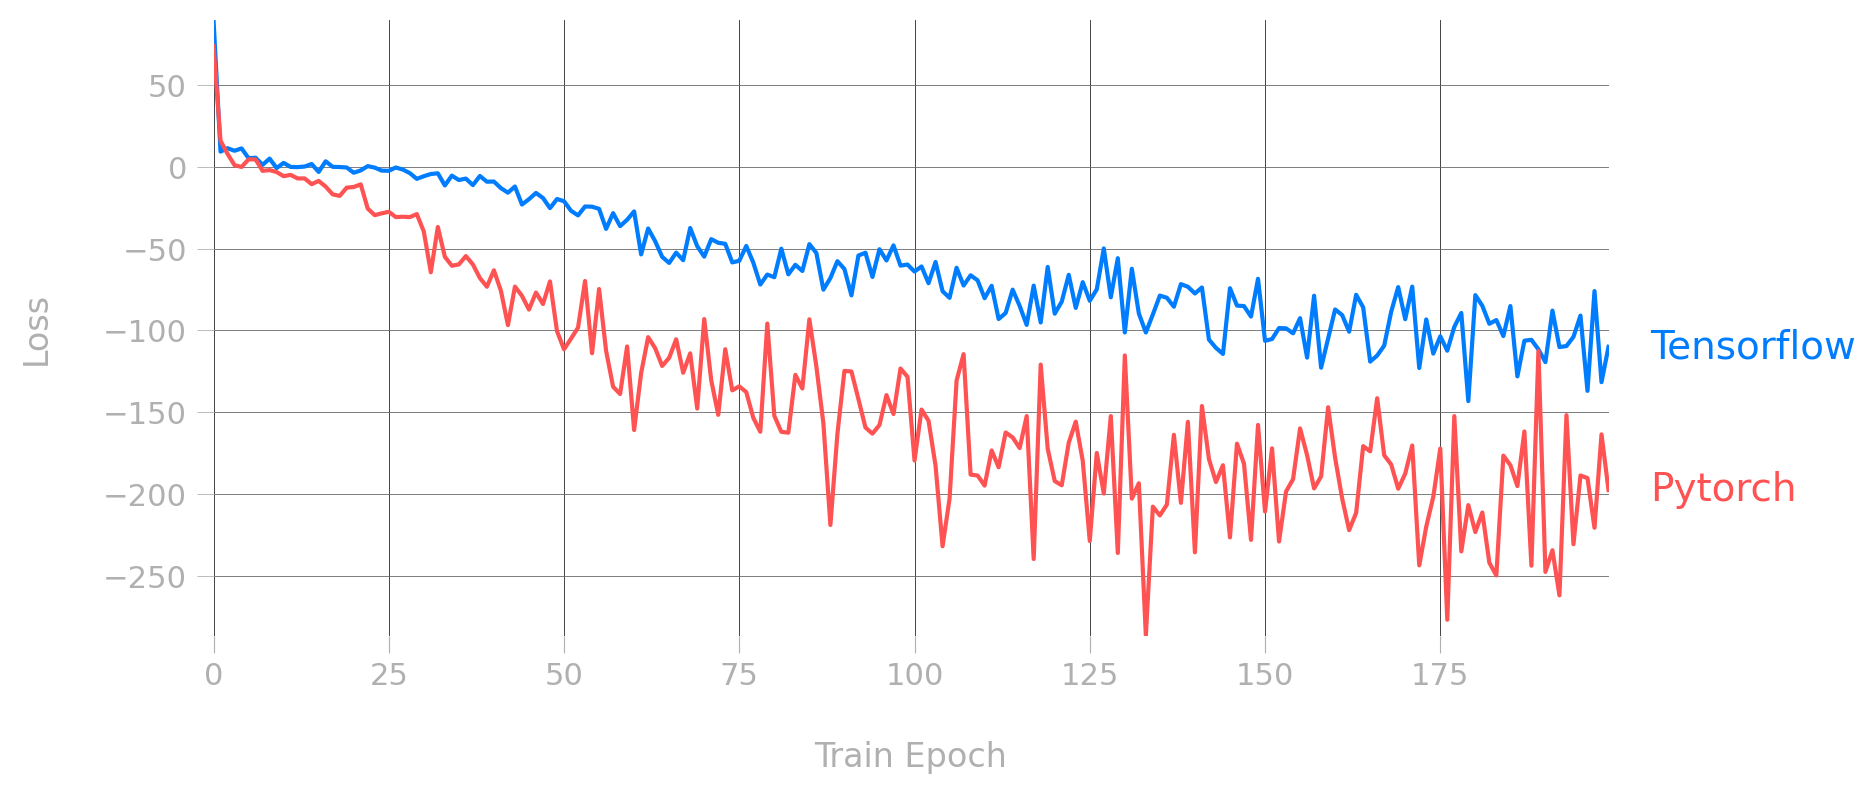

In [52]:
plt.style.use(matplotx.styles.dufte)
plt.rcParams.update({'axes.grid': True})
loss_tf = np.array(history_tf.history['loss'])
loss_pt = np.array(history_pt.history['loss'])

fig, ax = plot_both(ytf=loss_tf, ypt=loss_pt, figsize=(9, 4),
                    xlabel='Train Epoch', ylabel='Loss')
ax.grid(axis='y', color='#686868')

# Plot data

In [53]:
import warnings
warnings.filterwarnings('ignore')

### Aggregate metrics to plot

1. Identify all keys across both histories
2. 

In [54]:
keys = list(history_tf.history.keys()) + list(history_pt.history.keys())
ytf_dict = {key: dataset_tf.data_vars.get(key, None) for key in keys}
ypt_dict = {key: dataset_pt.data_vars.get(key, None) for key in keys}
yboth_dict = {}
for k in keys:
    ytf = ytf_dict.get(k, None)
    ypt = ypt_dict.get(k, None)
    if ytf is not None and ypt is not None:
        yboth_dict[k] = {
            'pt': ypt,
            'tf': ytf,
        }
#yboth_dict = {k: {'pt': ypt_dict.get(k, None), 'tf': ytf_dict.get(k, None)} for k in keys}
ytf_dict = {k: v for k, v in ytf_dict.items() if v is not None}
ypt_dict = {k: v for k, v in ypt_dict.items() if v is not None}

In [38]:
ytf_dict.keys()
ypt_dict.keys()
yboth_dict.keys()

dict_keys(['era', 'epoch', 'dt', 'loss', 'acc', 'acc_mask', 'logdet'])

dict_keys(['era', 'epoch', 'dt', 'loss', 'acc', 'acc_mask', 'logdet', 'xeps', 'veps', 'energy', 'logprob', 'sumlogdet'])

dict_keys(['era', 'epoch', 'dt', 'loss', 'acc', 'acc_mask', 'logdet'])

### Plot `TensorFlow` training data:

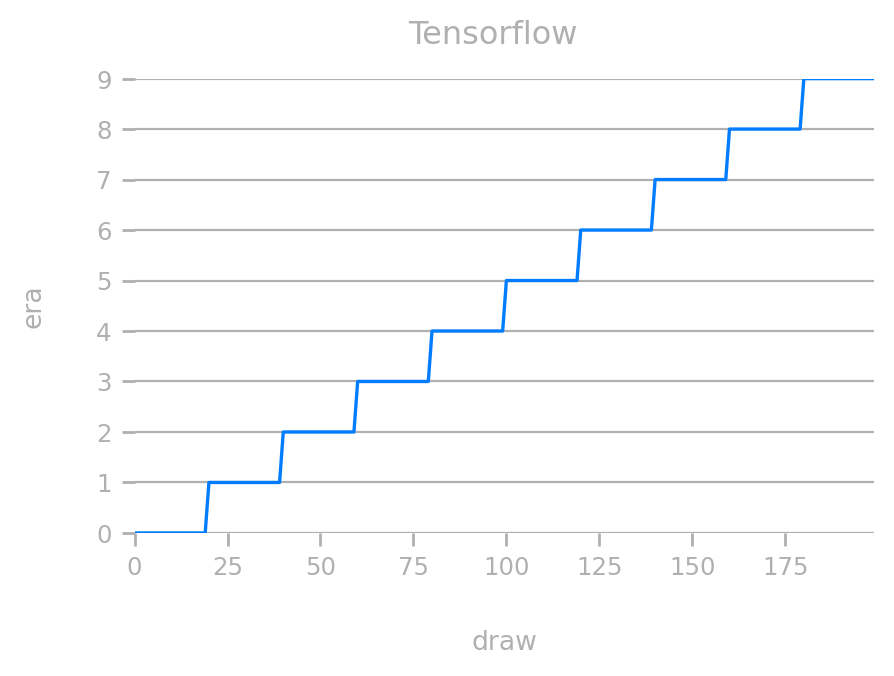

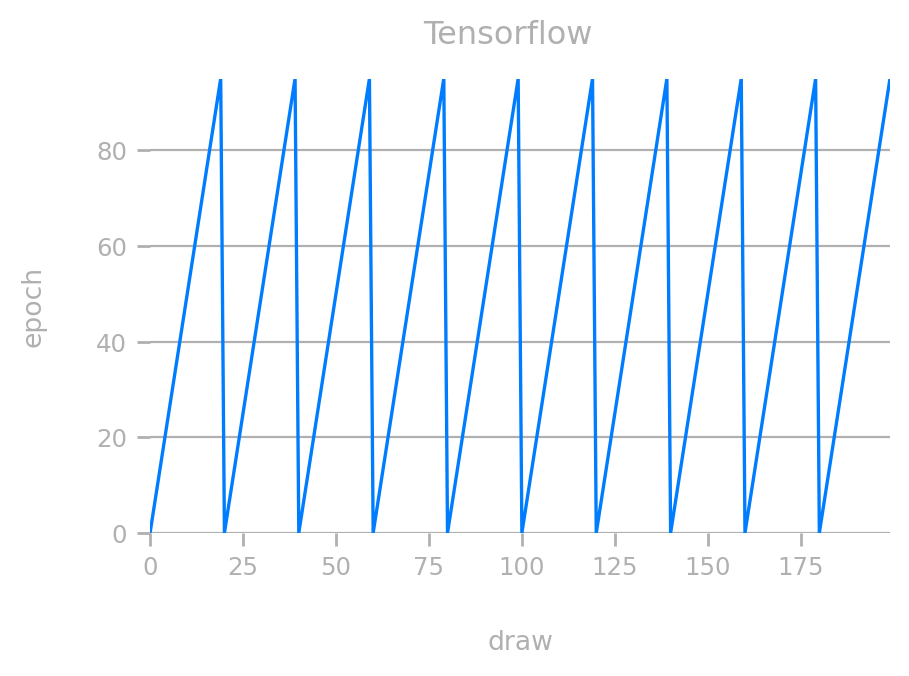

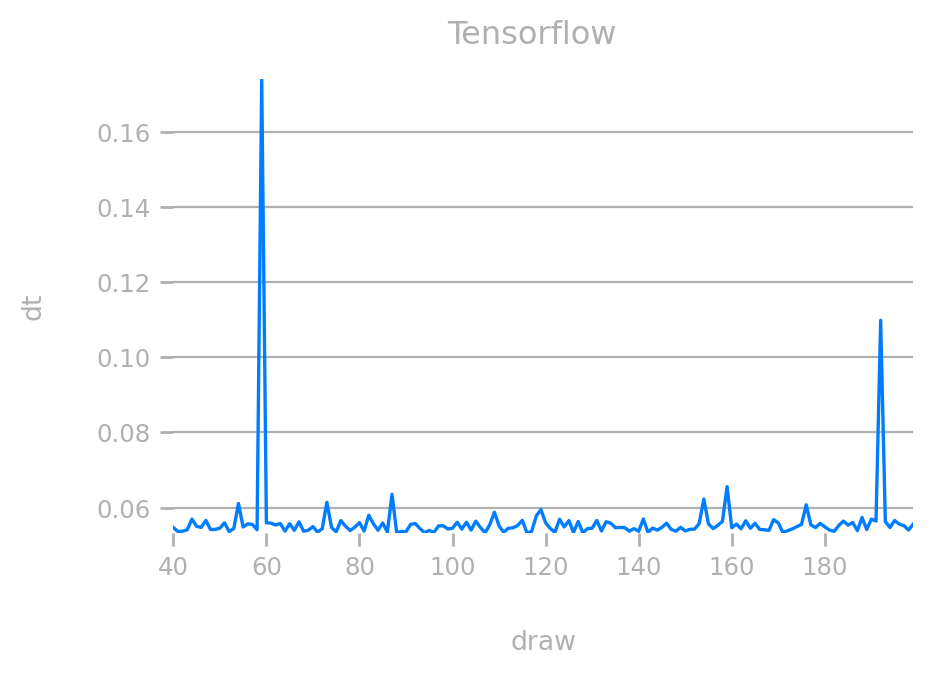

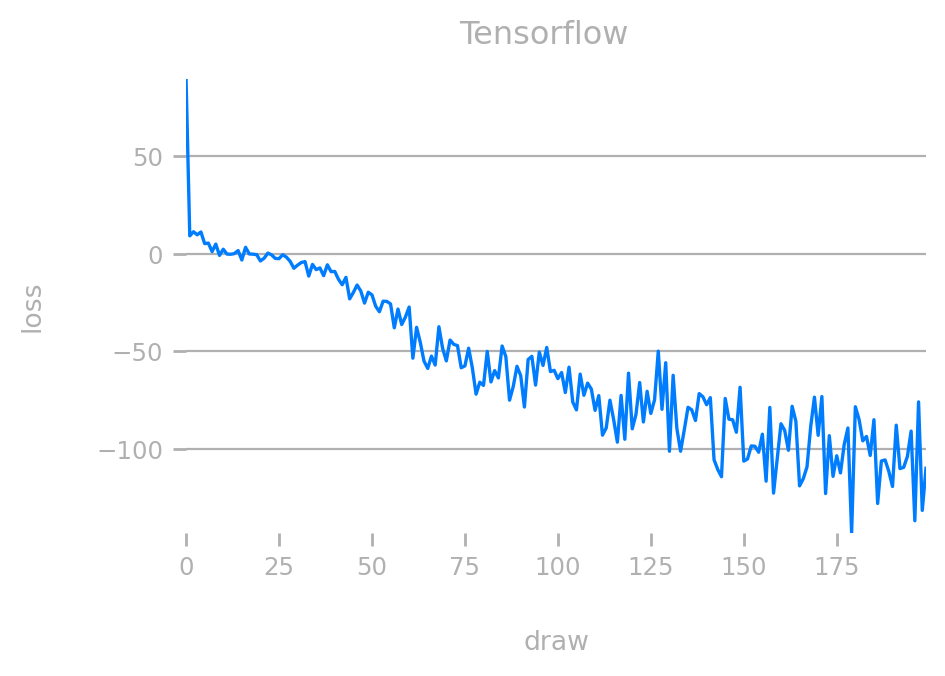

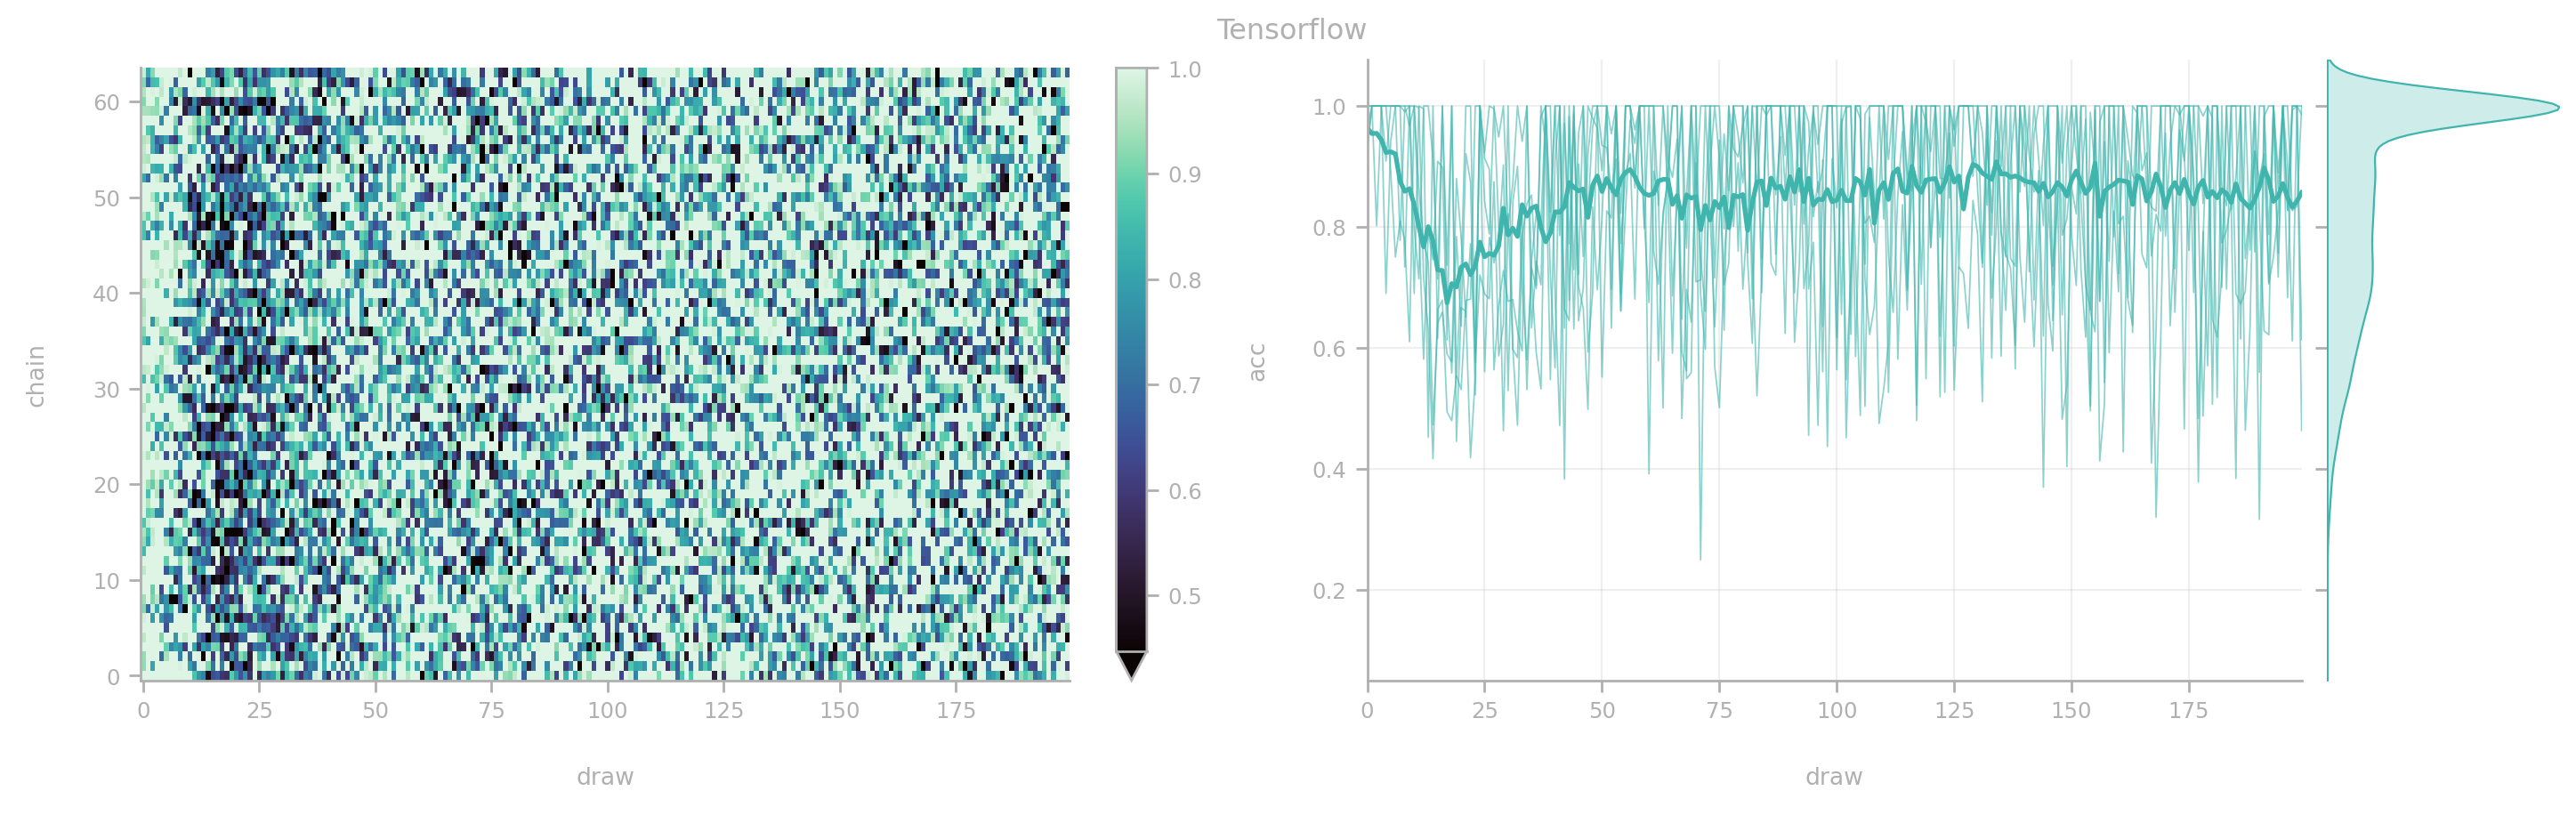

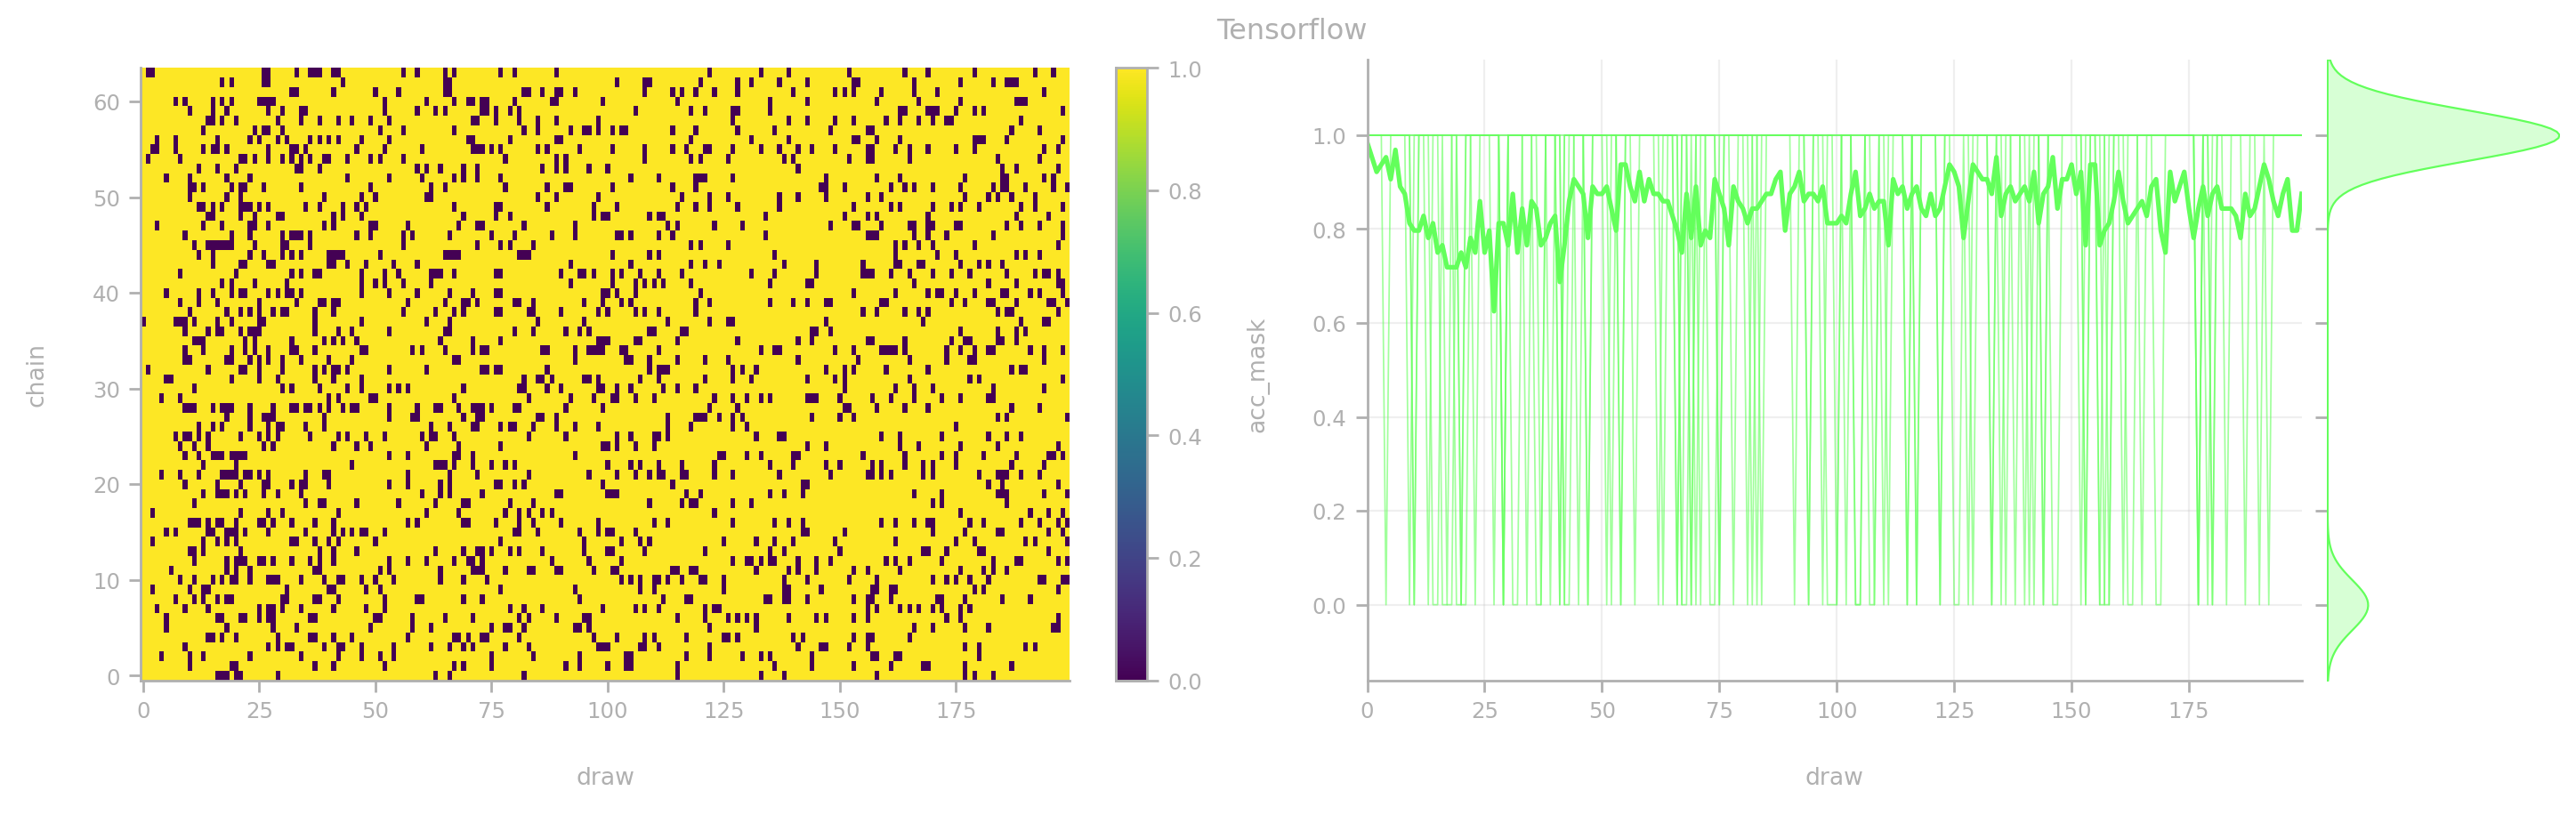

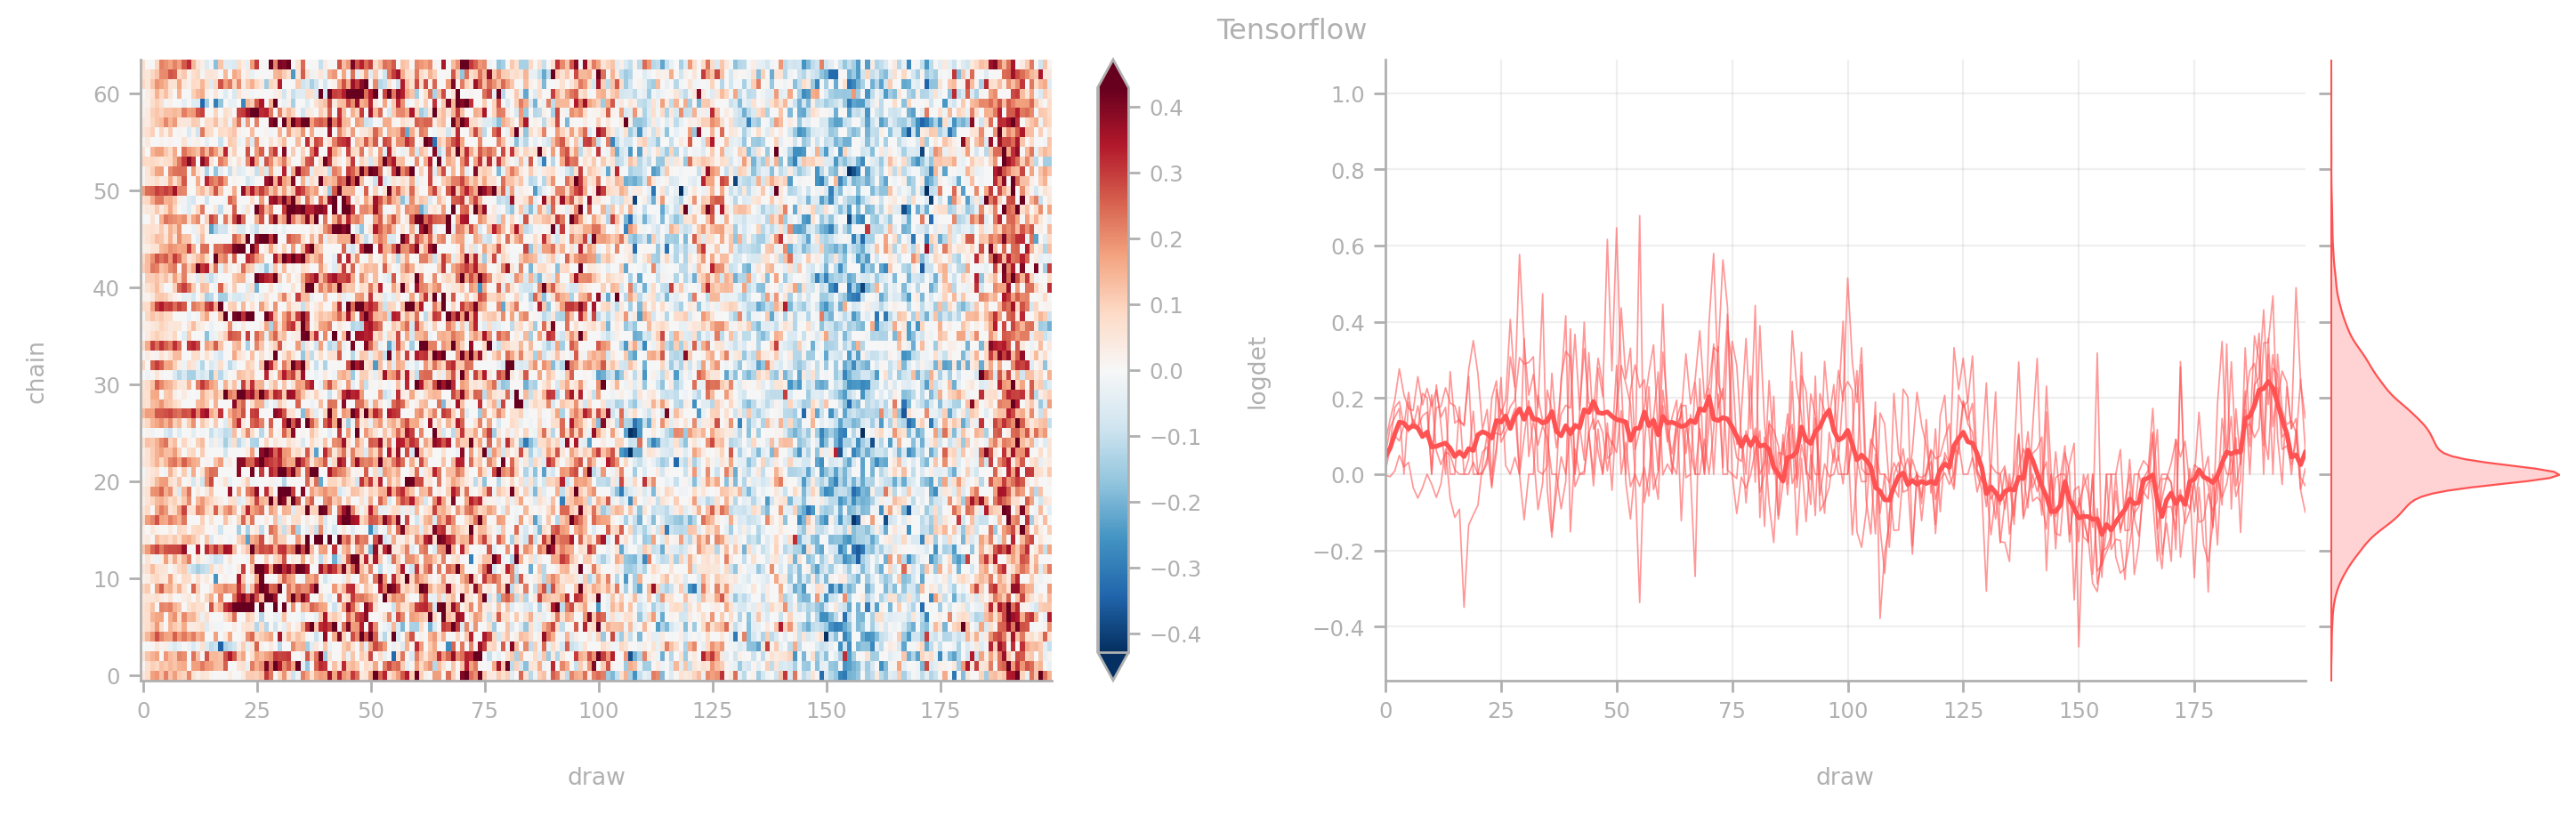

In [55]:
plt.style.use(matplotx.styles.dufte)
import src.l2hmc.utils.plot_helpers as hplt
sns.set_palette(list(colors.values()))
sns.set_context('paper')
plt.rcParams.update({
    'figure.dpi': plt.rcParamsDefault['figure.dpi'],
    'figure.figsize': plt.rcParamsDefault['figure.figsize'],
})
for key, val in ytf_dict.items():
    fig, subfigs, axes = hplt.plot_dataArray(val,
                                             key=key,
                                             num_chains=5,
                                             title='Tensorflow');

### Plot `PyTorch` training data:

In [56]:
sns.set_context('notebook')

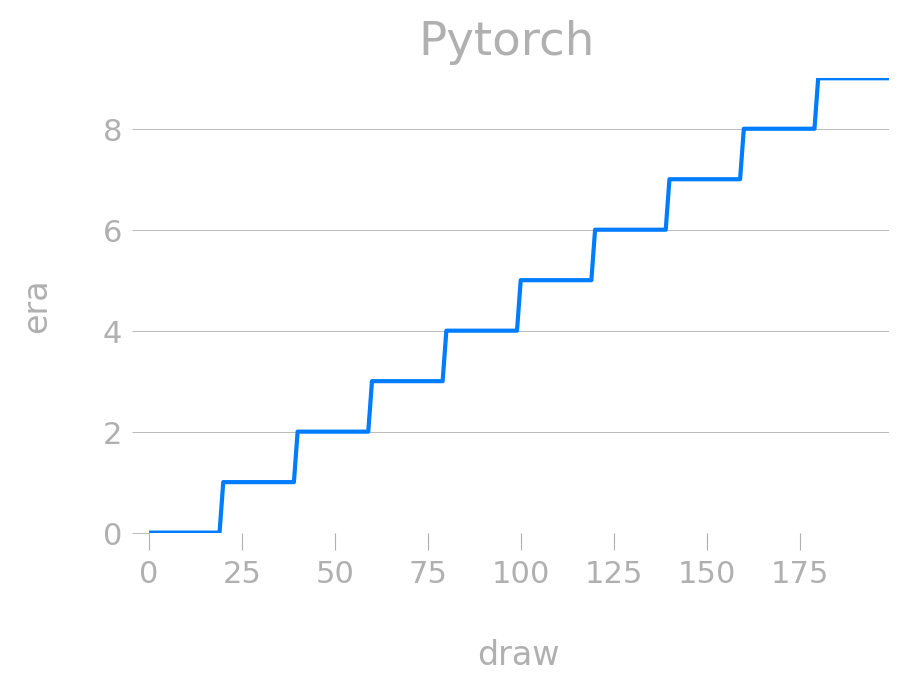

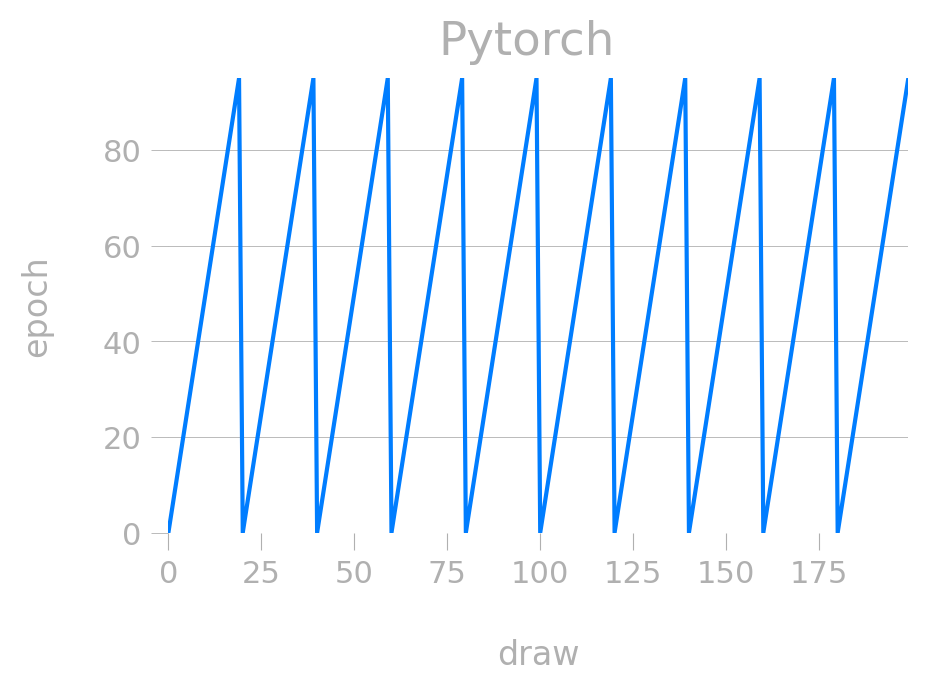

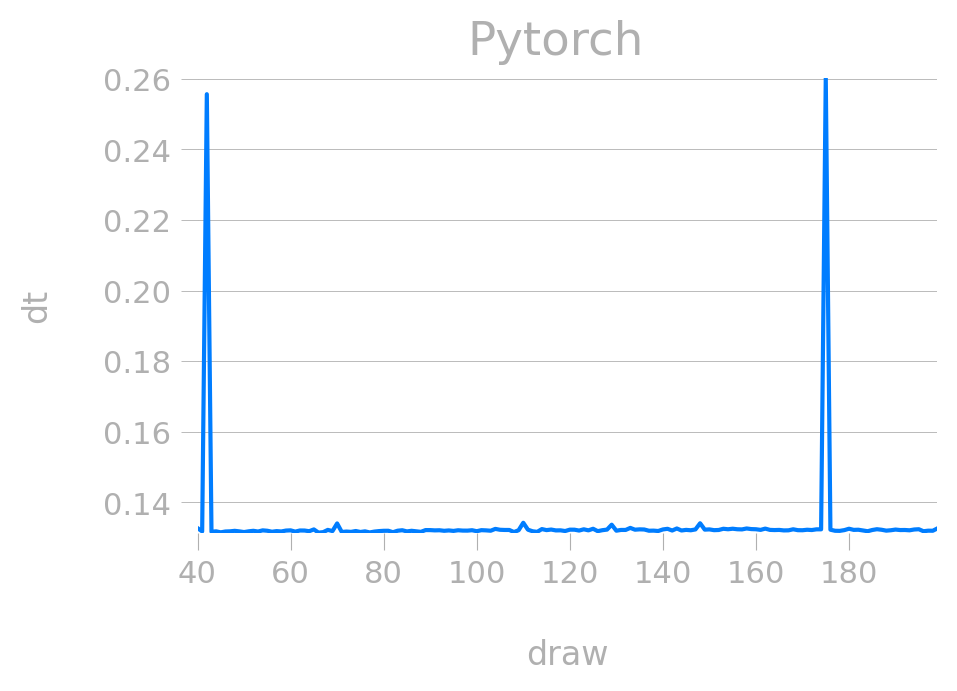

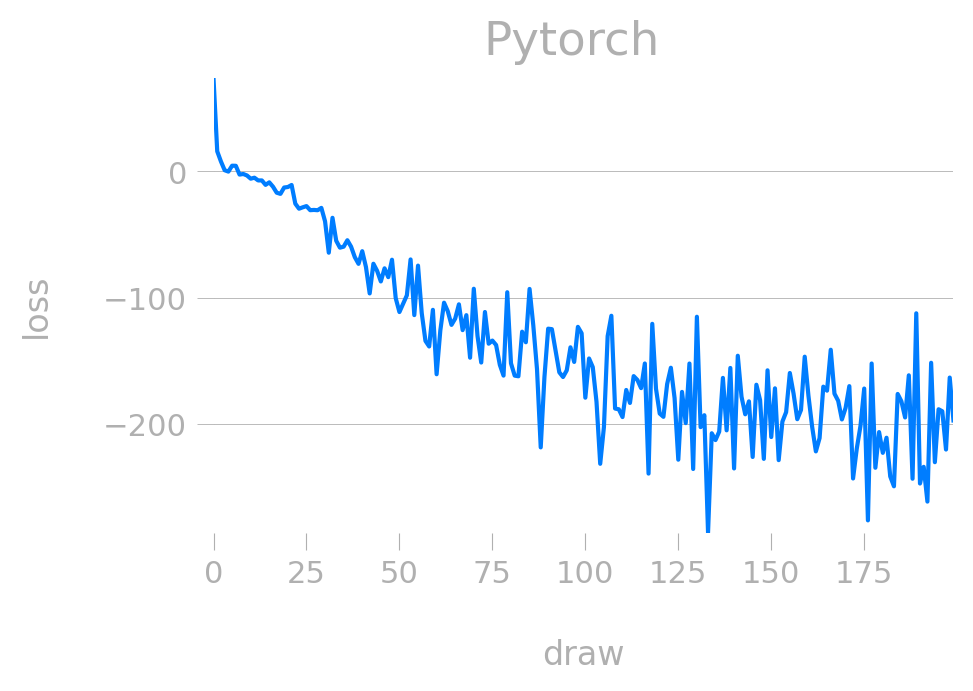

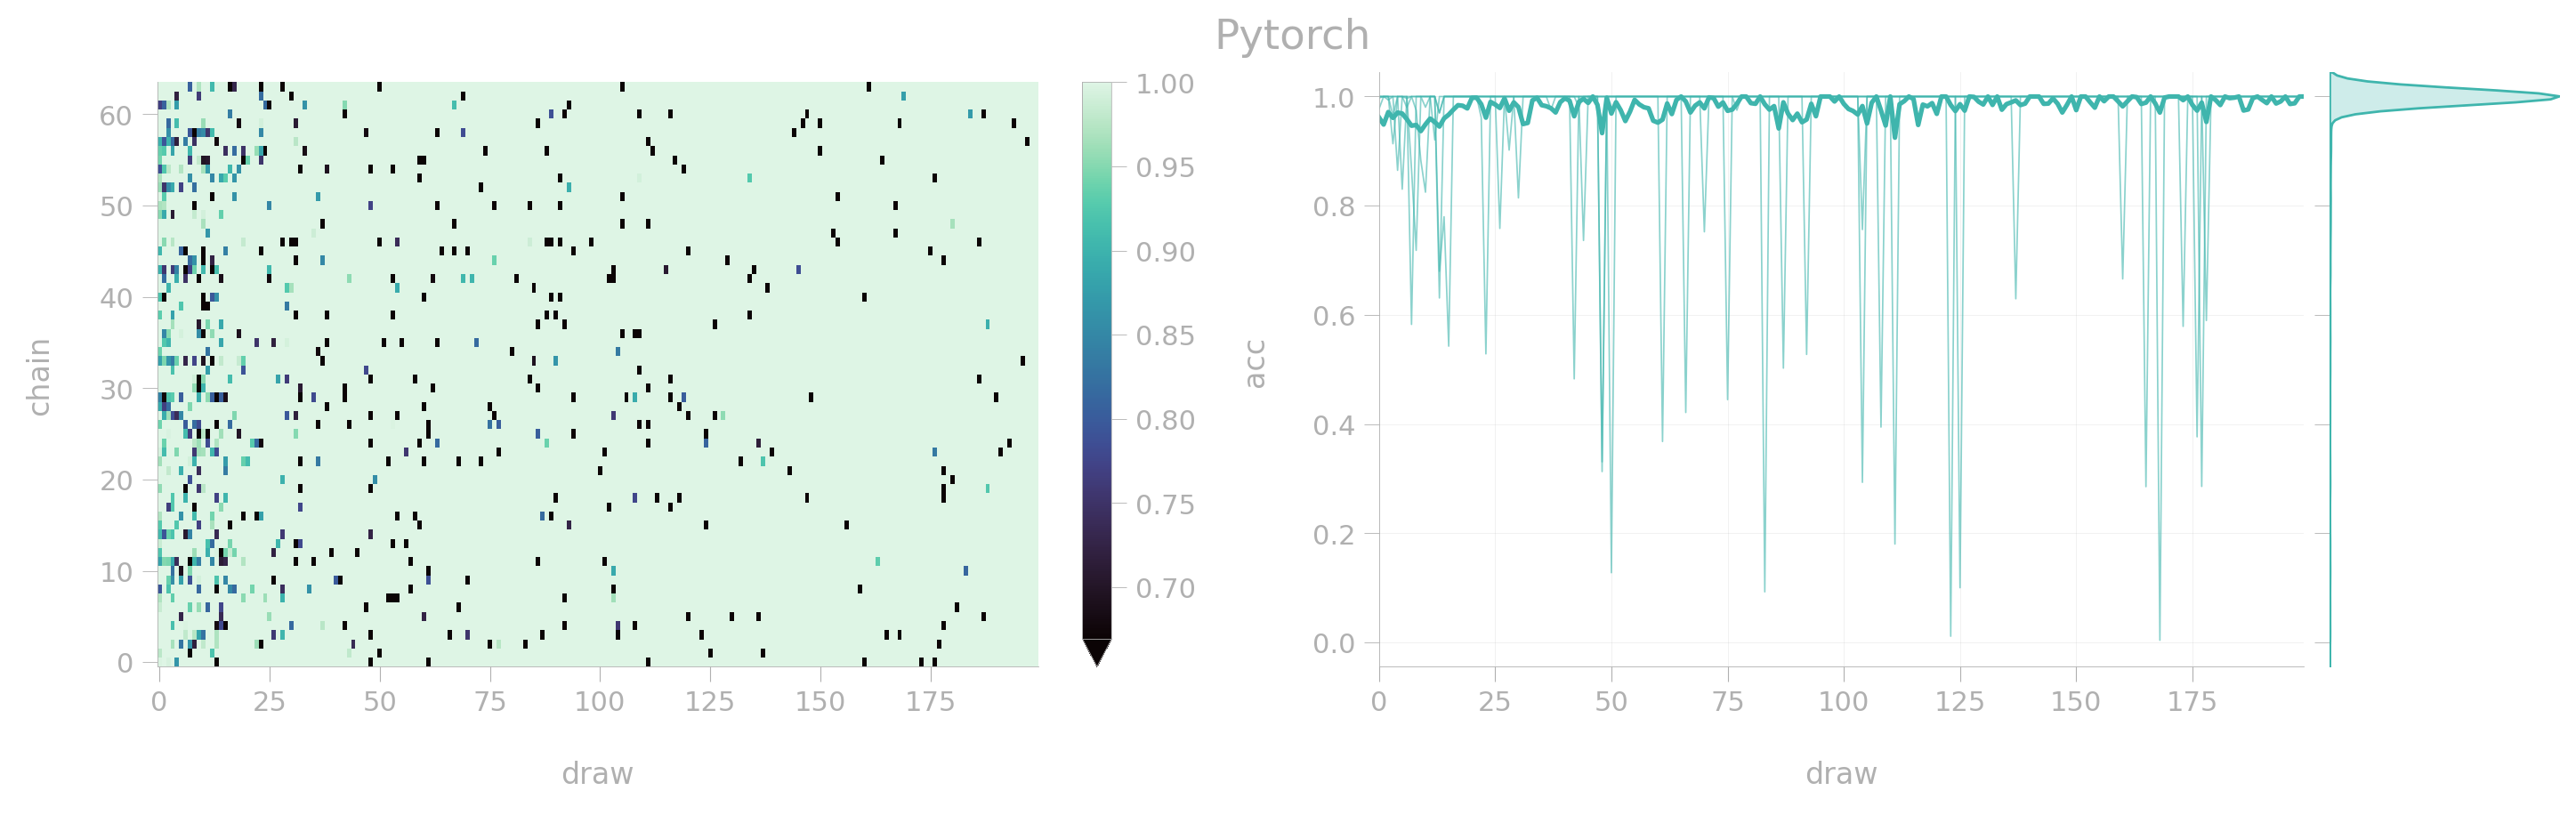

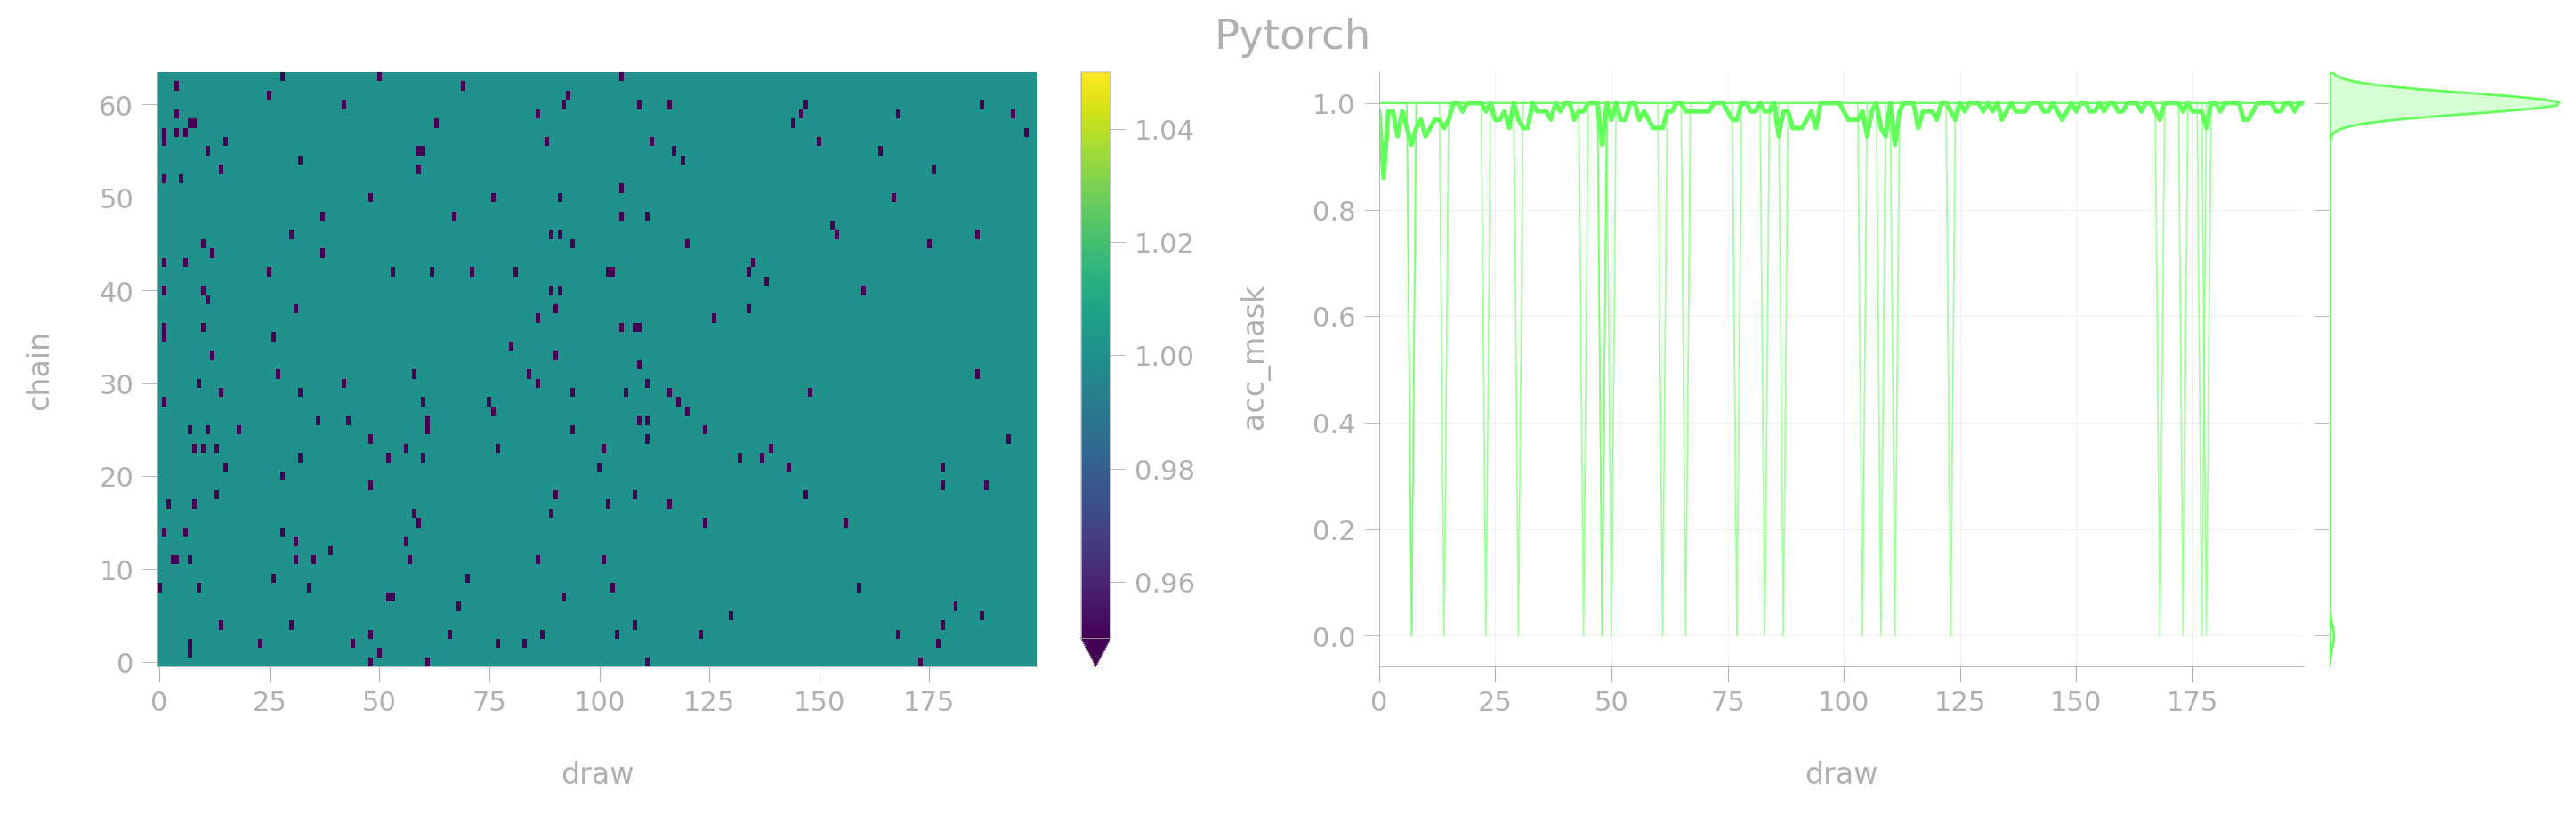

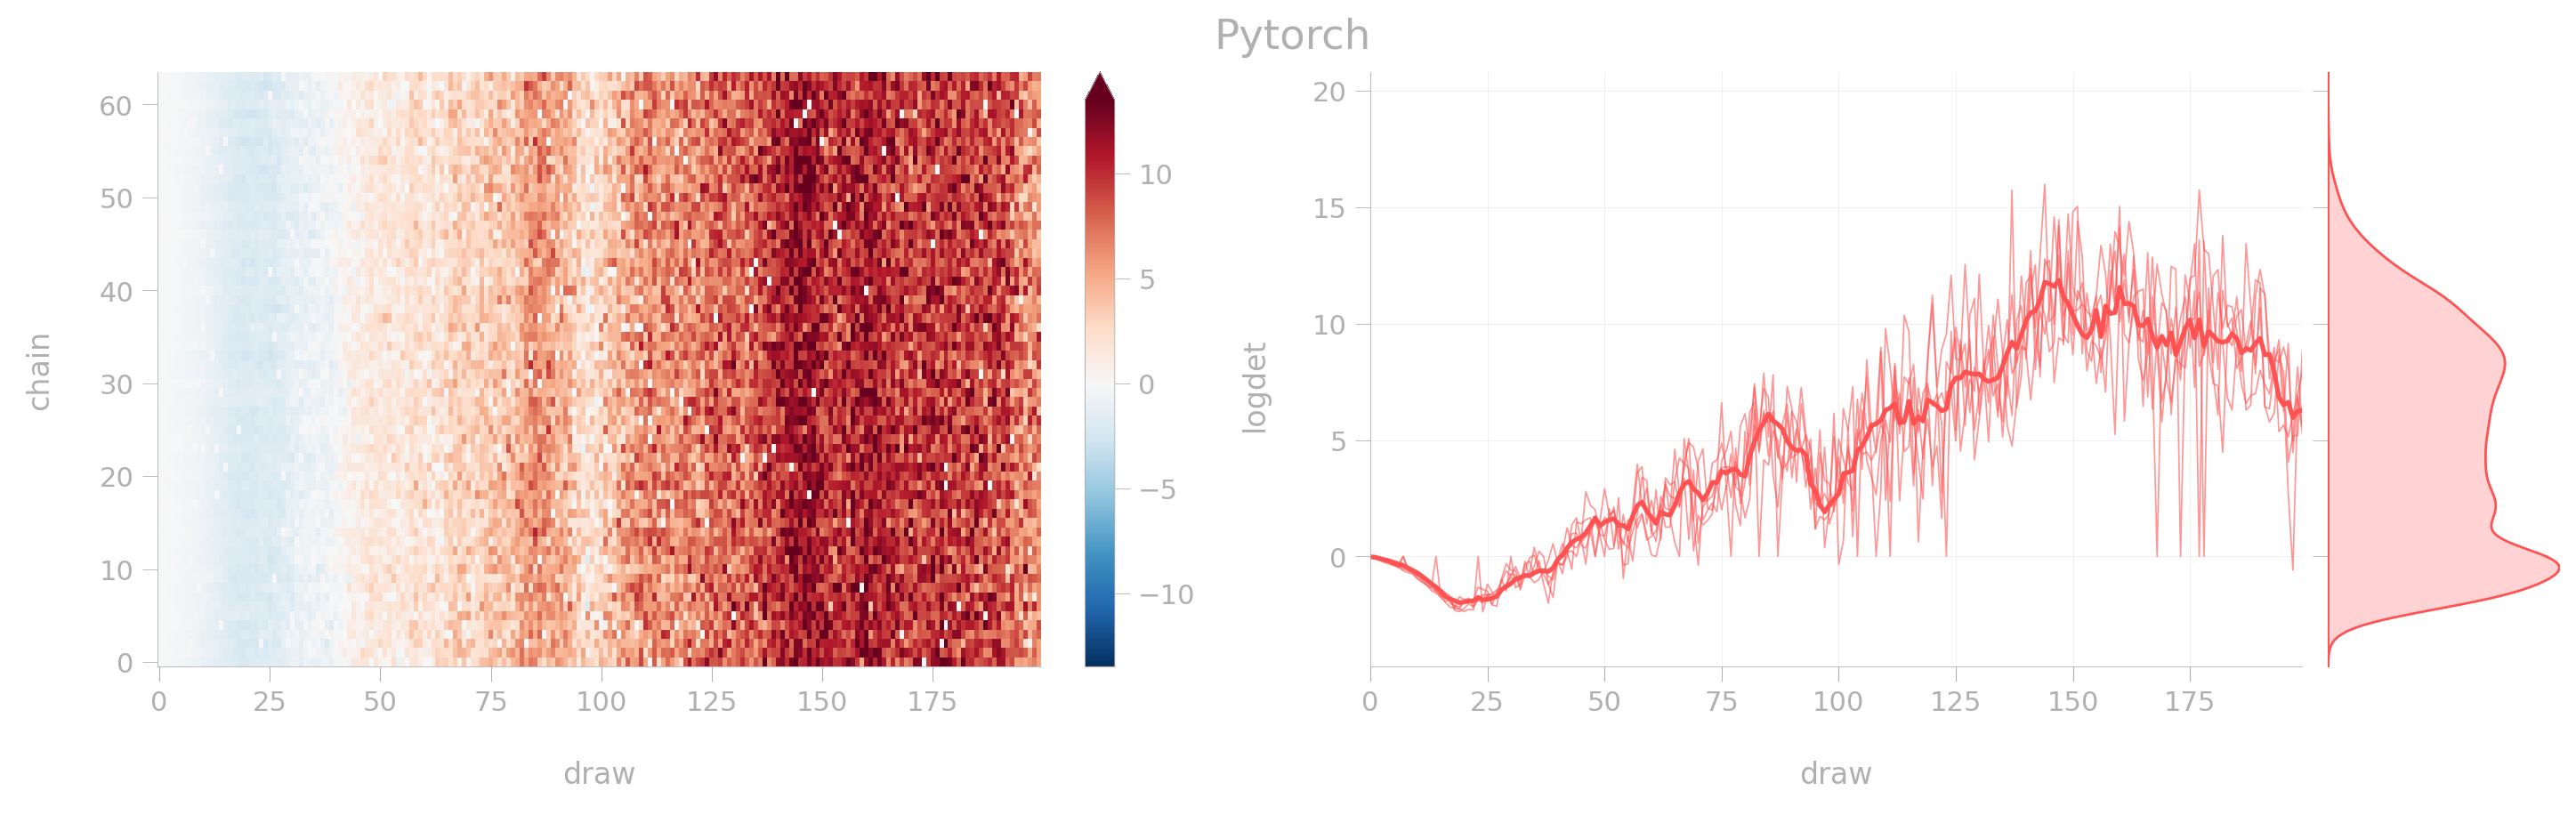

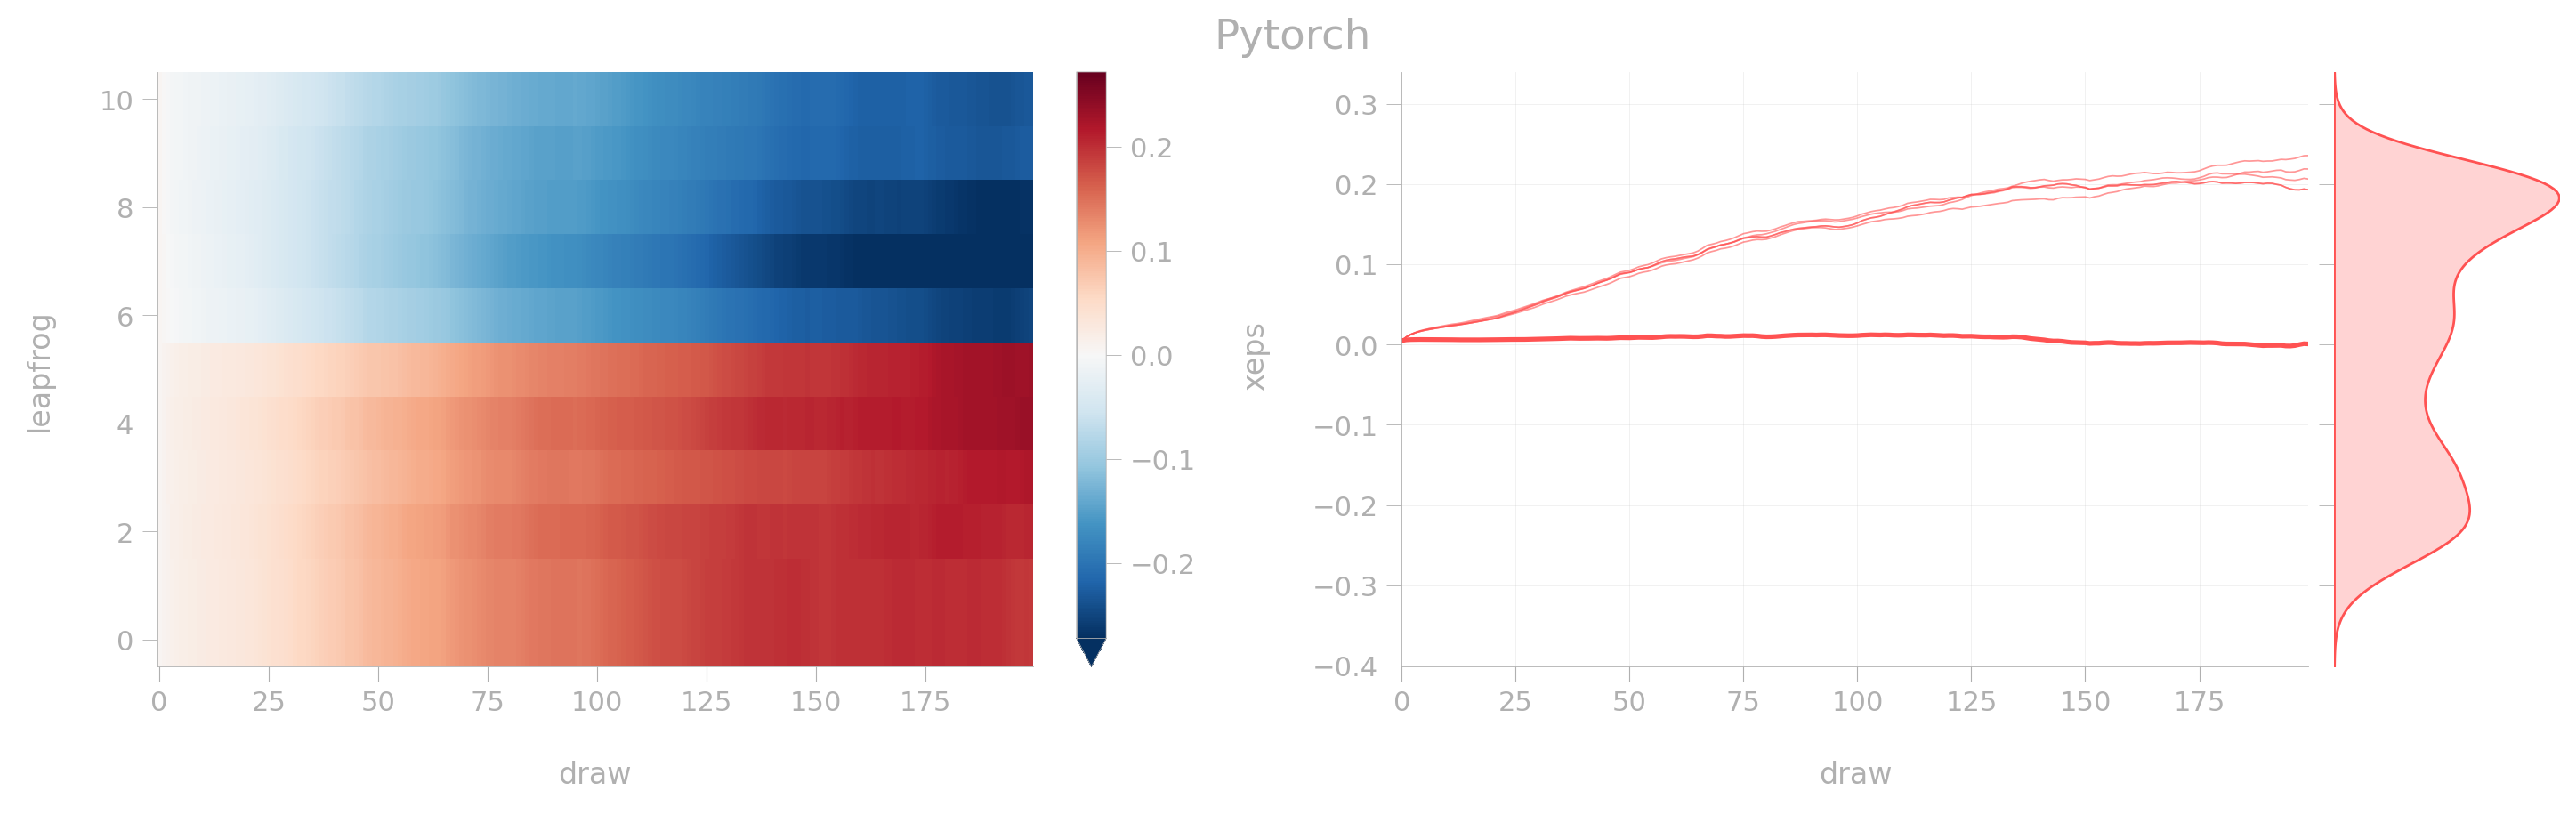

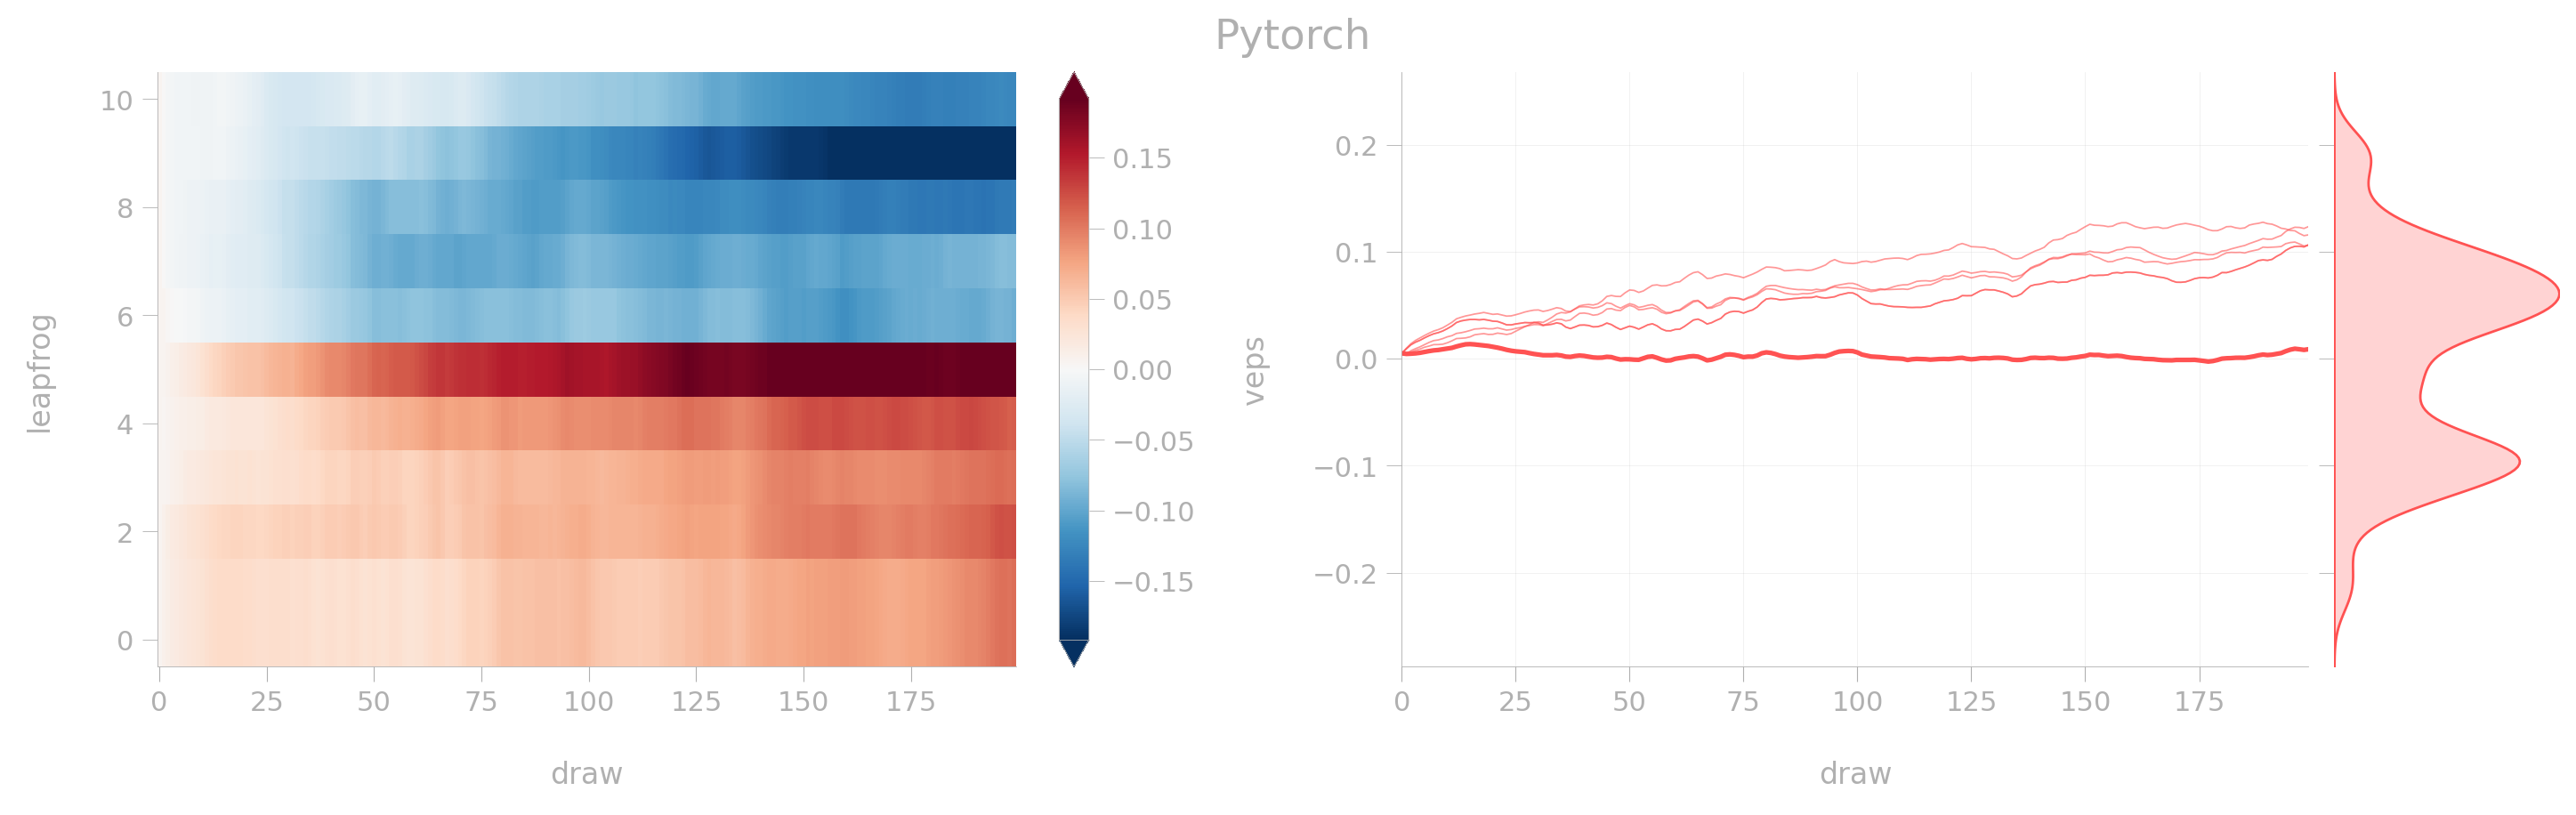

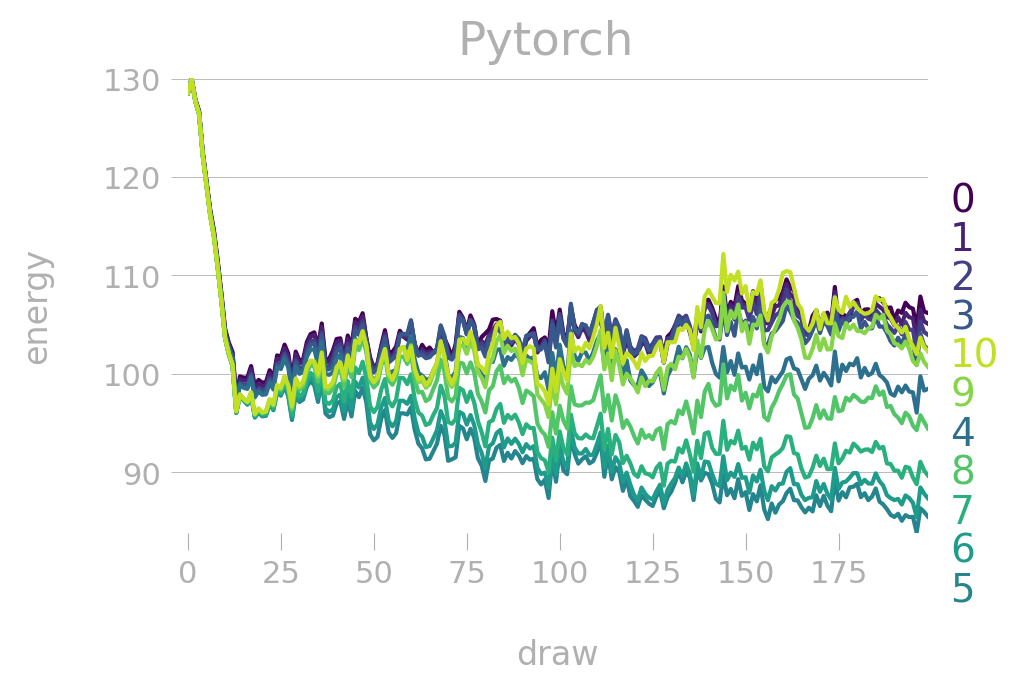

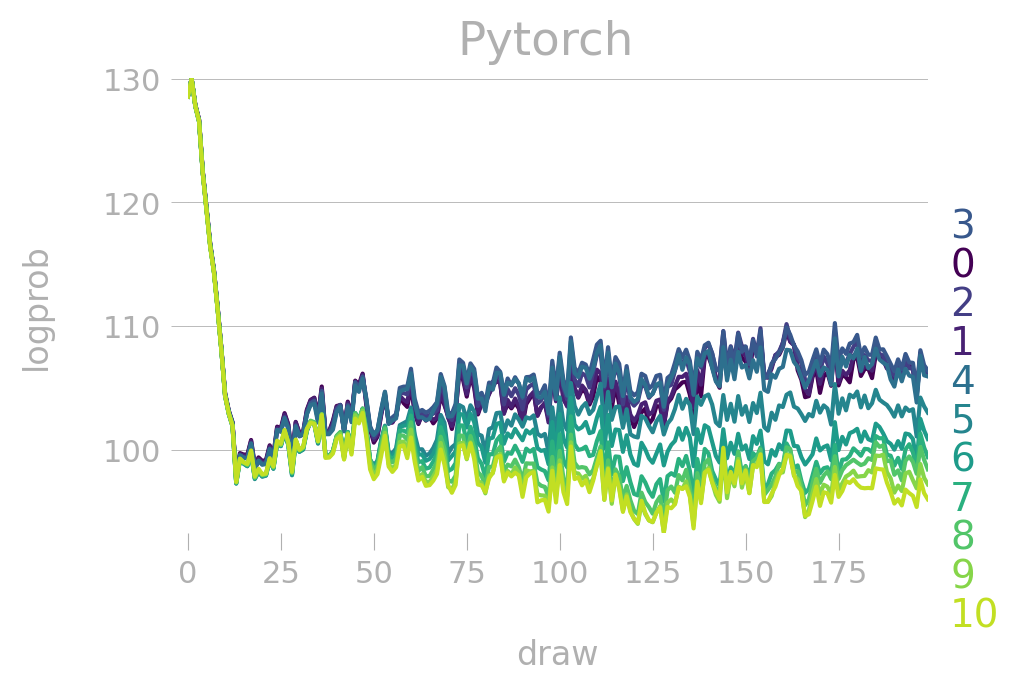

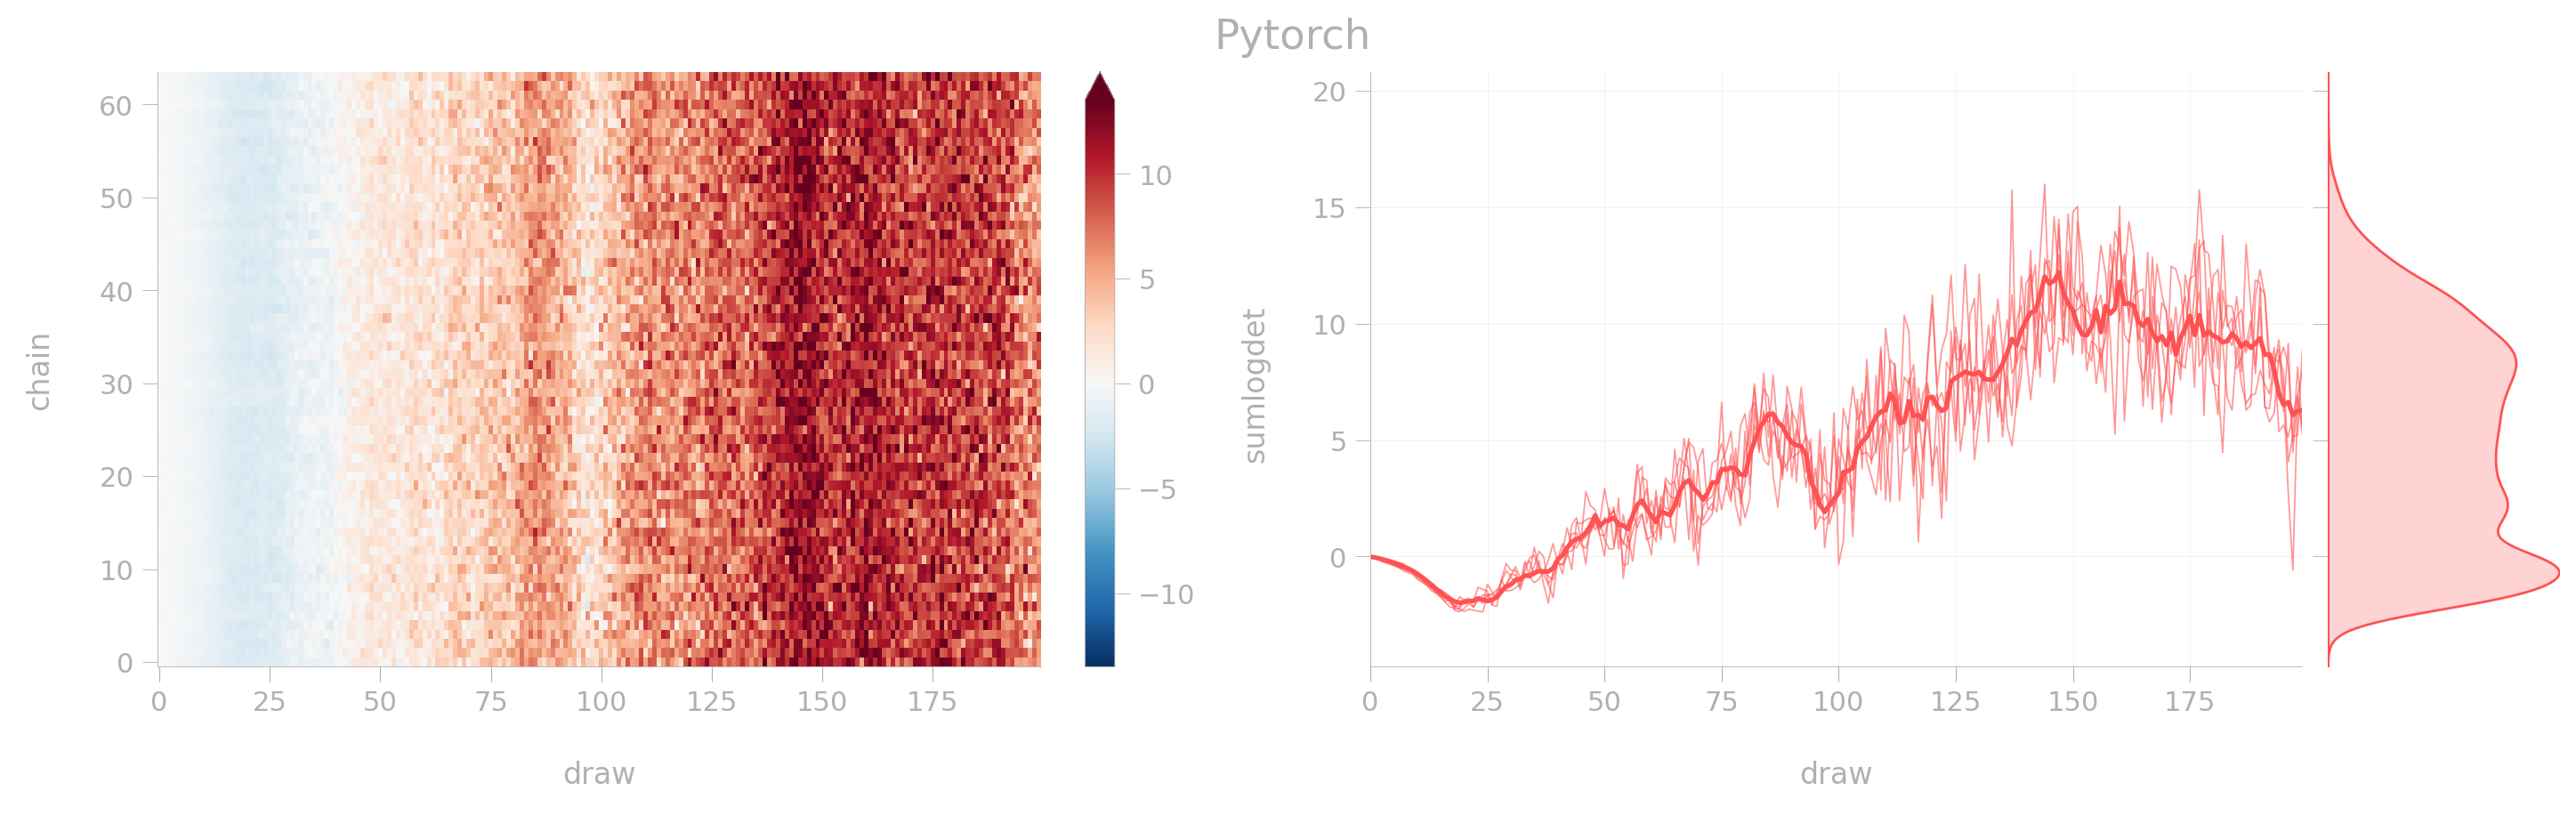

In [57]:
plt.style.use(matplotx.styles.dufte)
for key, val in ypt_dict.items():
    fig, subfigs, axes = hplt.plot_dataArray(val,
                                             key=key,
                                             num_chains=5,
                                             title='Pytorch')

## Plot metrics common to both training datasets for comparison:

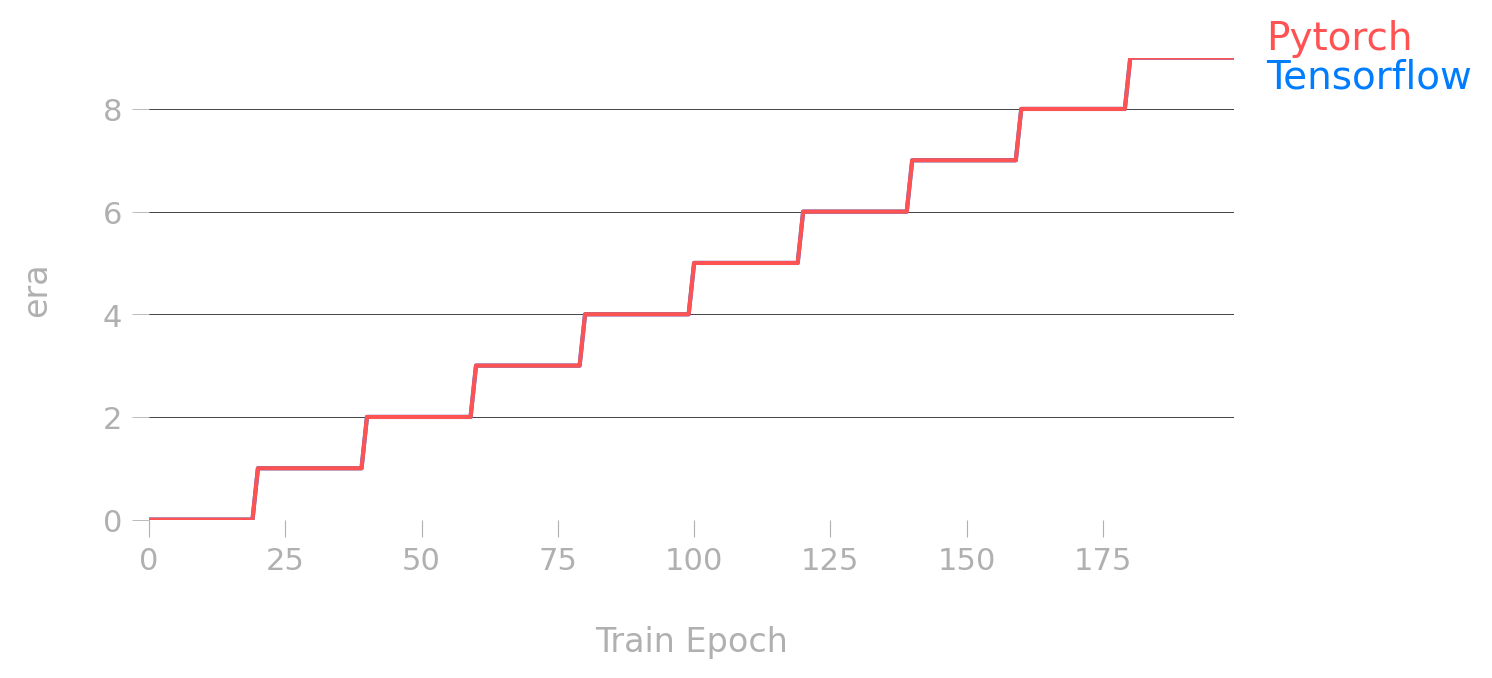

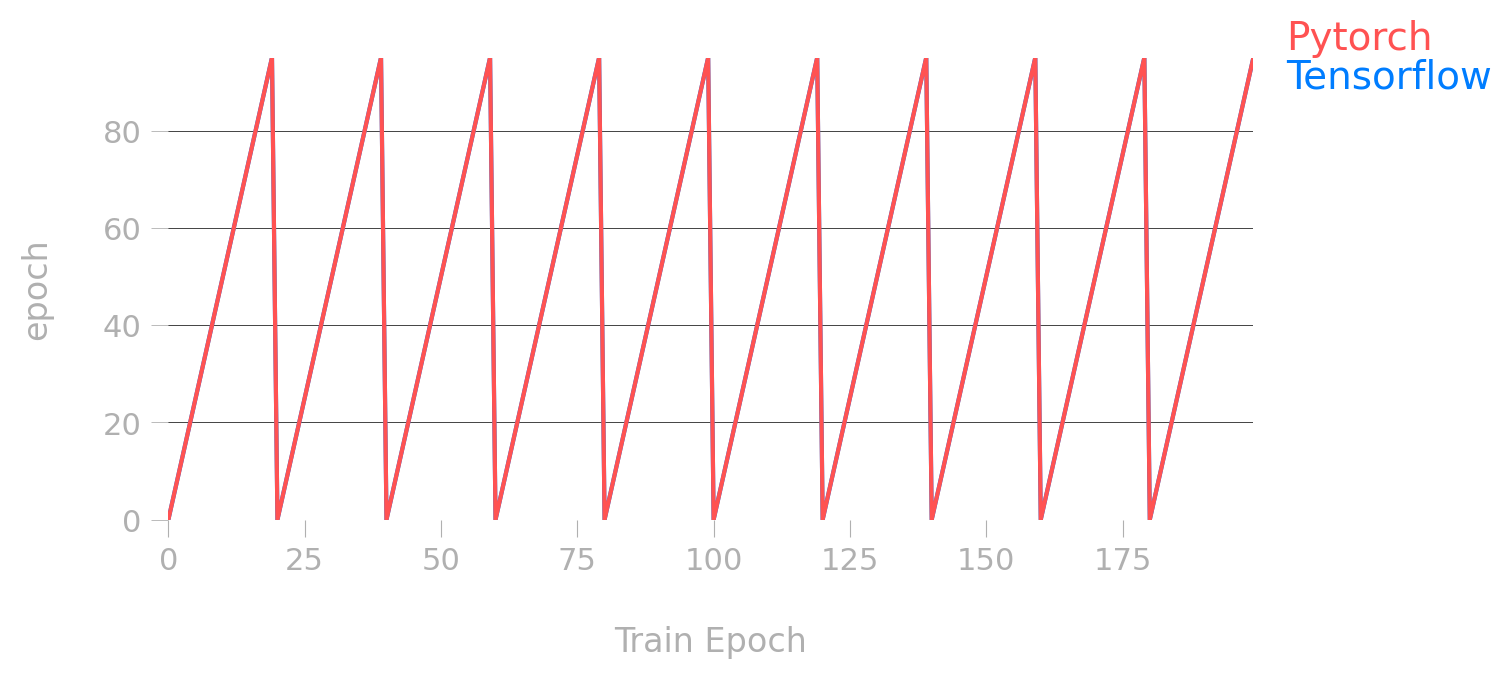

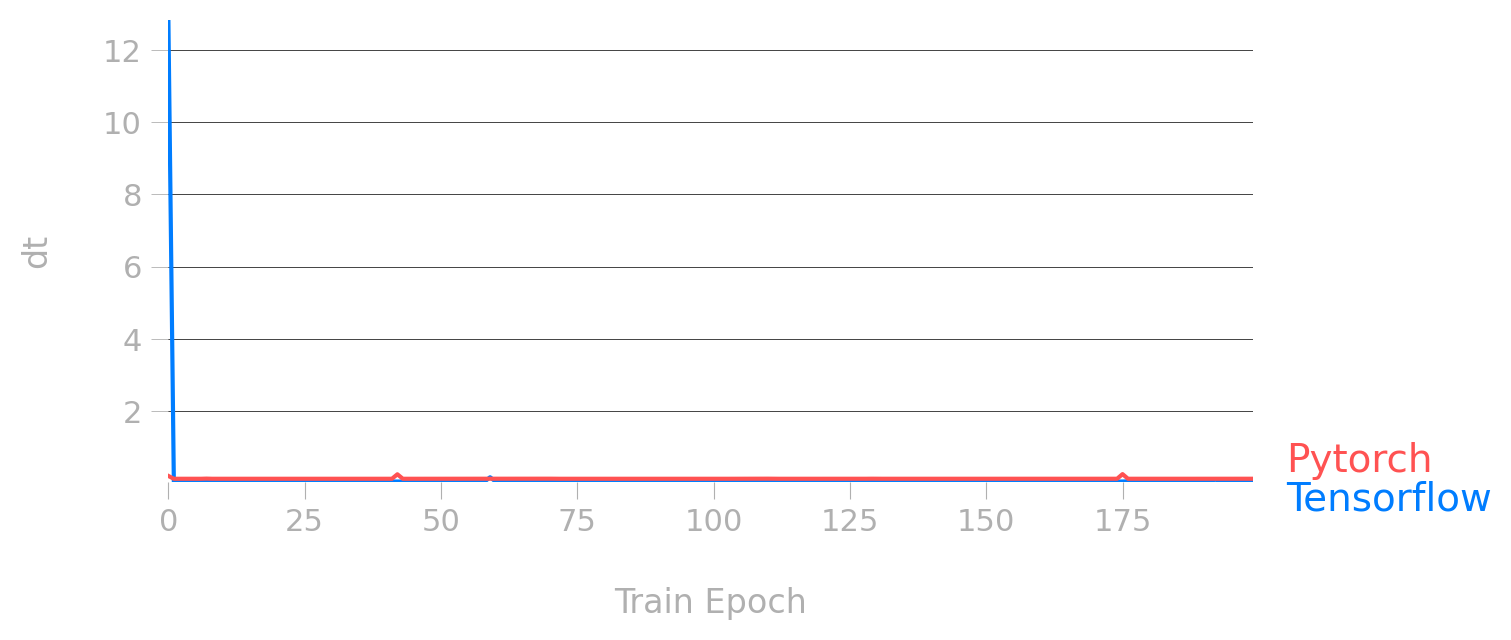

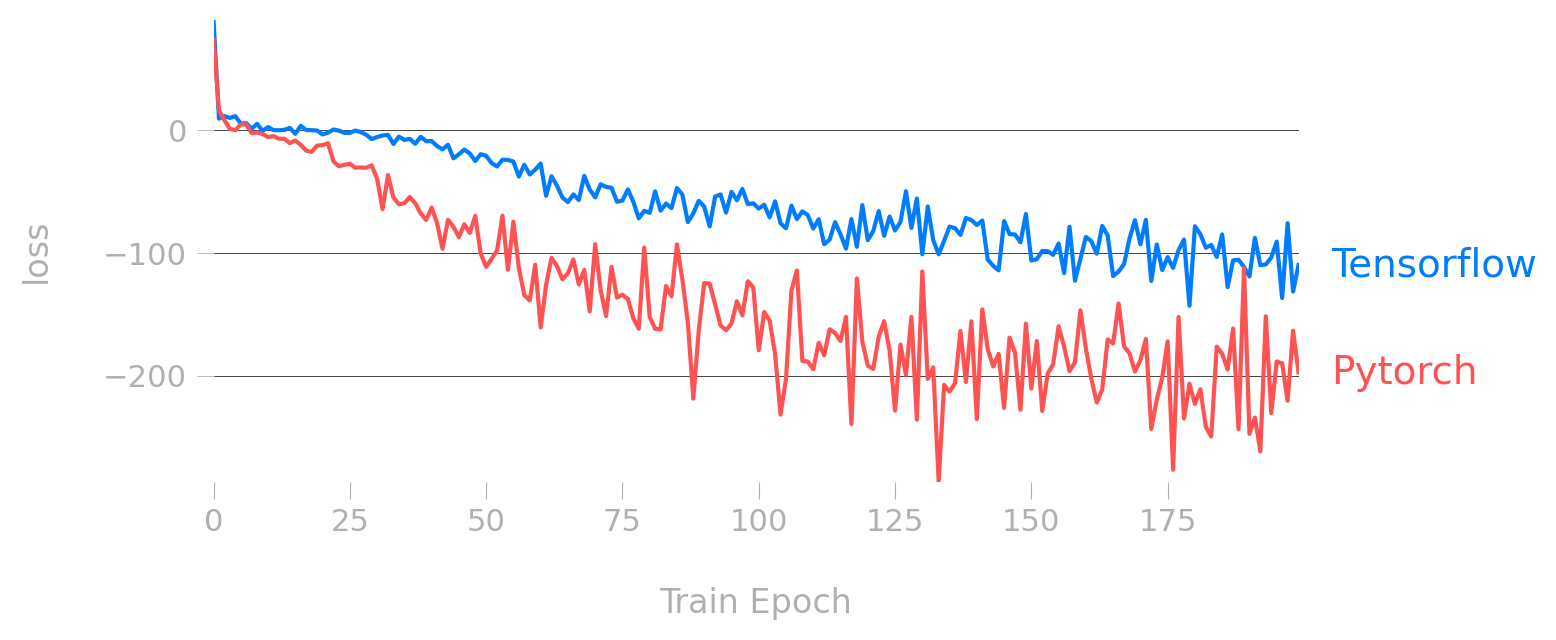

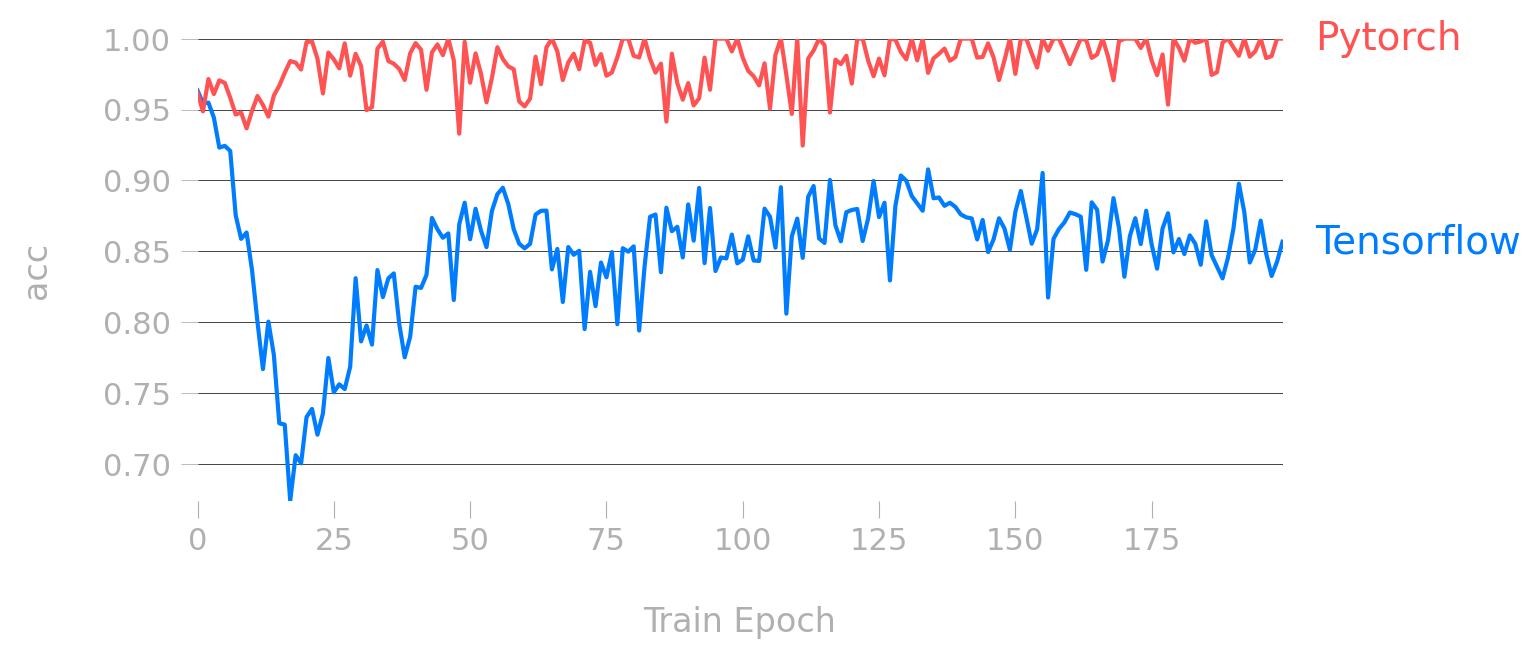

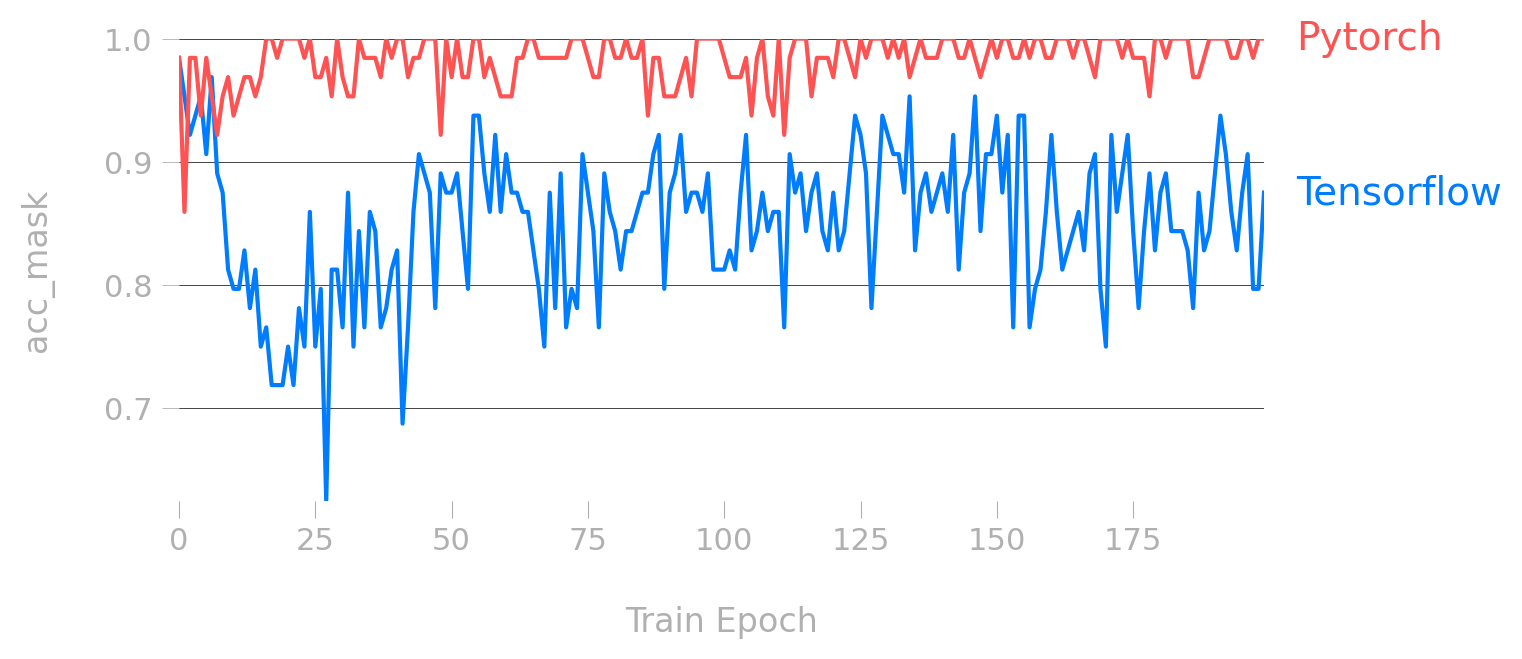

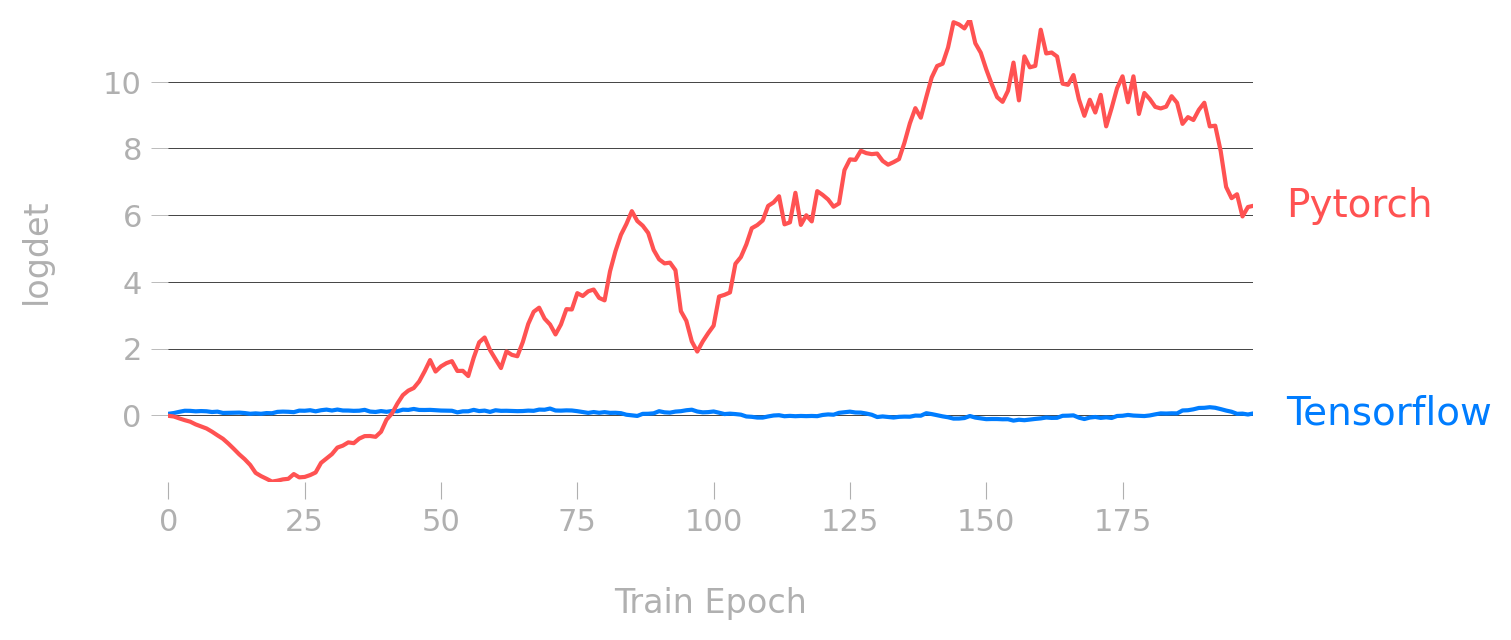

In [58]:
for key, val in yboth_dict.items():
    with plt.style.context(matplotx.styles.dufte):
        ytf = val['tf']
        ypt = val['pt']

        if len(ytf.shape) == 2:
            ytf = ytf.mean('chain')
            ypt = ypt.mean('chain')

        fig, ax = plot_both(ytf=ytf,
                            ypt=ypt,
                            figsize=FIGSIZE,
                            xlabel='Train Epoch', ylabel=key)
        _ = ax.grid(visible=False, axis='x');

## Plot **all** `TensorFlow` training metrics:

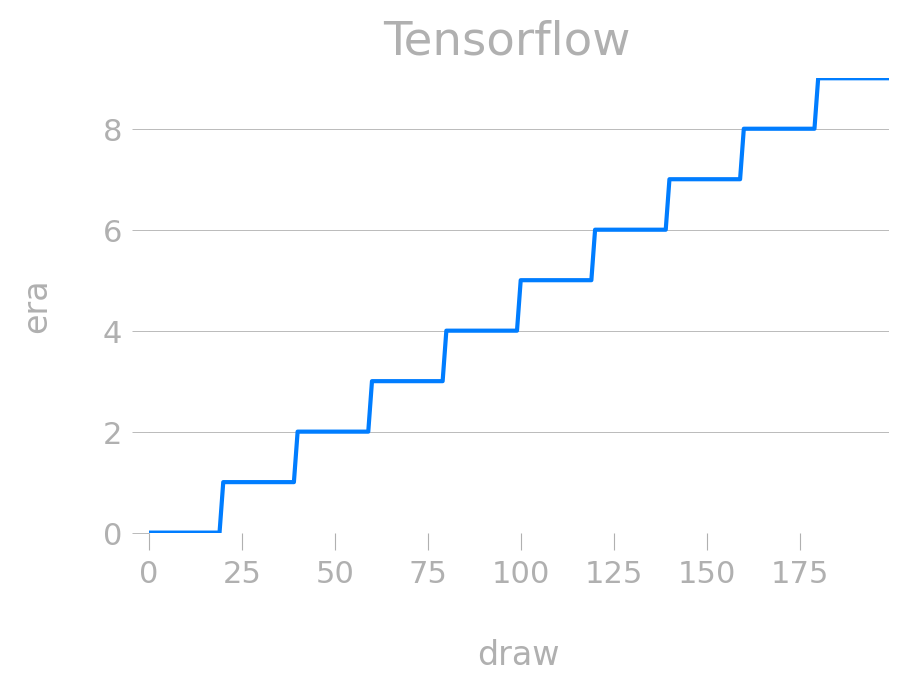

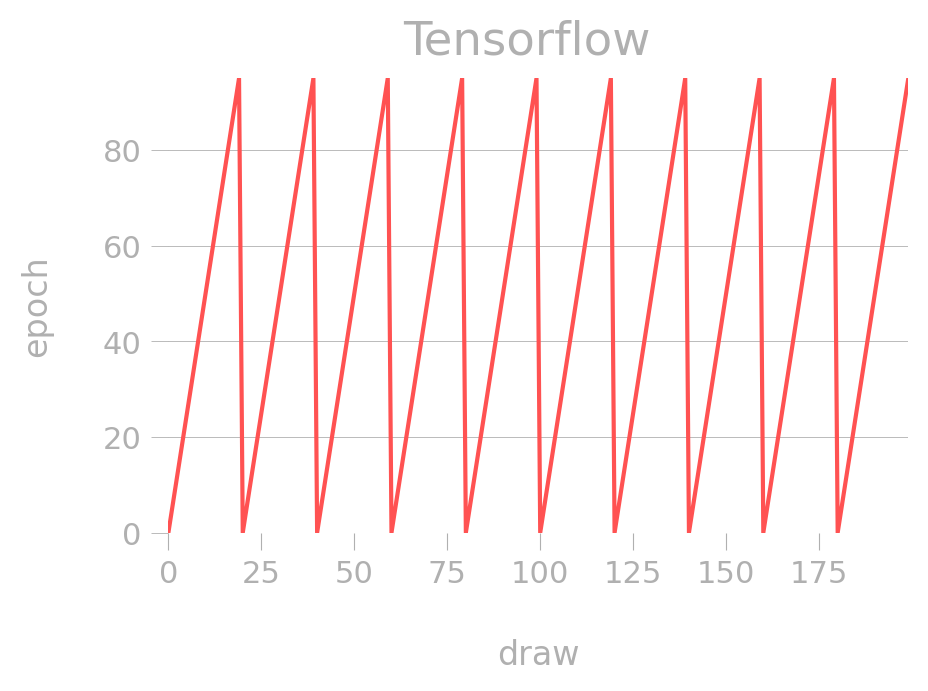

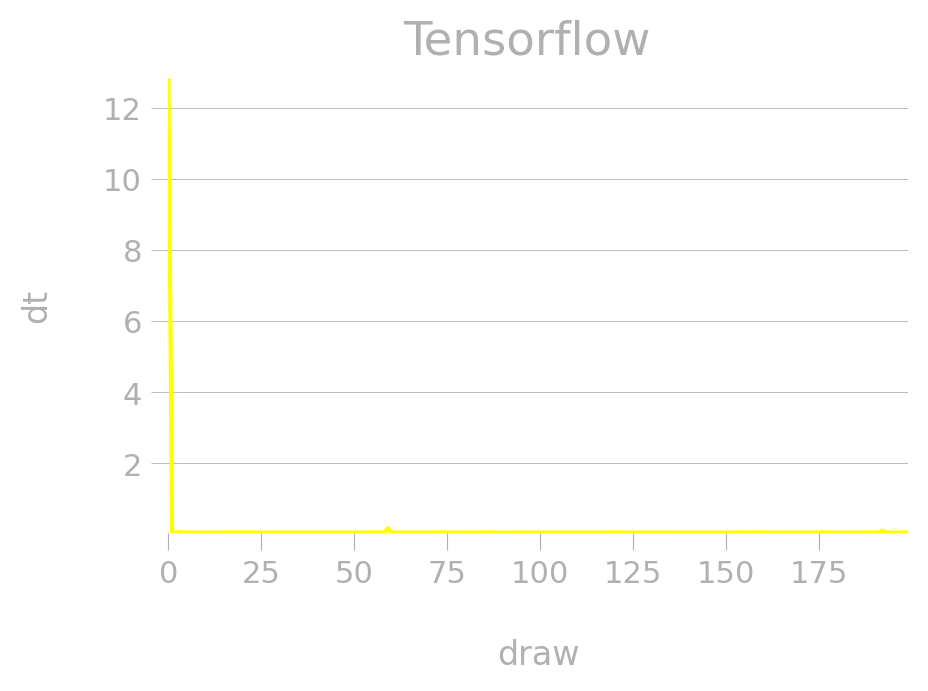

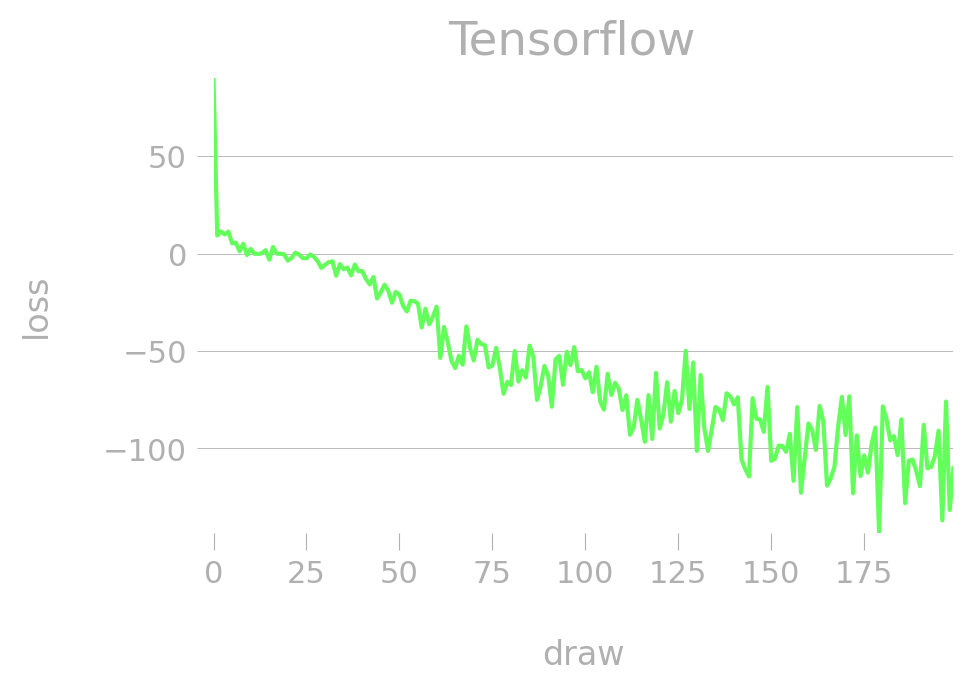

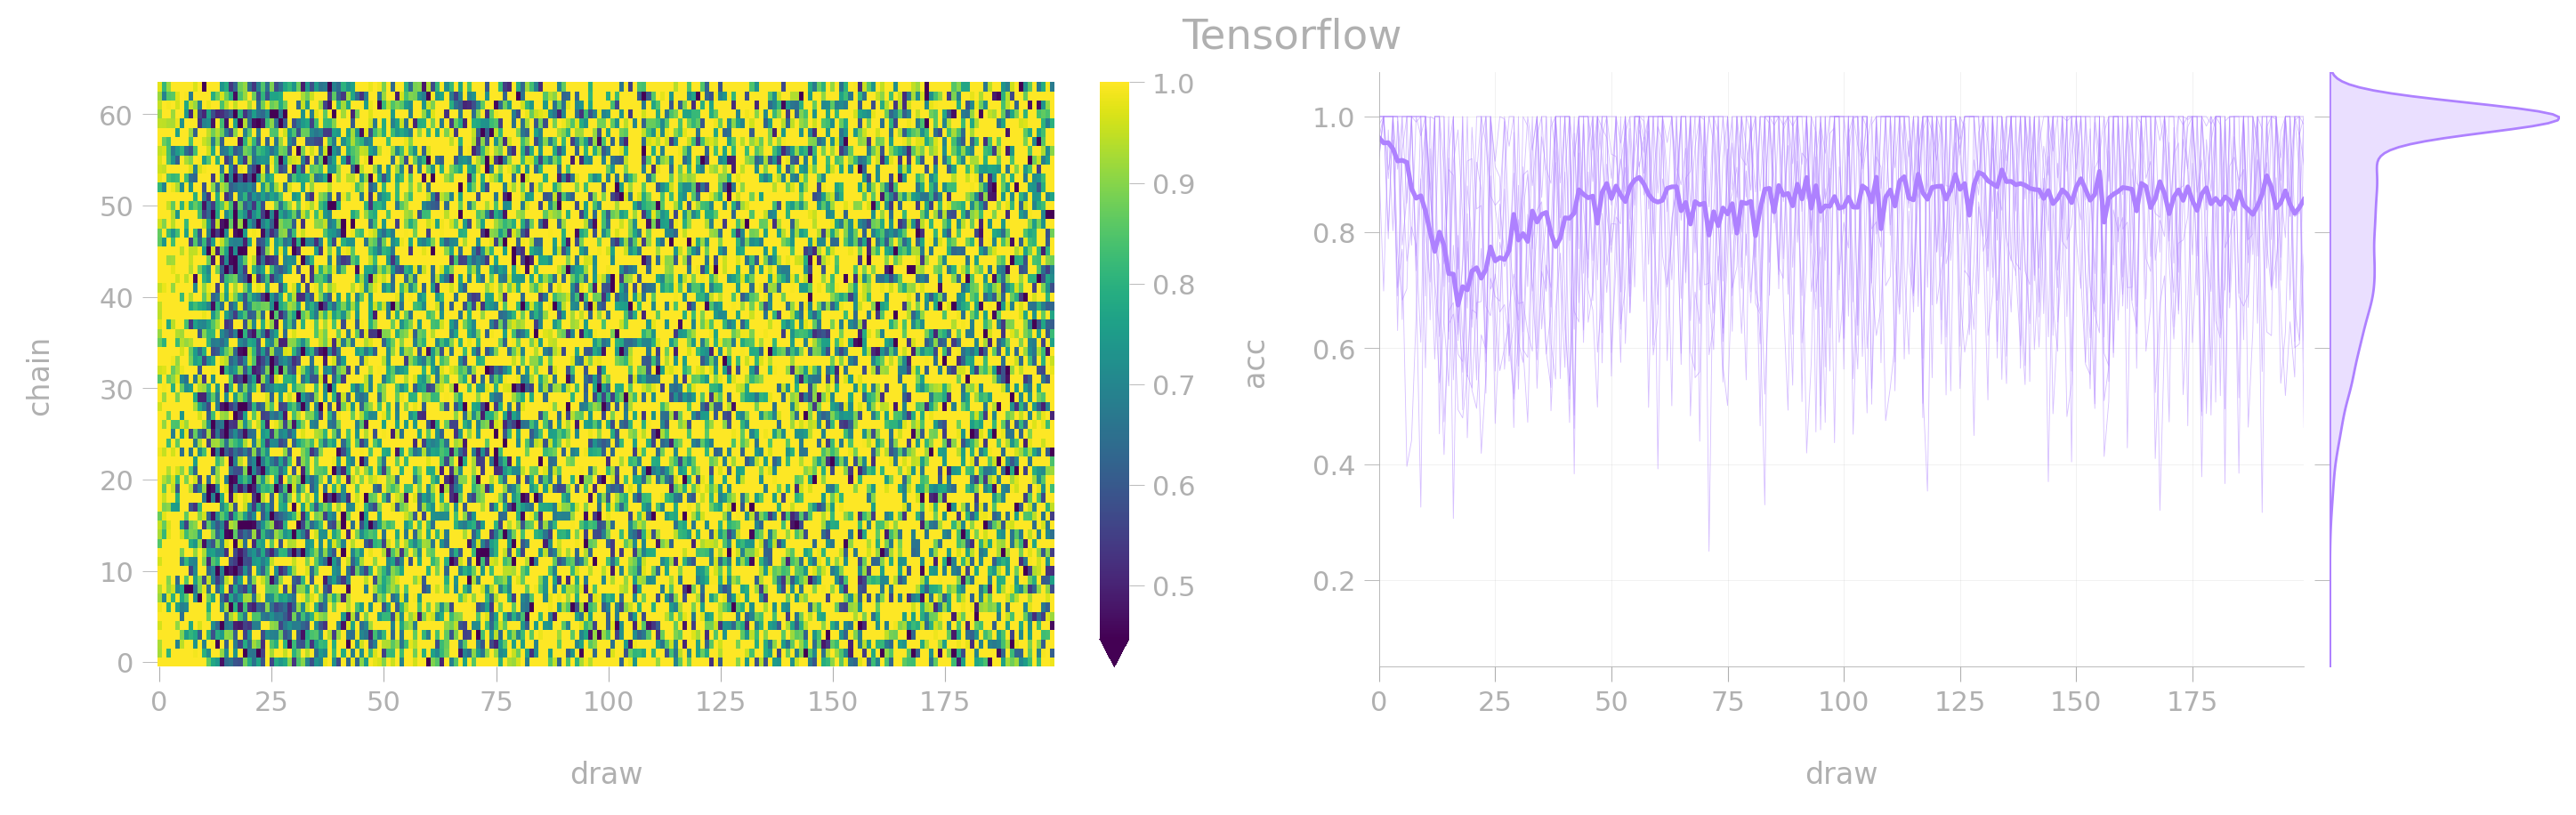

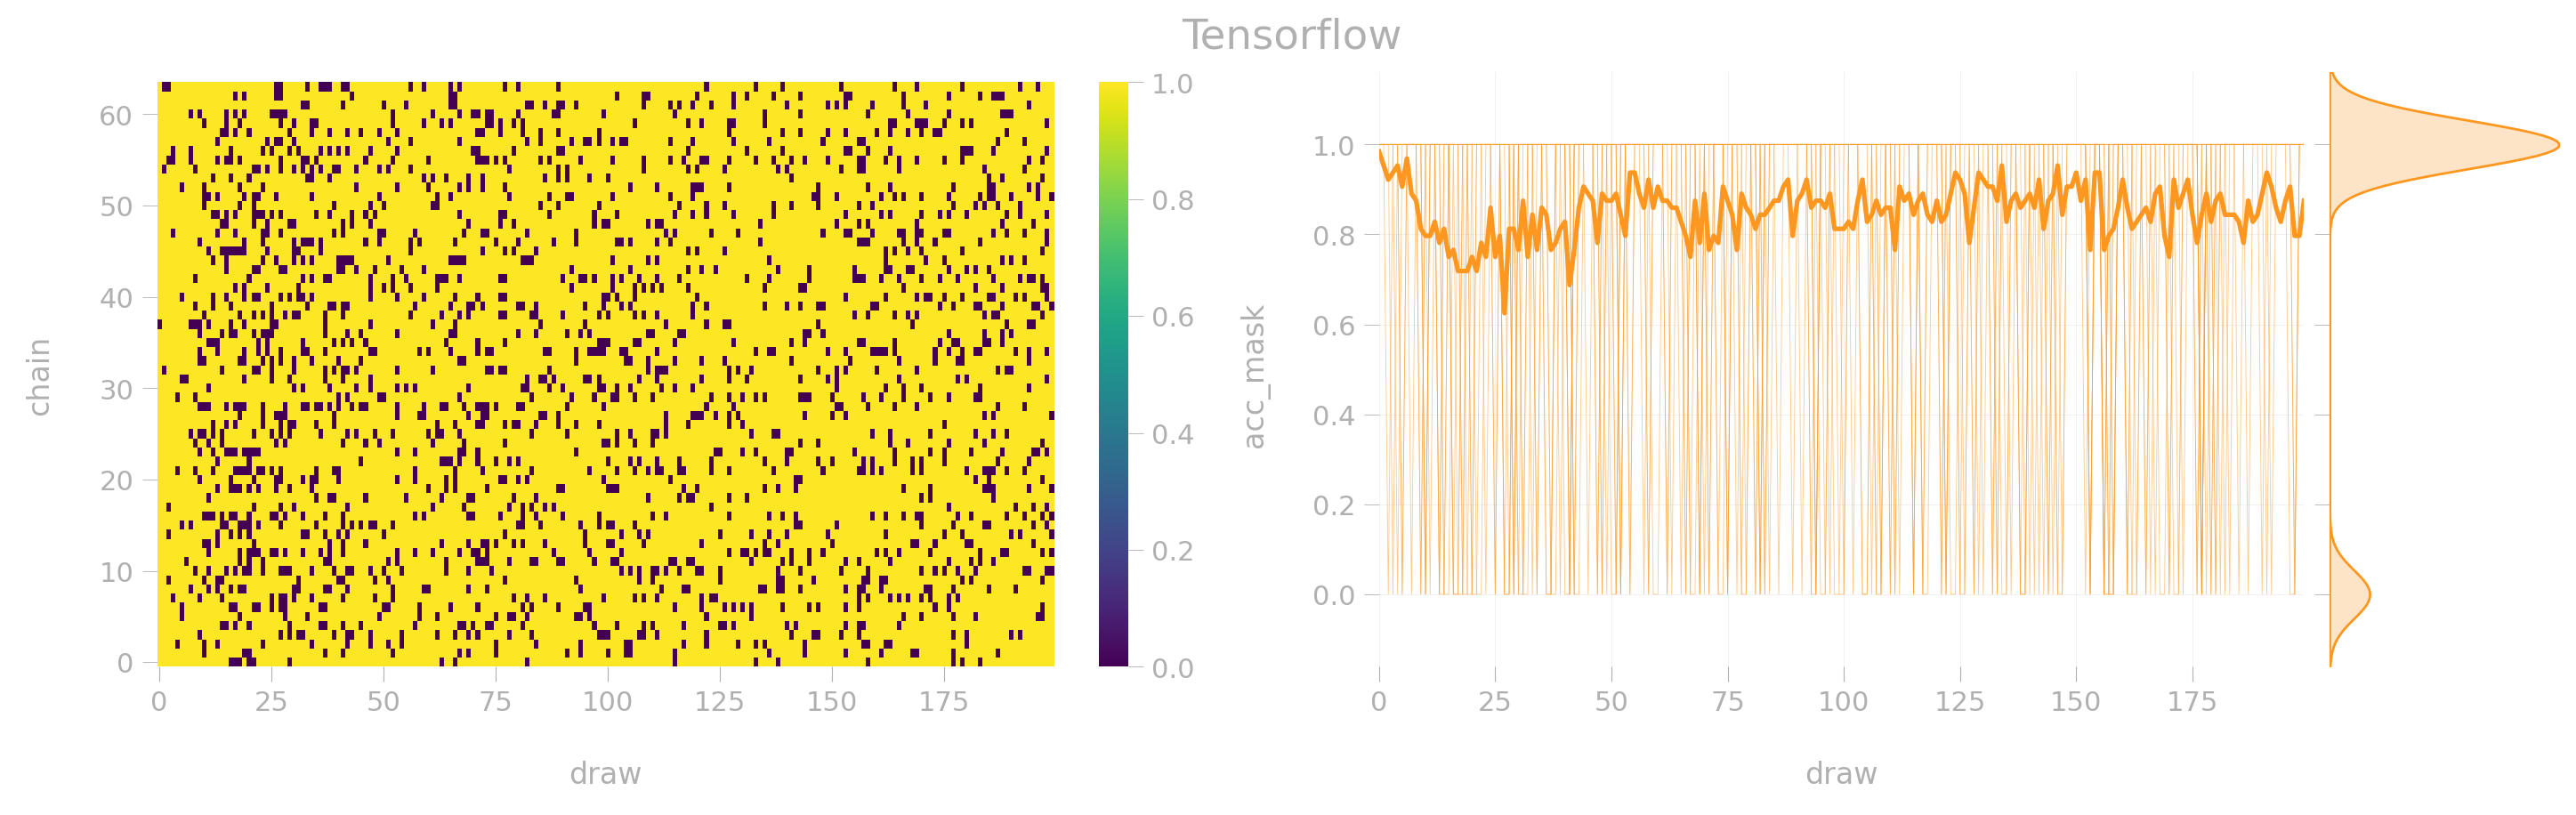

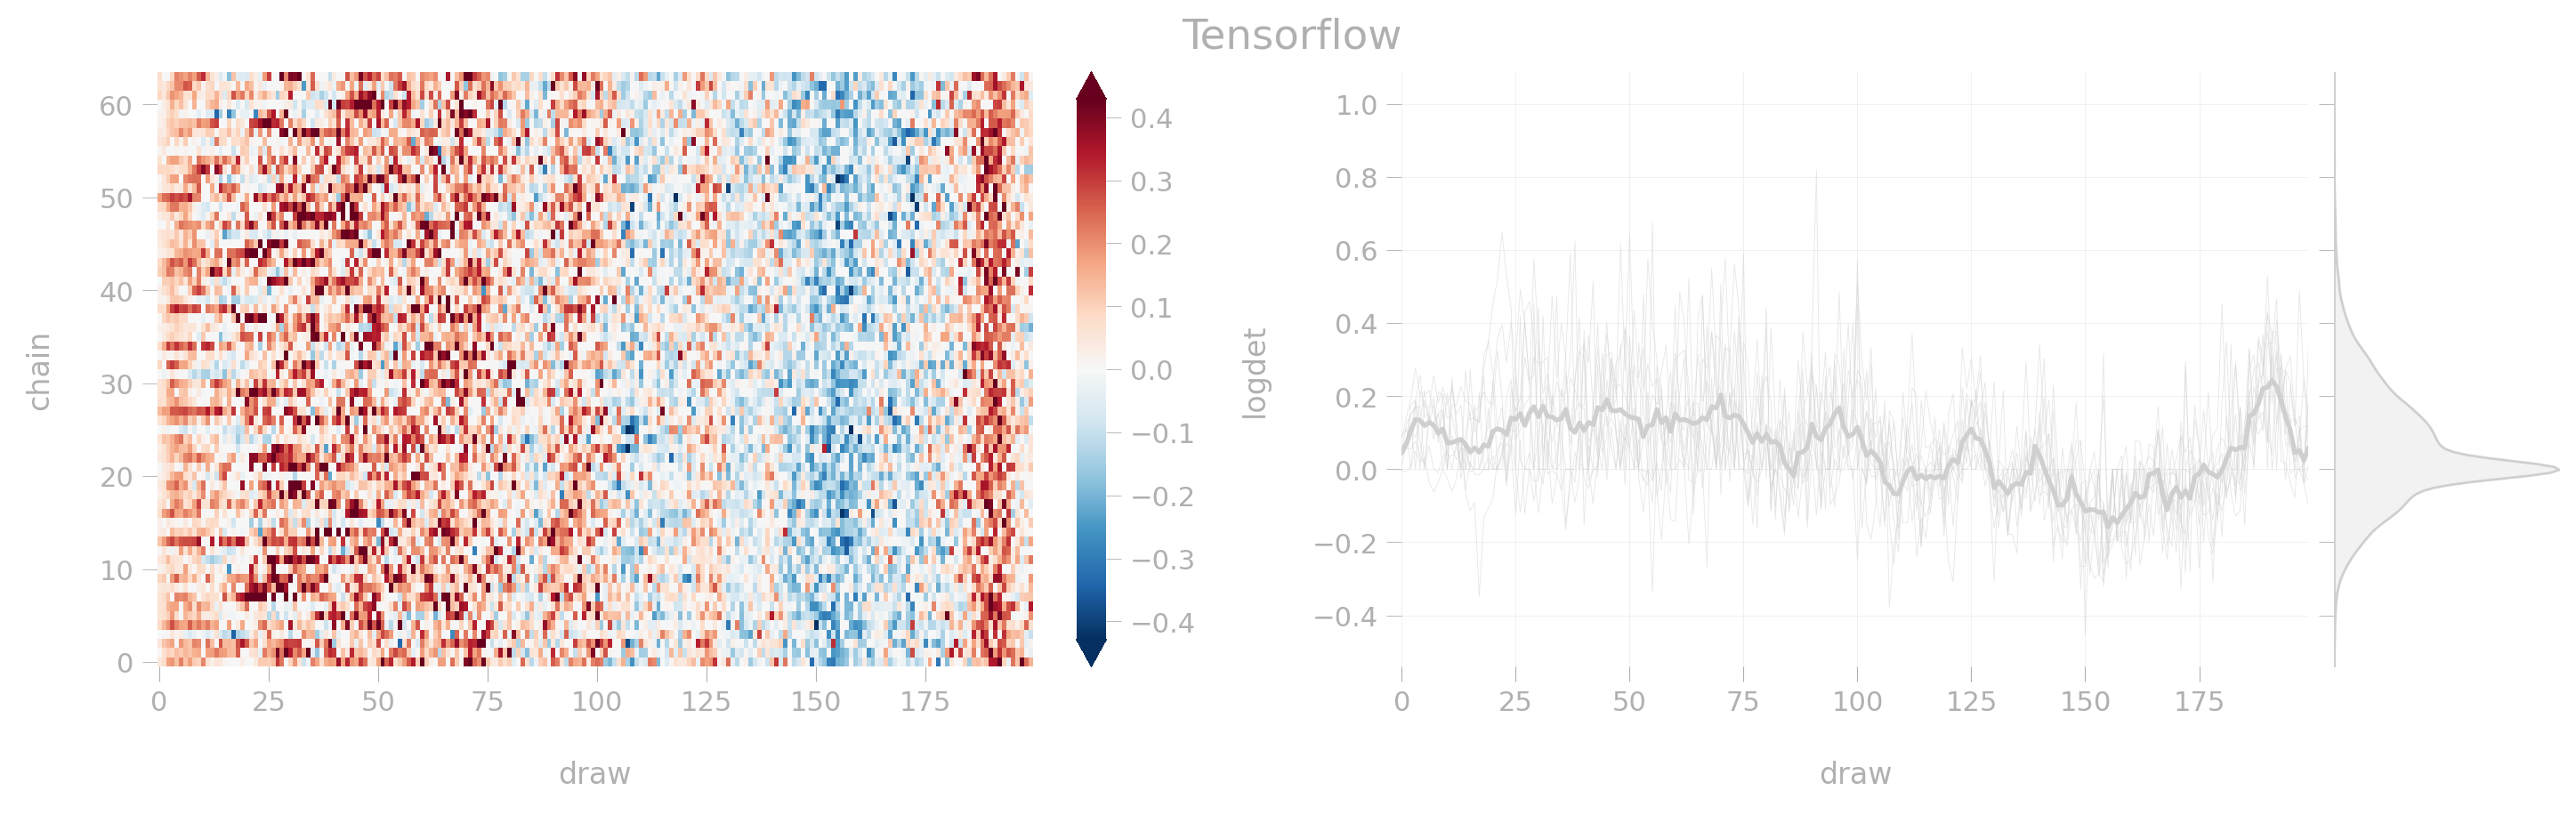

In [59]:
with plt.style.context(matplotx.styles.dufte):
    _ = history_tf.plot_all(num_chains=10, title="Tensorflow")

## Plot **all** `PyTorch` training metrics:

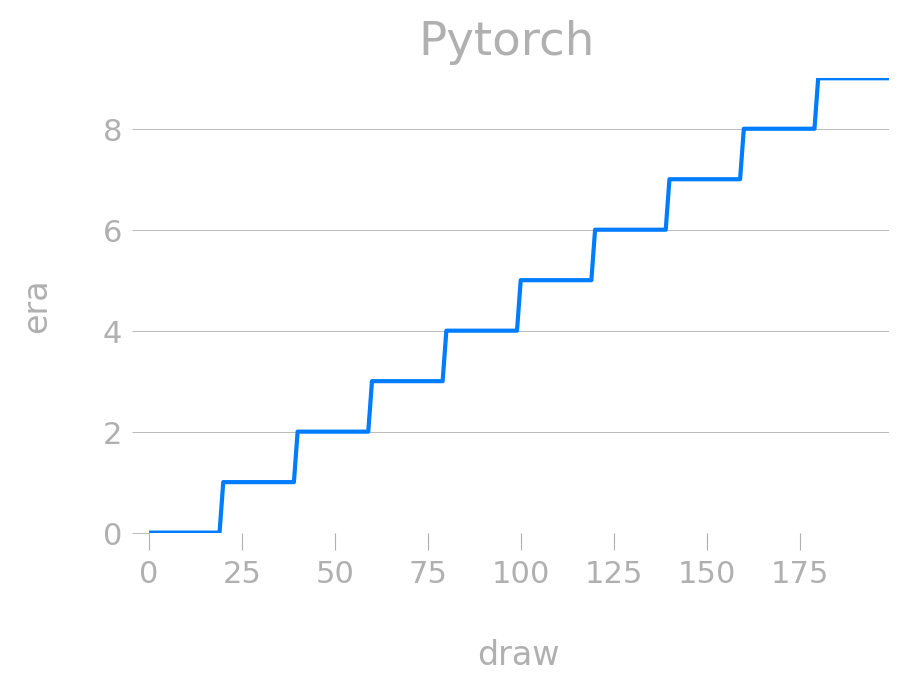

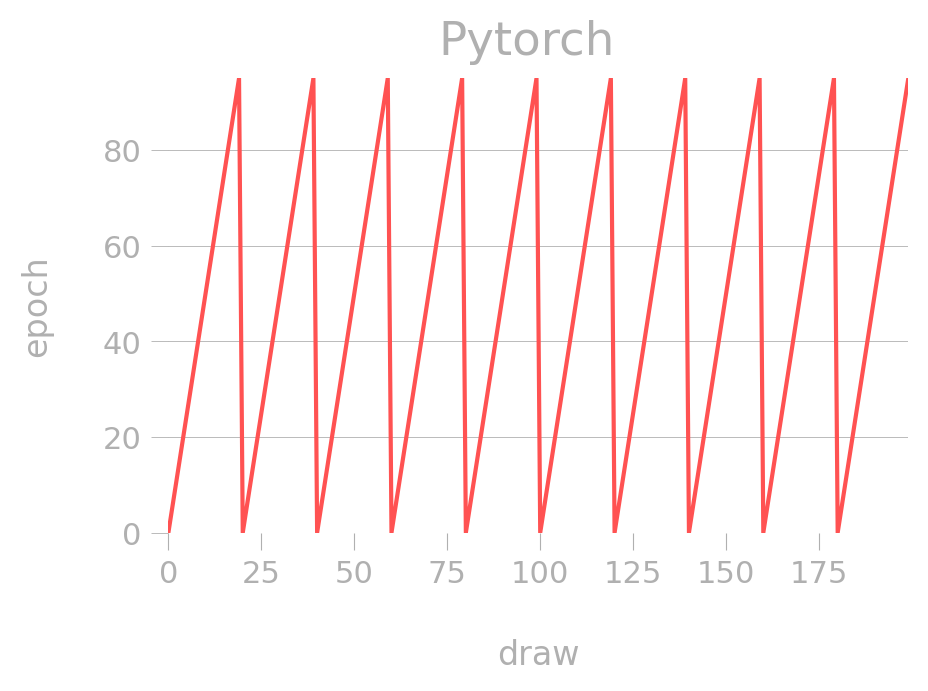

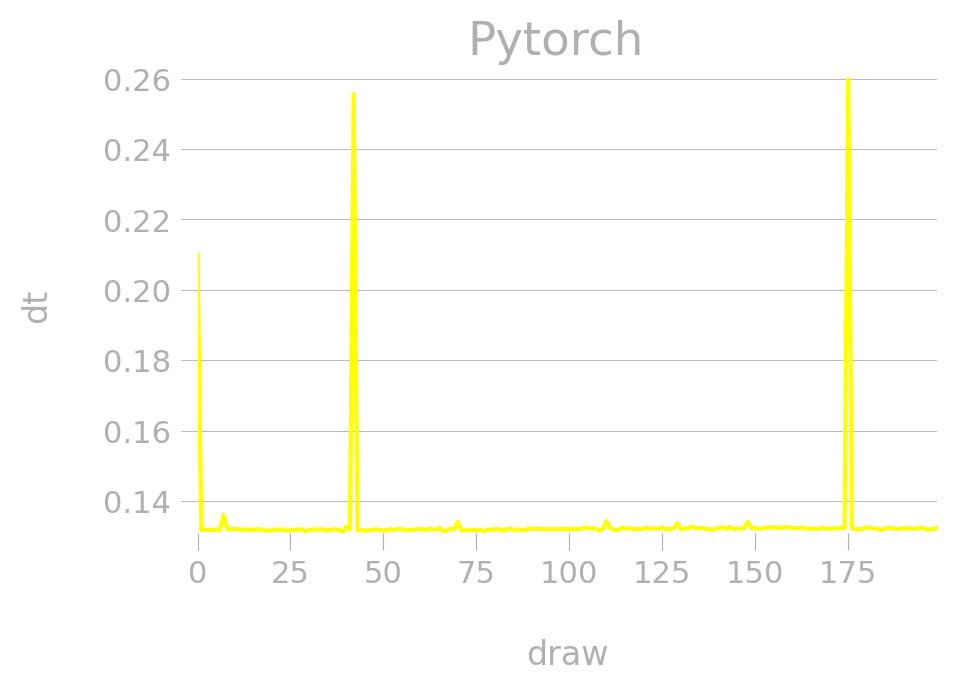

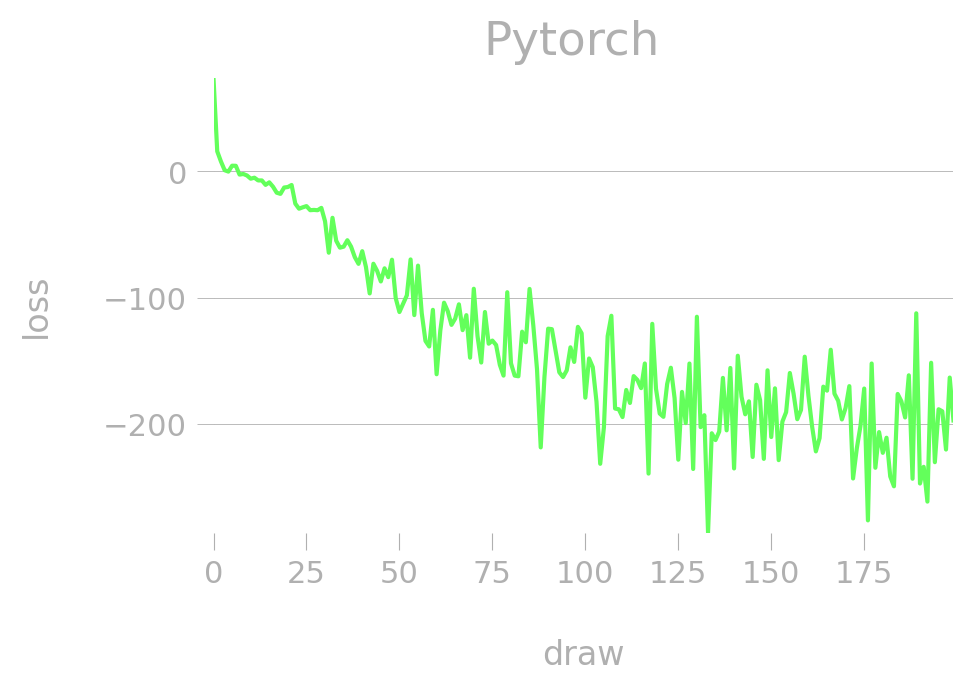

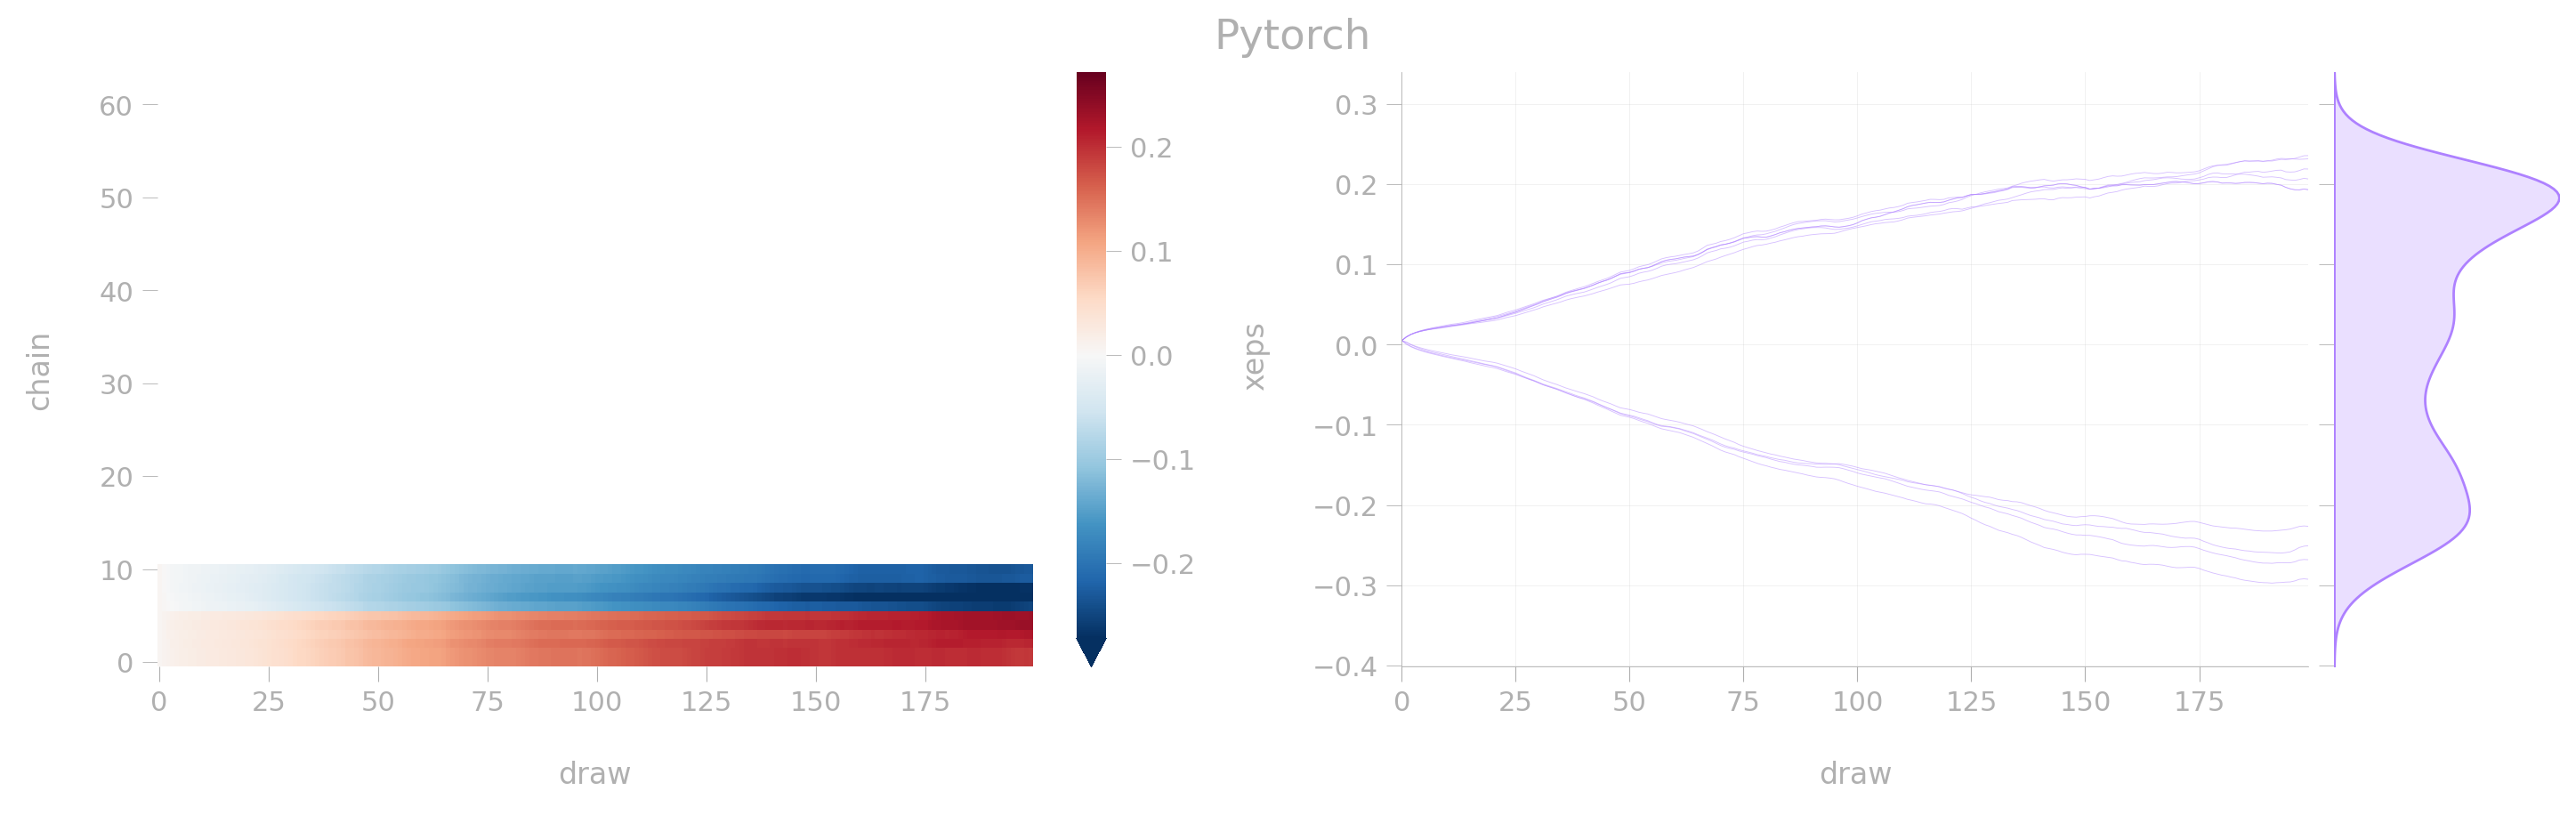

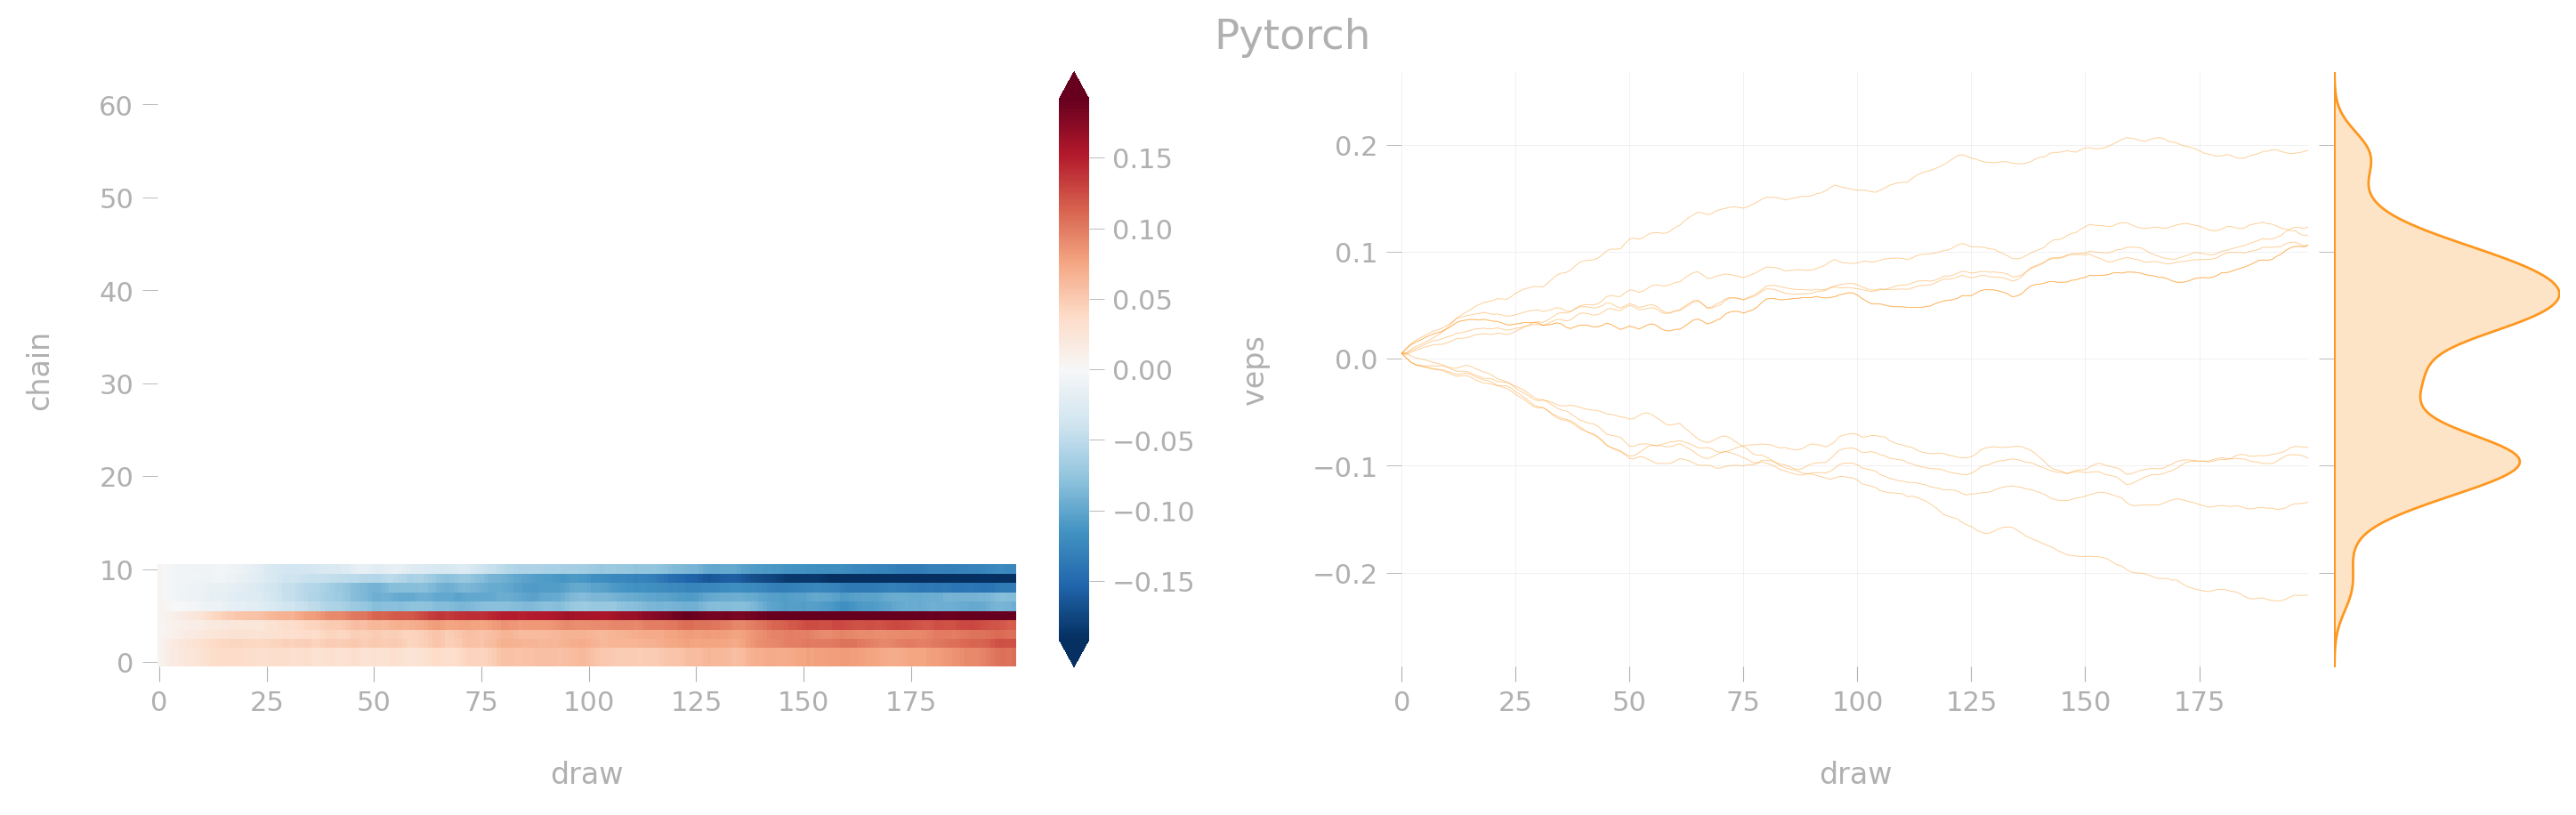

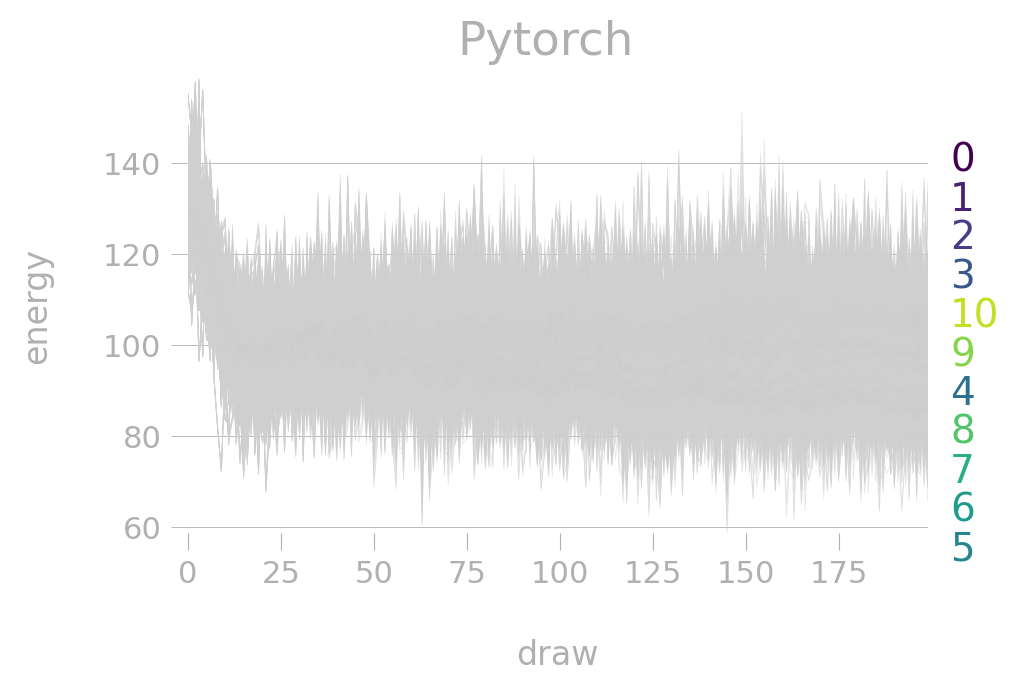

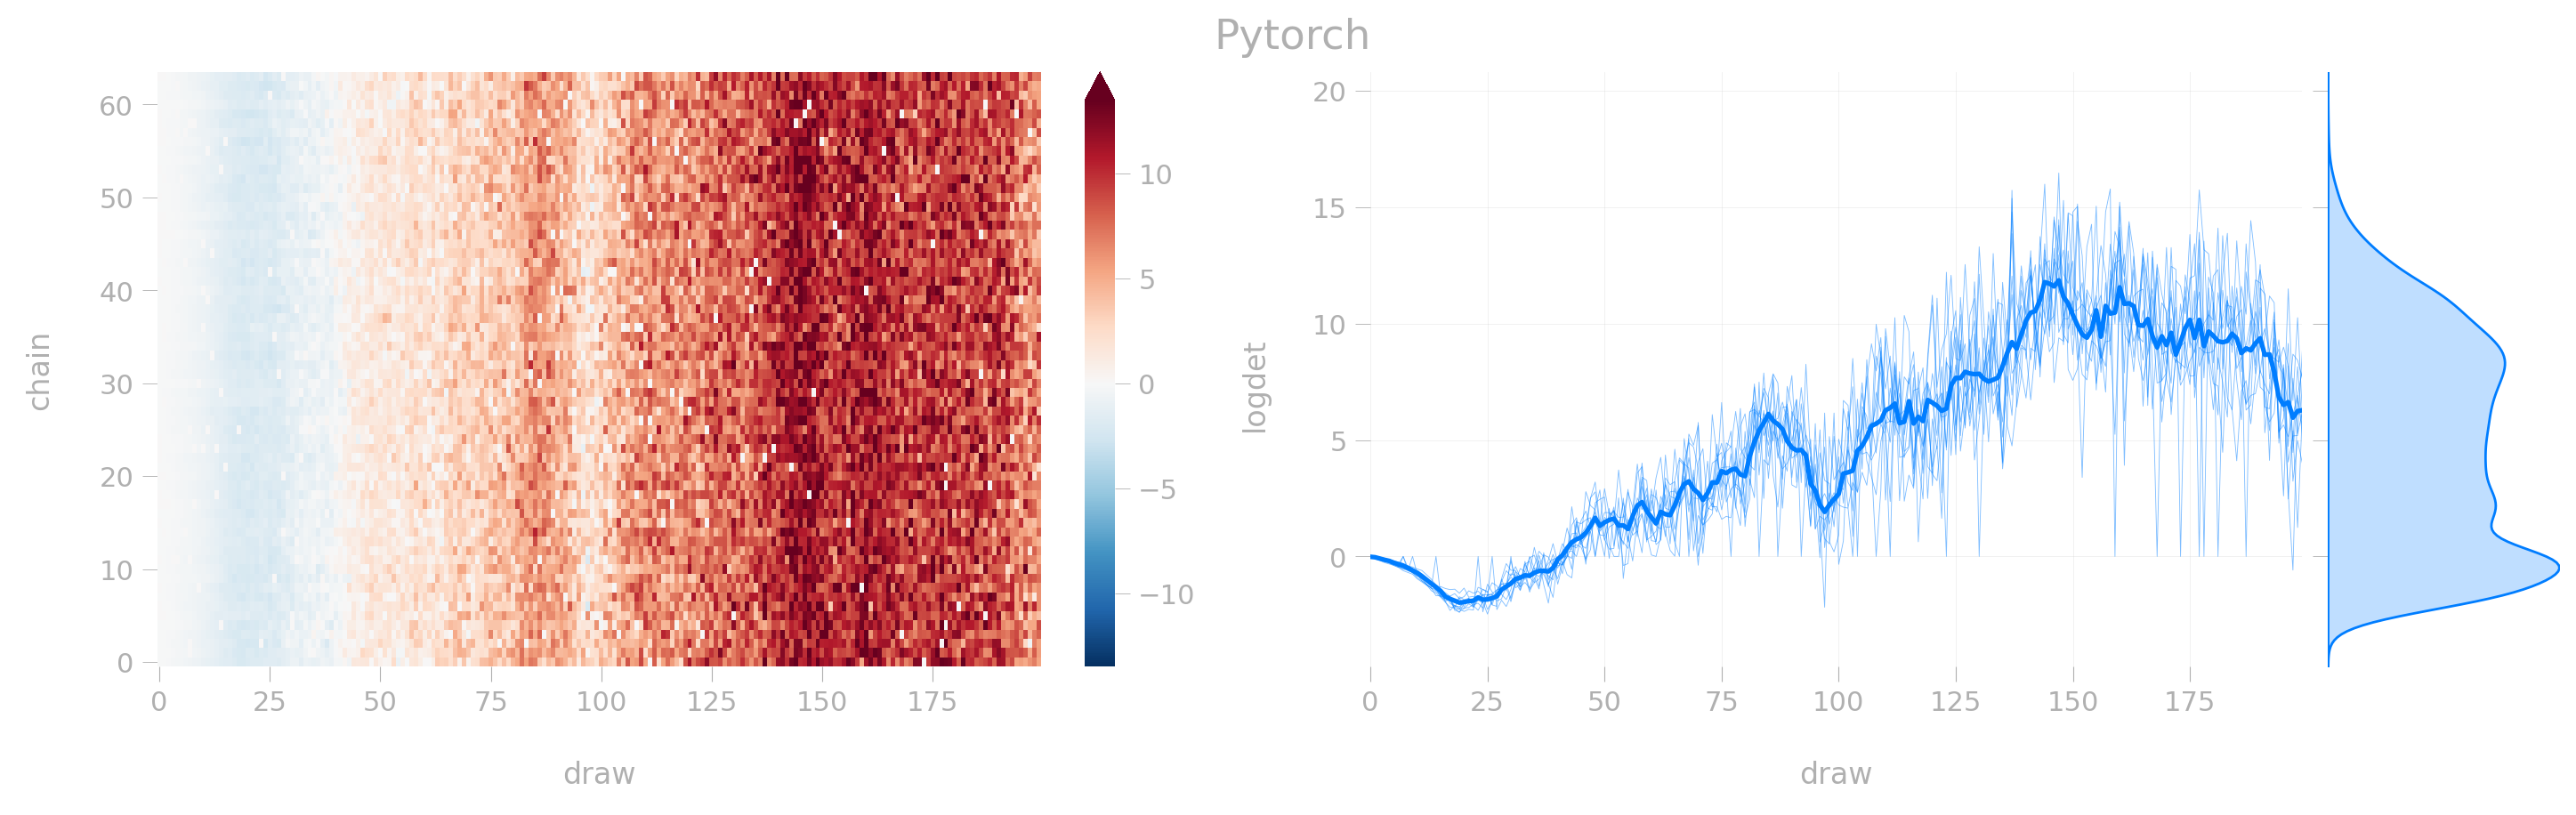

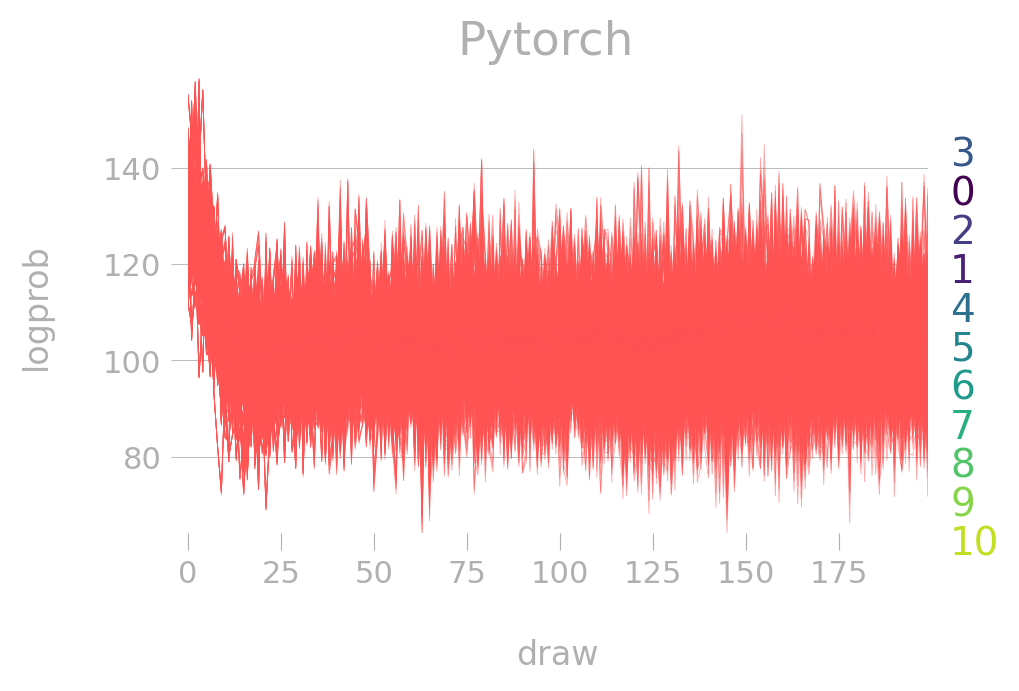

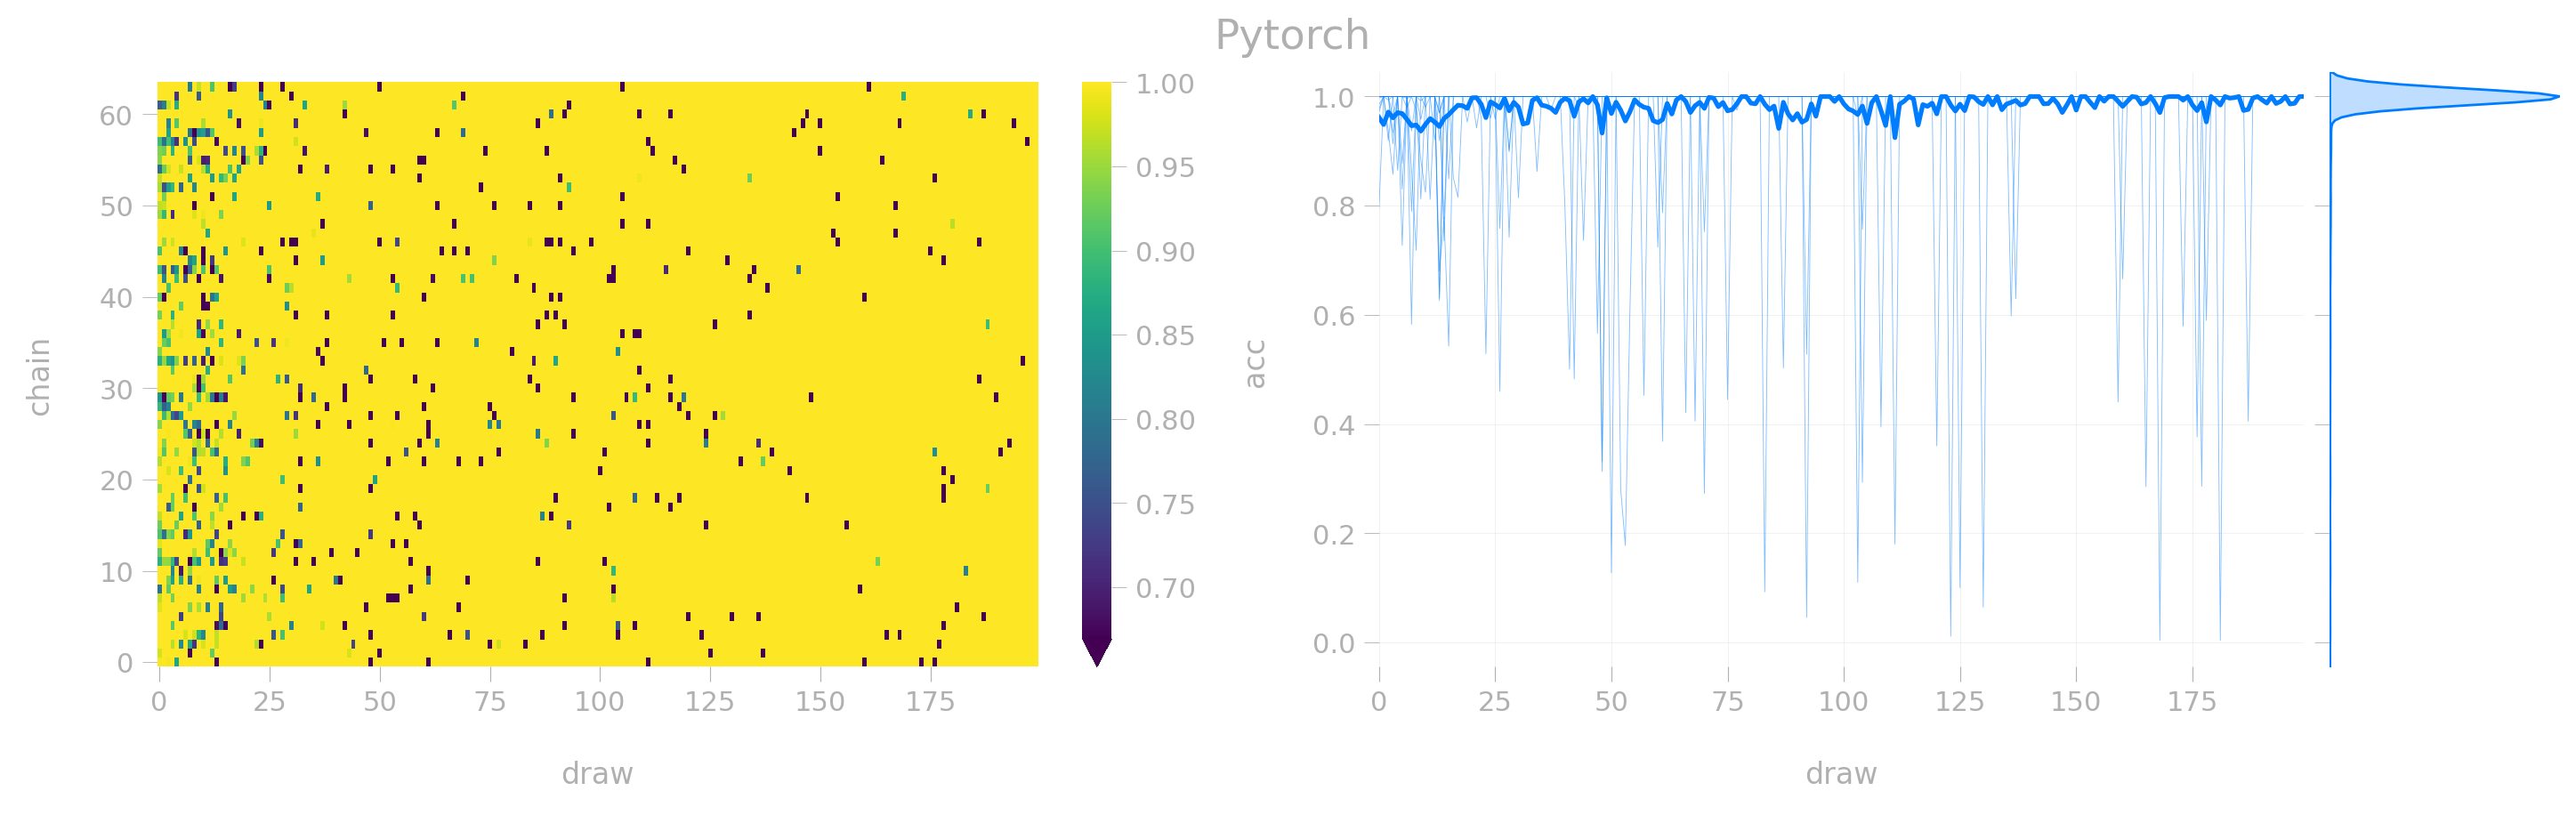

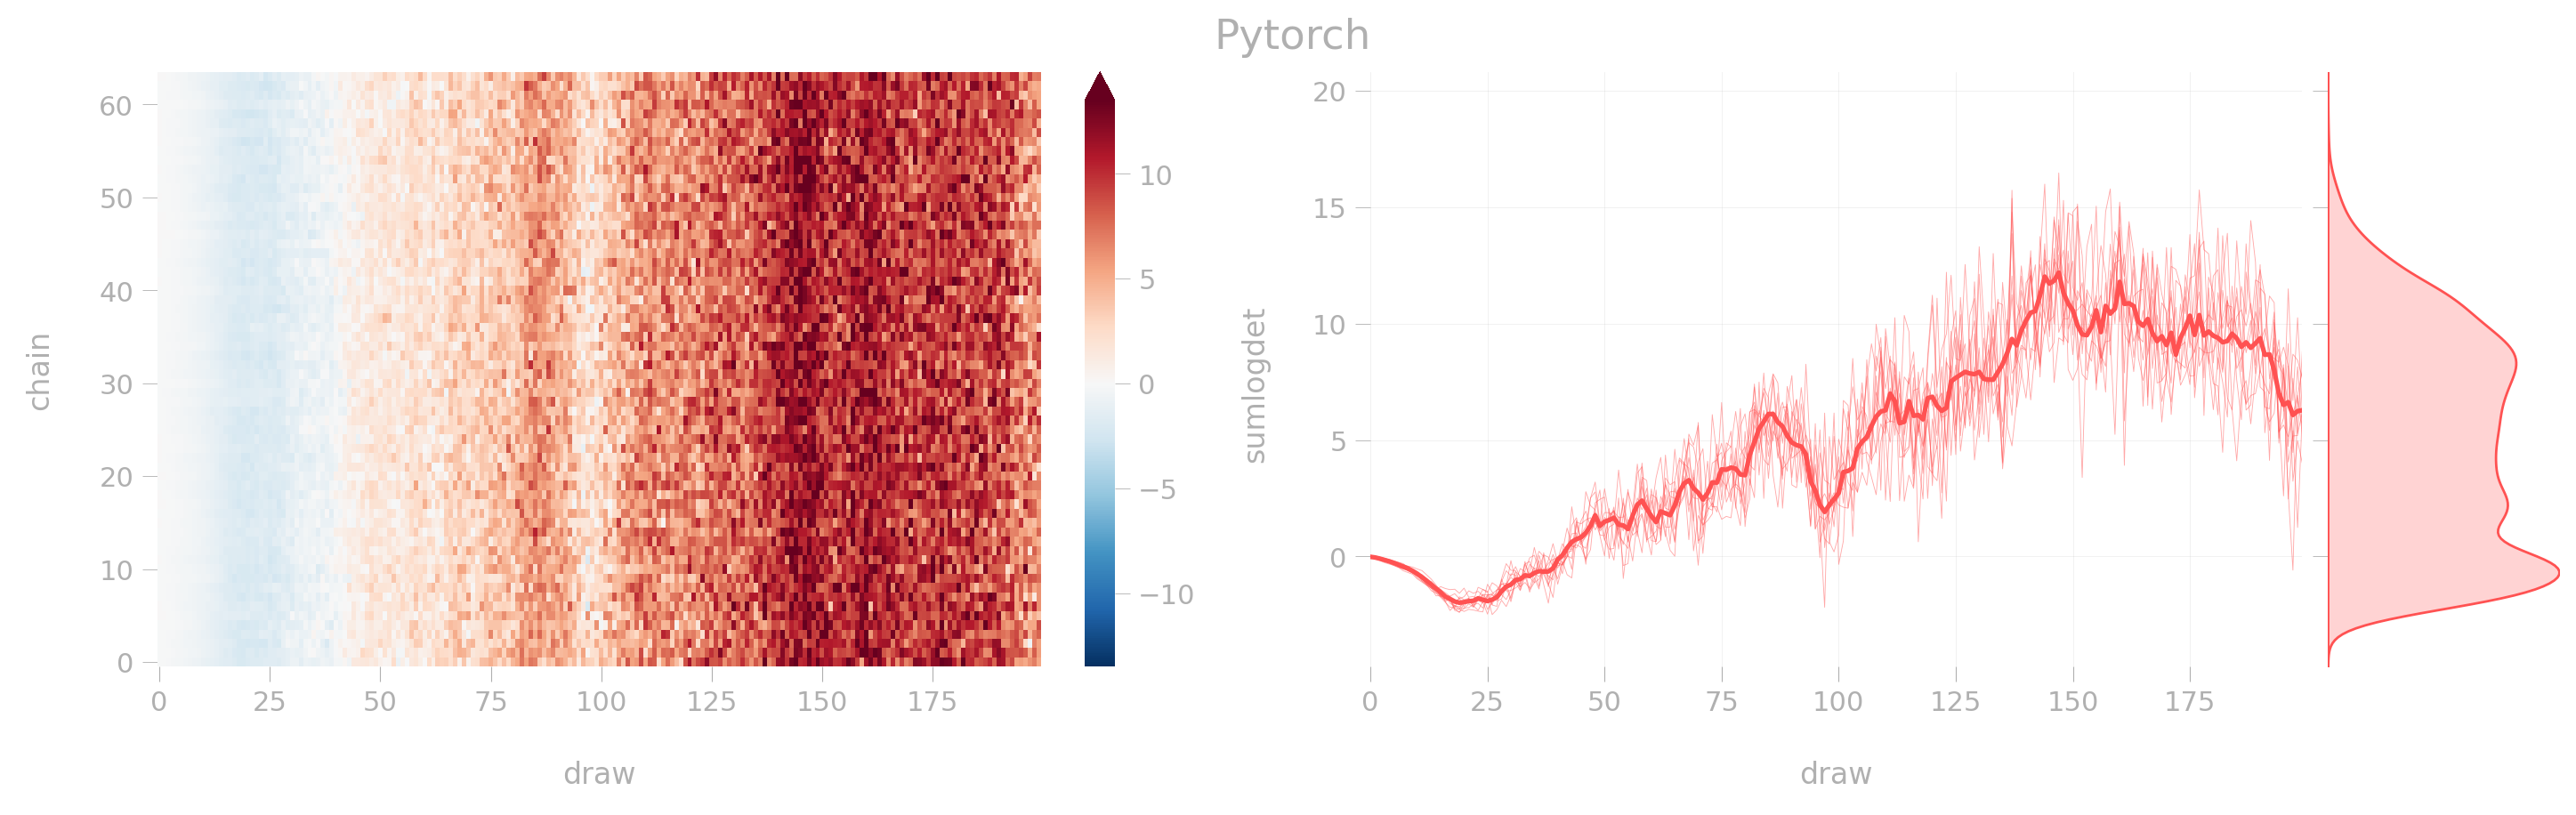

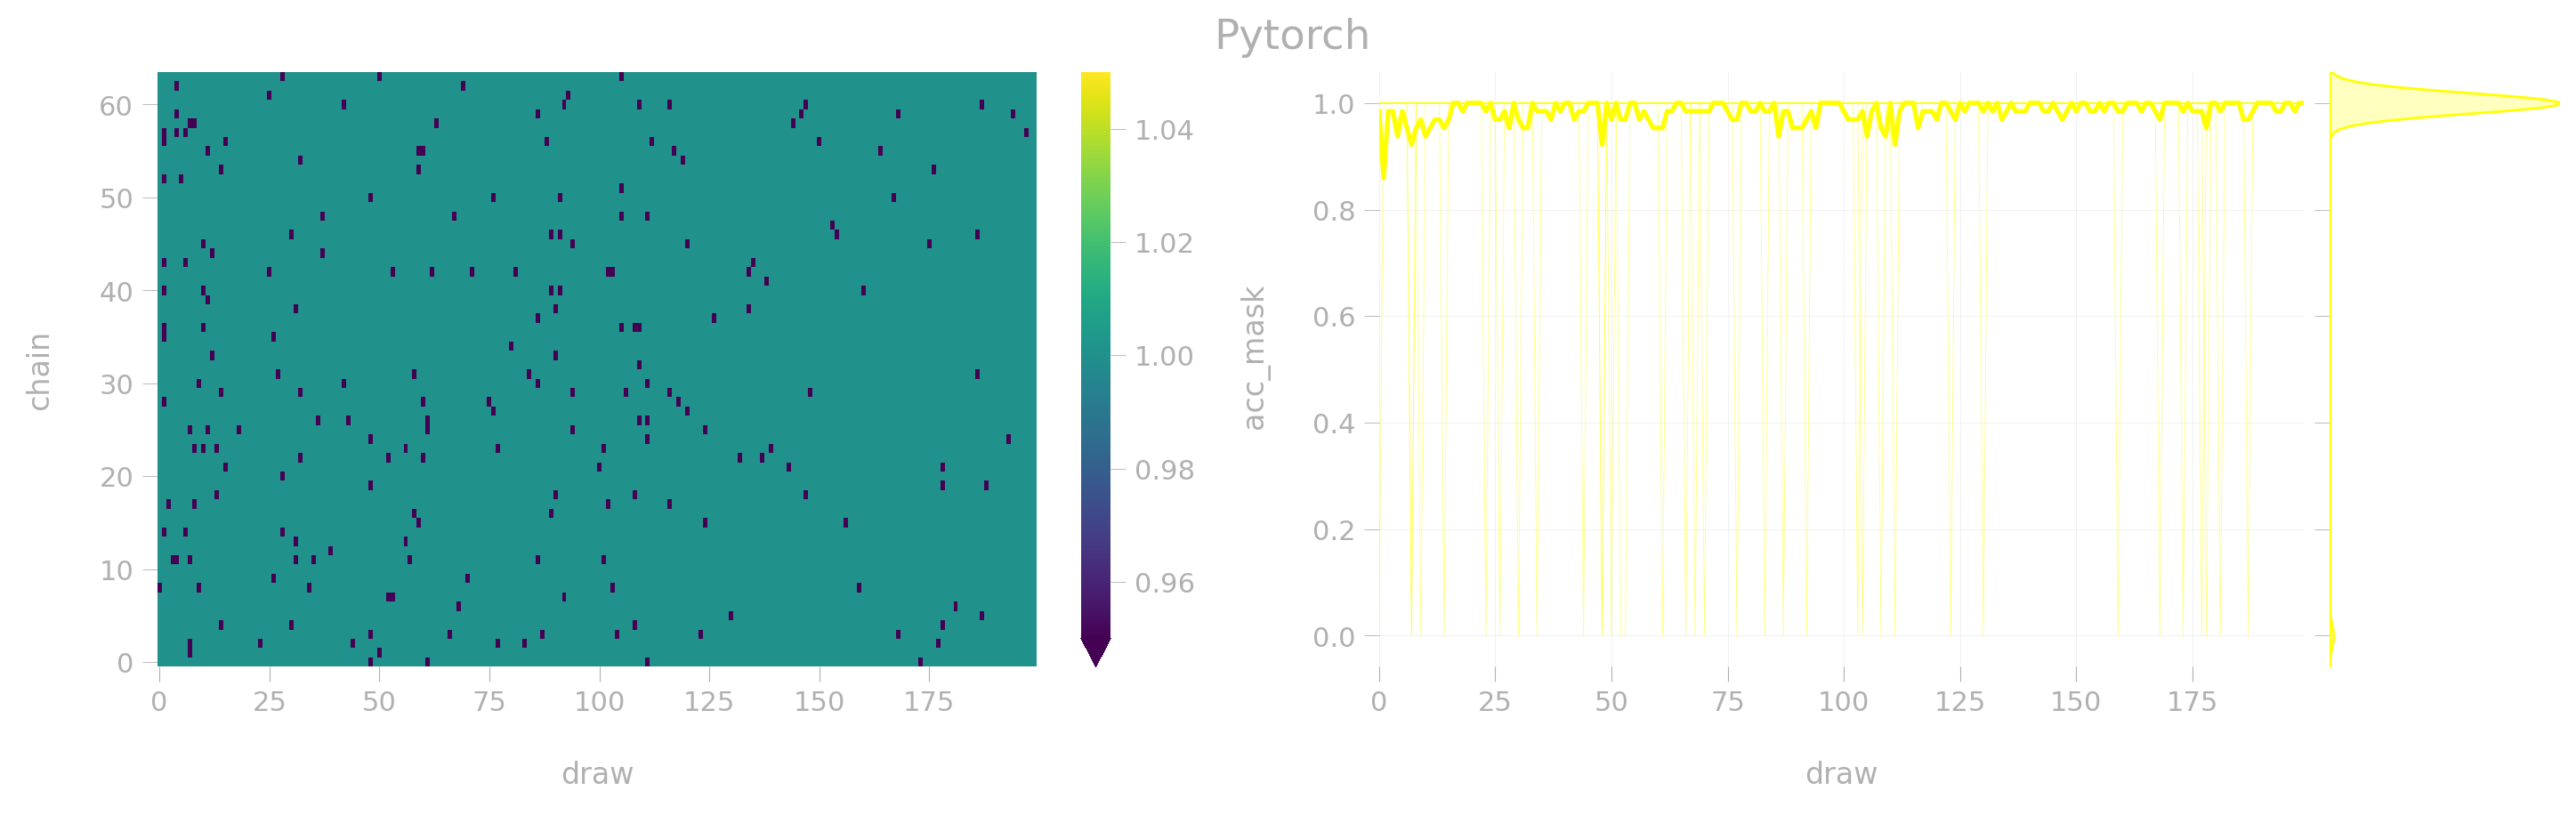

In [60]:
with plt.style.context(matplotx.styles.dufte):
    _ = history_pt.plot_all(num_chains=10, title='Pytorch')

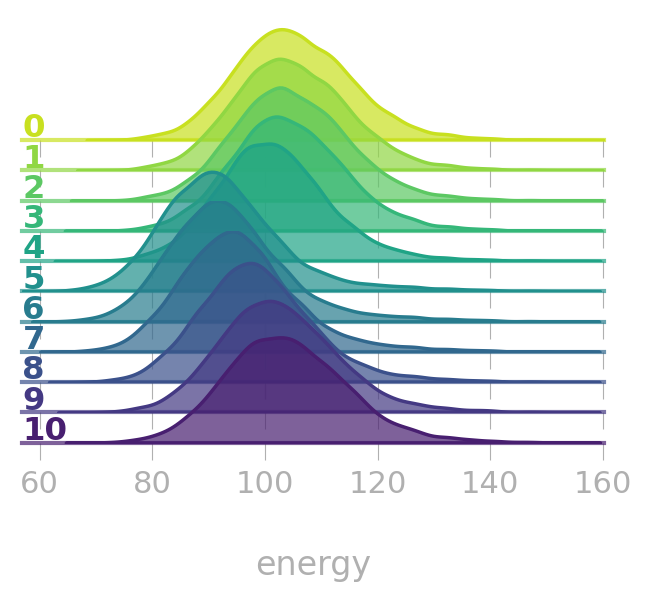

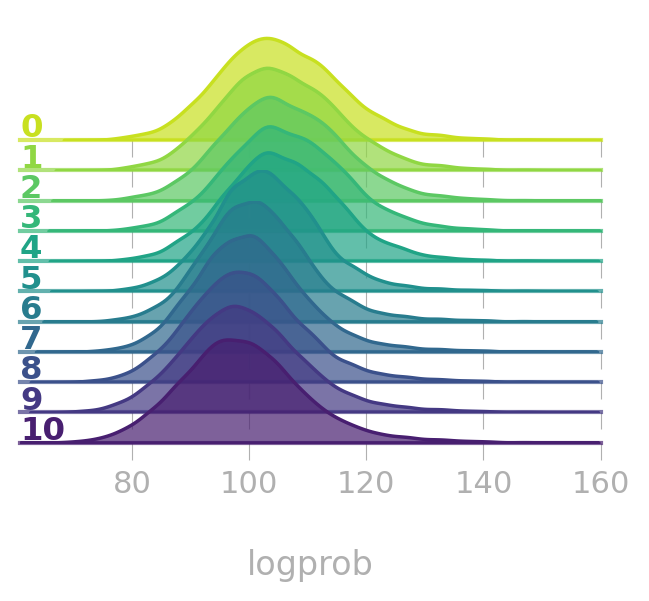

In [66]:
_ = hplt.make_ridgeplots(dataset_pt)